# 0. Setup

In [ ]:
# Install pygam package
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 885.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.


https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html

In [ ]:
# Loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for uploading images
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from pygam import GAM, LinearGAM, s, l #, f, te, LinearGAM, LogisticGAM, PoissonGAM


# 1. Loading & Preprocessing Dataset

In [ ]:
# Mouting gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File specification
file_path = '/content/drive/MyDrive/StatCompe_2024/data_folder/EngEdu_survey.xlsx'

# Loading xlsx file
df_1 = pd.read_excel(file_path, sheet_name='Sheet_1', index_col=0) # Set the first column ('Prefecture') as the index
df_2 = pd.read_excel(file_path, sheet_name='Sheet_2', index_col=0)


In [ ]:
# Convert
df_1['C_cefr_rate'] = df_1['C_cefr'] / df_1['C_s3rd']
df_1['K_cefr_rate'] = df_1['K_cefr'] / df_1['K_s3rd']
df_1['C_exam_rate'] = df_1['C_exam'] / df_1['C_s3rd']
df_1['K_exam_rate'] = df_1['K_exam'] / df_1['K_s3rd']
df_1['C_CDgrasp_rate'] = df_1['C_CDgrasp'] / df_1['C_sch']
df_1['K_CDgrasp_rate'] = df_1['K_CDgrasp'] / df_1['K_sch']

df_1['C_ALT_rate'] = df_1['C_ALT'] / df_1['C_sch'] # Deviding by the number of schools, a few datapoints exceed 1.0.
df_1['K_ALT_rate'] = df_1['K_ALT'] / df_1['K_sch'] # Deviding by the number of students, however, the output would be too small, shrinking the variability.
df_1['C_ALTout_rate'] = df_1['C_ALTout'] / df_1['C_sch']
df_1['K_ALTout_rate'] = df_1['K_ALTout'] / df_1['K_sch']

df_1['C_LA_score'] = 0.5*df_1['C_LA75'] + 0.2*df_1['C_LA50'] +0.1
df_1['K_LA_score'] = 0.5*df_1['K_LA75'] + 0.2*df_1['K_LA50'] +0.1
df_1['C_tE_score'] = 0.5*df_1['C_tE75'] + 0.2*df_1['C_tE50'] +0.1
df_1['K_tE_score'] = 0.5*df_1['K_tE75'] + 0.2*df_1['K_tE50'] +0.1

# Exclude
# excluded_columns = ['C_s3rd', 'K_s3rd', 'C_sch', 'K_sch', 'C_cefr', 'K_cefr', 'C_exam', 'K_exam',
#                     'C_CDgrasp', 'K_CDgrasp', 'C_ALT', 'K_ALT', 'C_ALTout', 'K_ALTout',
#                     'C_LA50', 'K_LA50', 'C_tE50', 'K_tE50',
#                     'C_LA75', 'K_LA75', 'C_tE75', 'K_tE75']
# df_1 = df_1.drop(columns=excluded_columns)

# Extract and rearrange the columns
new_order = ['C_cefr_rate', 'K_cefr_rate', 'C_LA_score', 'K_LA_score',
             'C_exam_rate', 'K_exam_rate', 'C_CDgrasp_rate', 'K_CDgrasp_rate',
             'C_ALT_rate', 'K_ALT_rate', 'C_ALTout_rate', 'K_ALTout_rate',
             'C_tE_score', 'K_tE_score', 'C_SW', 'K_SW', 'C_ICTpre', 'K_ICTpre', 'C_ICTrec', 'K_ICTrec']
df_1 = df_1.reindex(columns=new_order)

# Check
print(df_1.shape)
df_1.head()

(47, 20)


C_cefr_rate  K_cefr_rate  C_LA_score  K_LA_score  C_exam_rate  \
Prefecture                                                                  
Hokkaido       0.170836     0.321387      0.4273      0.3134     0.312517   
Aomiri         0.252135     0.372363      0.3625      0.2040     0.408906   
Iwate          0.271197     0.337773      0.4614      0.3816     0.605983   
Miyagi         0.156606     0.256923      0.3926      0.2506     0.295833   
Akita          0.270989     0.227143      0.4319      0.2307     0.933541   

            K_exam_rate  C_CDgrasp_rate  K_CDgrasp_rate  C_ALT_rate  \
Prefecture                                                            
Hokkaido       0.526090        0.812367        0.822581    0.688699   
Aomiri         0.556742        0.456376        0.367647    0.684564   
Iwate          0.701433        0.865772        0.822222    0.812081   
Miyagi         0.490696        1.000000        0.554348    1.159091   
Akita          0.983651        0.688073        0.782609    0.880734   

            K_ALT_rate  C_ALTout_rate  K_ALTout_rate  C_tE_score  K_tE_score  \
Prefecture                                                                     
Hokkaido      0.379032       0.001800       0.002714      0.4475      0.3108   
Aomiri        0.411765       0.005181       0.008912      0.3471      0.1822   
Iwate         0.433333       0.005000       0.009556      0.4313      0.3425   
Miyagi        0.250000       0.006083       0.003457      0.4182      0.2250   
Akita         0.289855       0.007743       0.009058      0.4685      0.1866   

             C_SW   K_SW  C_ICTpre  K_ICTpre  C_ICTrec  K_ICTrec  
Prefecture                                                        
Hokkaido    0.966  0.580     0.910     0.625     0.657     0.418  
Aomiri      0.879  0.299     0.799     0.444     0.577     0.370  
Iwate       0.984  0.773     0.812     0.656     0.671     0.516  
Miyagi      0.922  0.390     0.818     0.723     0.636     0.554  
Akita       0.960  0.336     0.826     0.864     0.532     0.341

注釈：LA_score算出時の重み付け \
$ LA_{score}=w_{75}LA_{75}+w_{50}LA_{50}+w_{49*}LA_{49*}$ \
※$LA_{49*}=1-(LA_{75}+LA_{50}$) \
$ LA_{score}=w_{75}LA_{75}+w_{50}LA_{50}+w_{49*}(1-LA_{75}-LA_{50})$ \
$ LA_{score}=(w_{75}-w_{49*})LA_{75}+(w_{50}-w_{49*})LA_{50}+w_{49*}$ \

※$(w_{75}, w_{50}, w_{*49})=(0.6, 0.3, 0.1)$を代入；値は筆者の恣意的な設定 \
$ LA_{score}=0.5LA_{75}+0.2LA_{50}+0.1$ \
※tE_scoreも同様に算出 \
$ tE_{score}=0.5tE_{75}+0.2tE_{50}+0.1$


In [ ]:
# Filtering by C_ and K_
df_C = df_1.filter(regex='^C_')
df_K = df_1.filter(regex='^K_')

# Display the resulting sub-dataframes
print("df_C:")
print(df_C.shape)
print(df_C.head())
print("---")
print("df_K:")
print(df_K.shape)
print(df_K.head())


df_C:
(47, 10)
            C_cefr_rate  C_LA_score  C_exam_rate  C_CDgrasp_rate  C_ALT_rate  \
Prefecture                                                                     
Hokkaido       0.170836      0.4273     0.312517        0.812367    0.688699   
Aomiri         0.252135      0.3625     0.408906        0.456376    0.684564   
Iwate          0.271197      0.4614     0.605983        0.865772    0.812081   
Miyagi         0.156606      0.3926     0.295833        1.000000    1.159091   
Akita          0.270989      0.4319     0.933541        0.688073    0.880734   

            C_ALTout_rate  C_tE_score   C_SW  C_ICTpre  C_ICTrec  
Prefecture                                                        
Hokkaido         0.001800      0.4475  0.966     0.910     0.657  
Aomiri           0.005181      0.3471  0.879     0.799     0.577  
Iwate            0.005000      0.4313  0.984     0.812     0.671  
Miyagi           0.006083      0.4182  0.922     0.818     0.636  
Akita            0.007

# 2. Exploratory Data Analysis

2.1 Pairplot
- df_C
- df_K
- df_C x df_K
- cefr_rate, LA_score x SSDSE

2.2 Anomaly Detection
- cefr_rate
- LA_score
- Other variables

## 2.1 Pairplot

### df_C

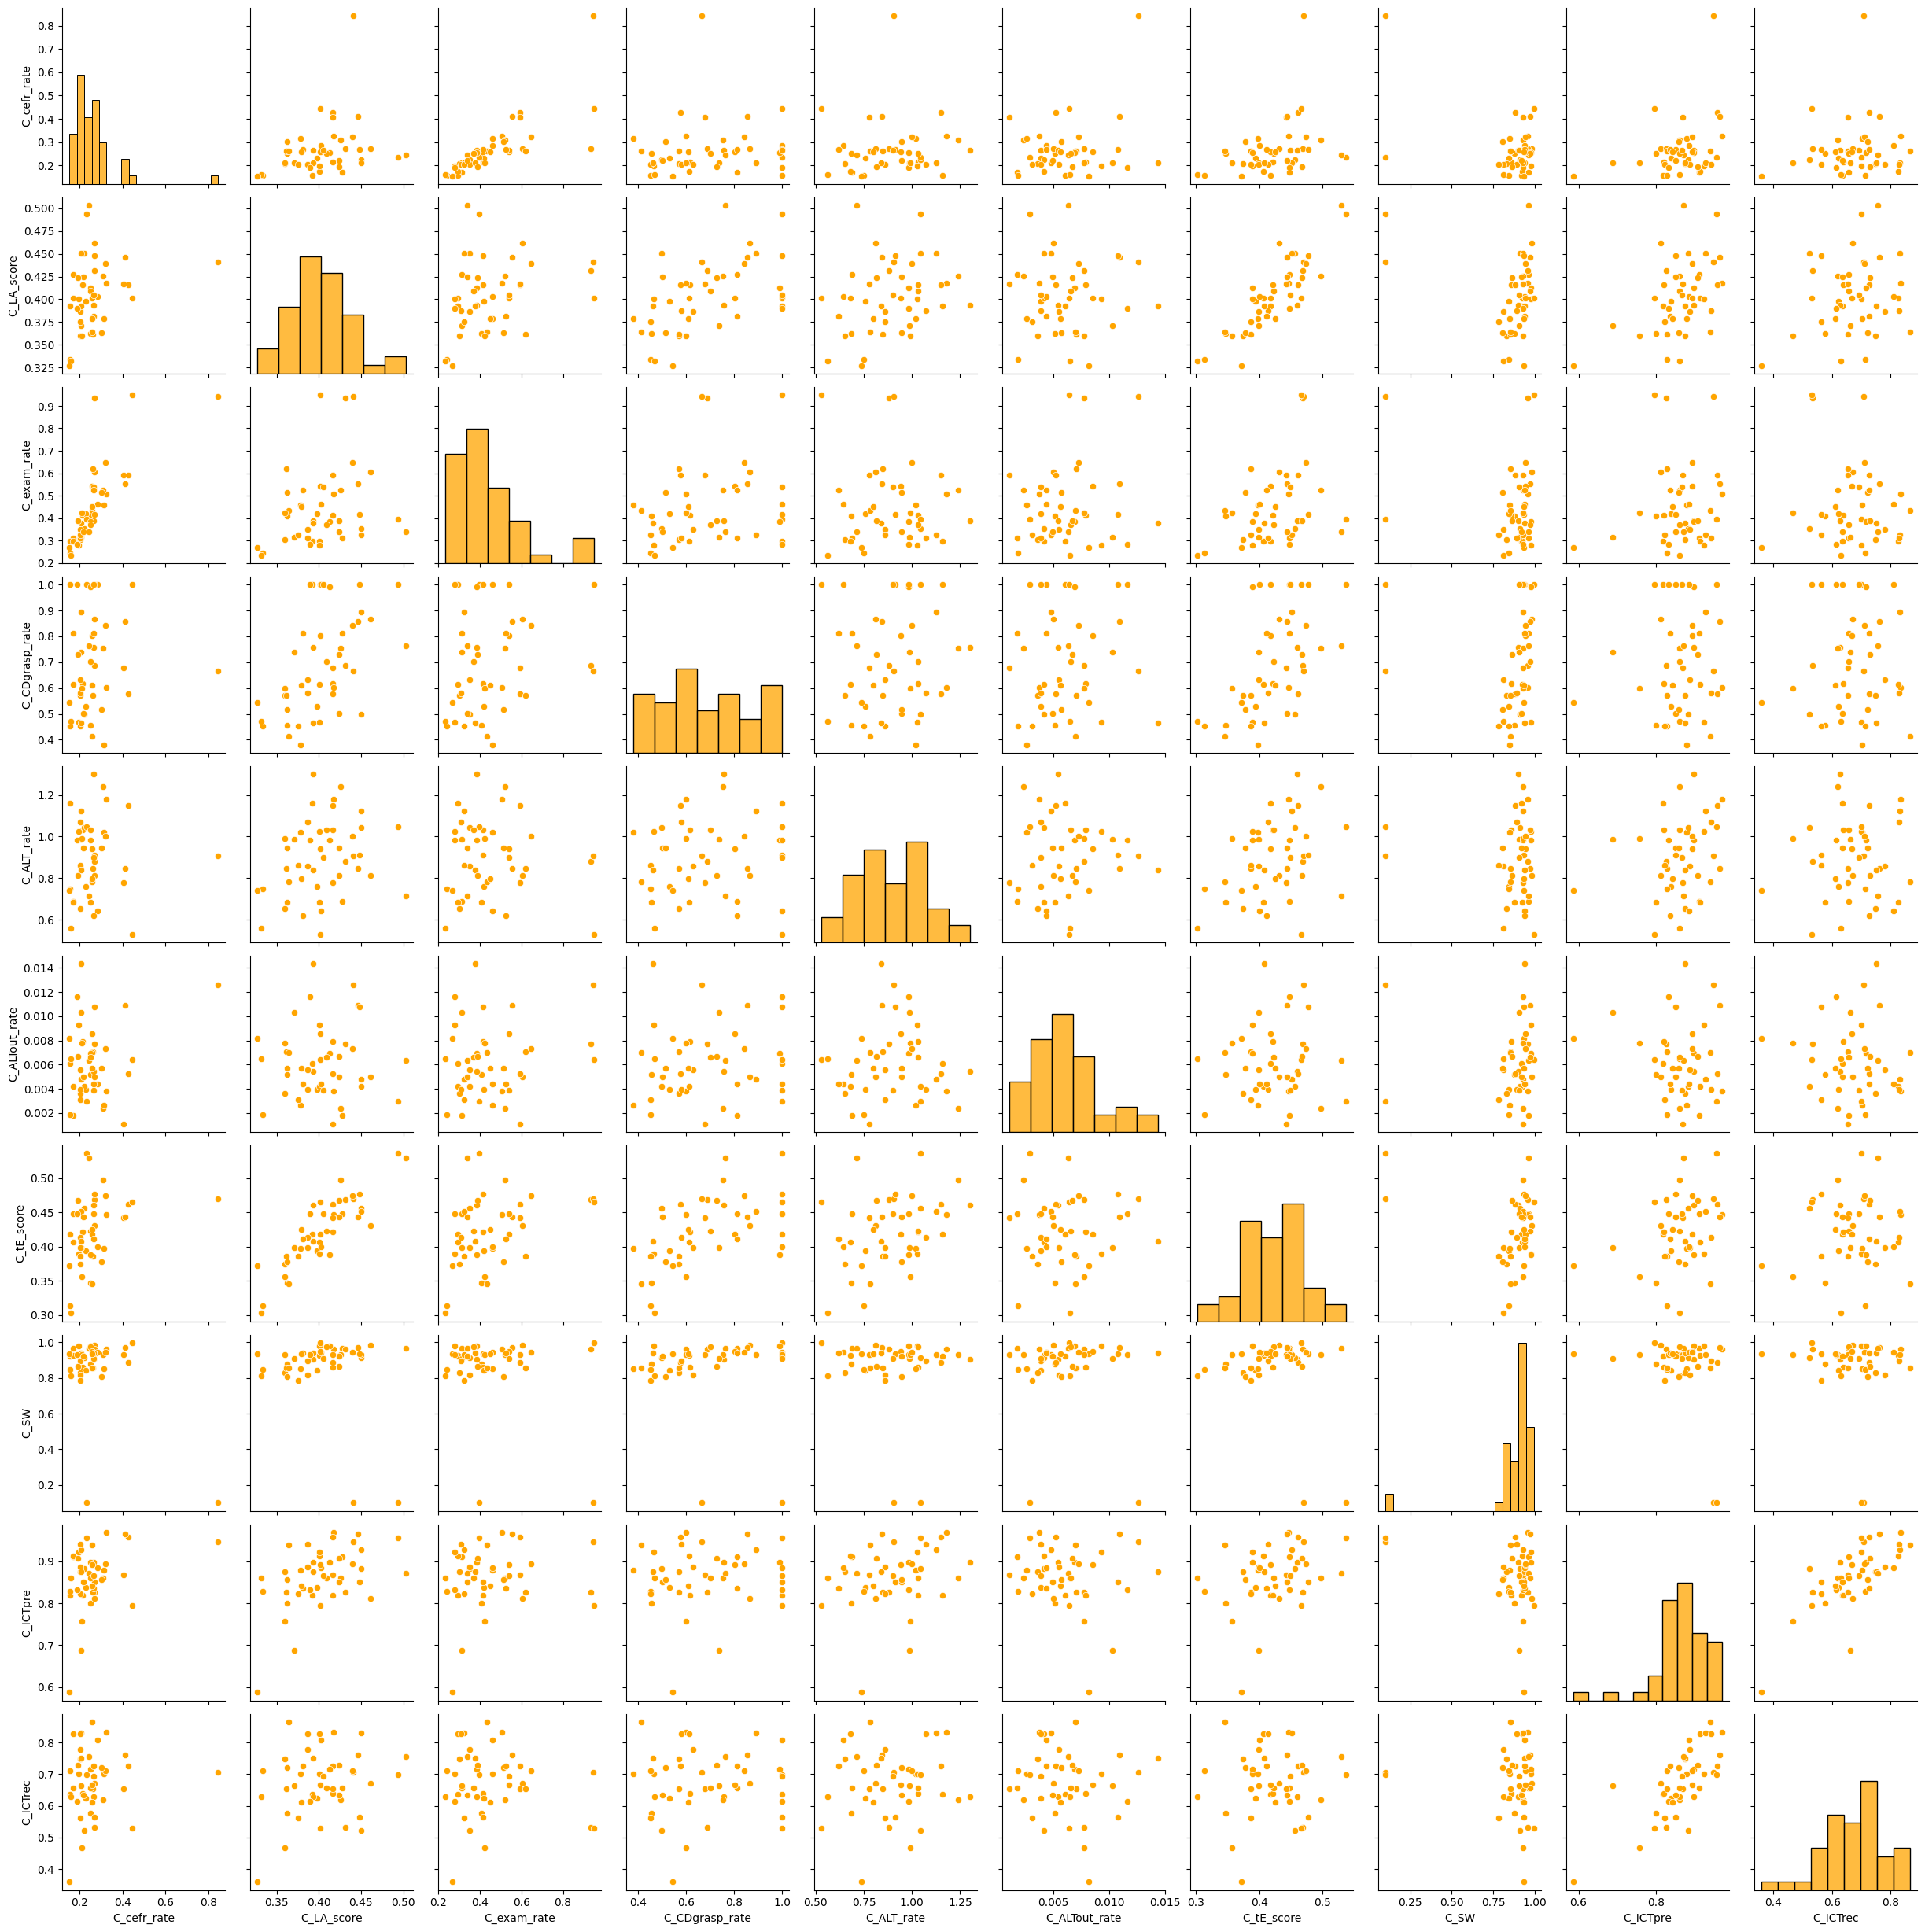

In [ ]:
# Pairplot for df_C
color1 = 'orange'
sns.pairplot(df_C, plot_kws={'color': color1}, diag_kws={'color': color1})
###
# # Drop by column names
# columns_to_drop = ['column_name_1', 'column_name_2', 'column_name_3']  # Replace with actual column names
# df_excluded = df_1.drop(columns=columns_to_drop, axis=1)
# sns.pairplot(df_excluded)

### df_K

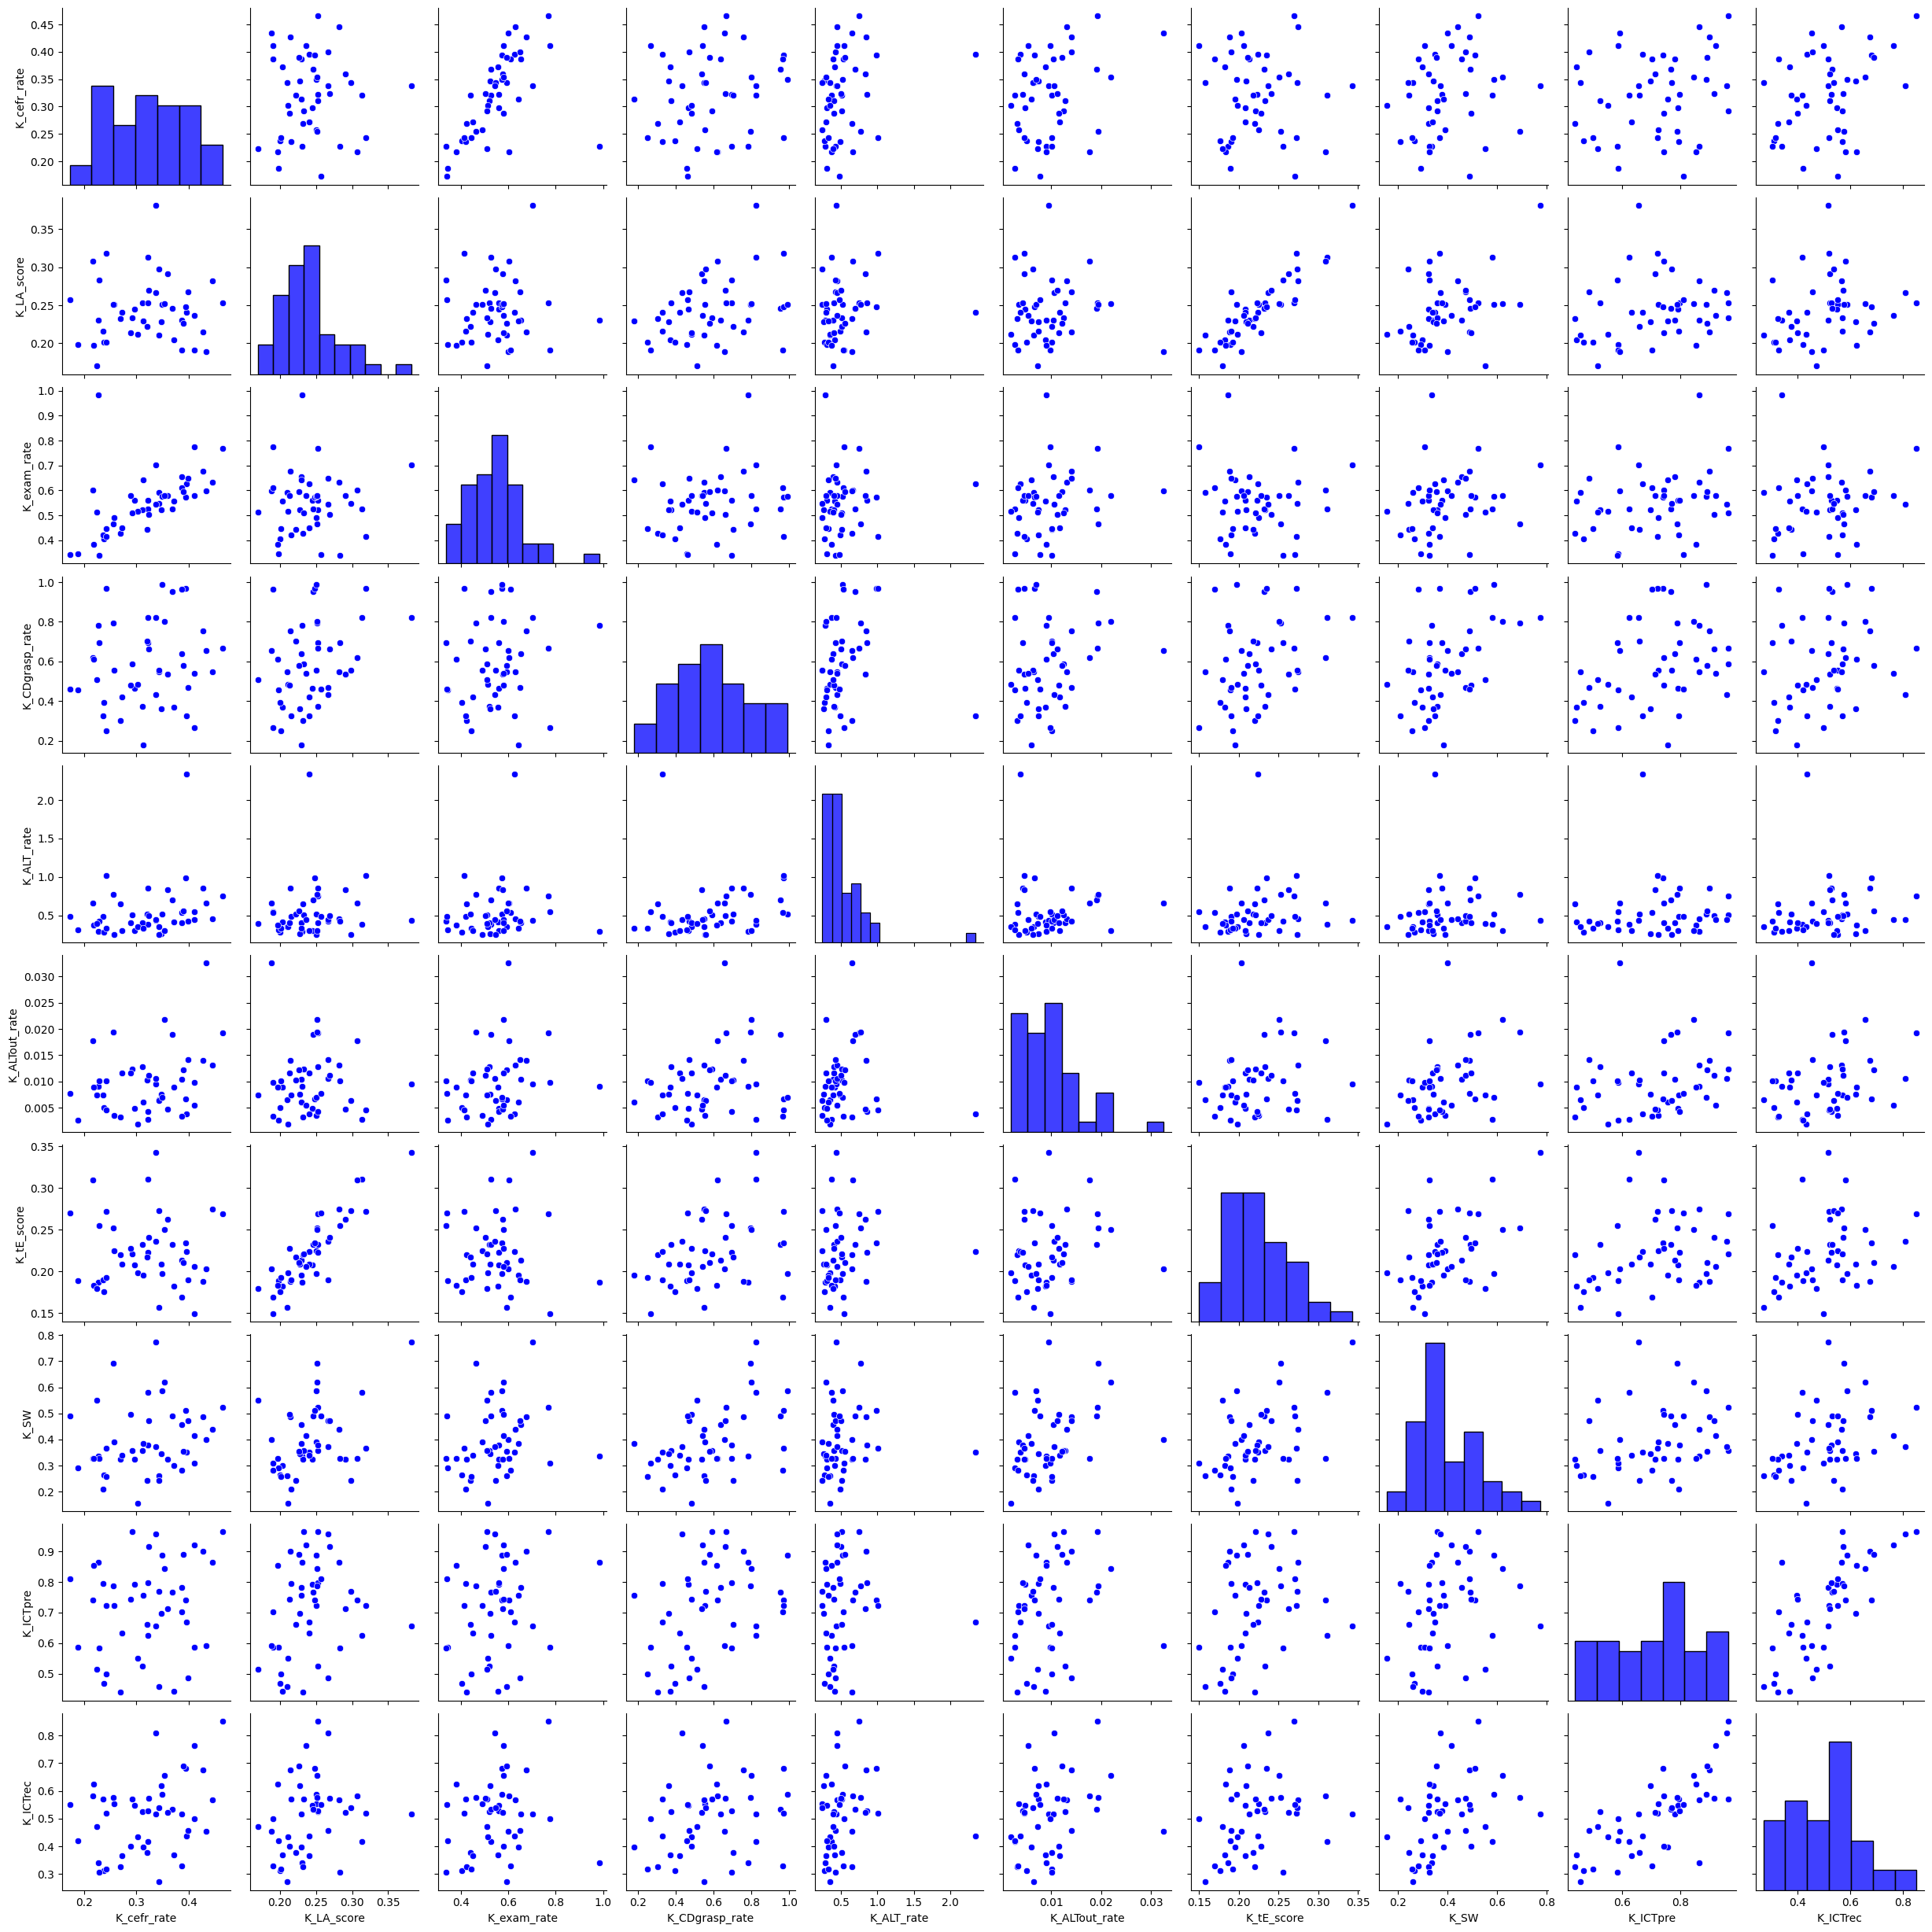

In [ ]:
# Pairplot for df_K
color2 = 'blue'
sns.pairplot(df_K, plot_kws={'color': color2}, diag_kws={'color': color2})


### df_C x df_K

<ipython-input-53-6266176849b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['Source'] = 'C'
<ipython-input-53-6266176849b3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_K['Source'] = 'K'


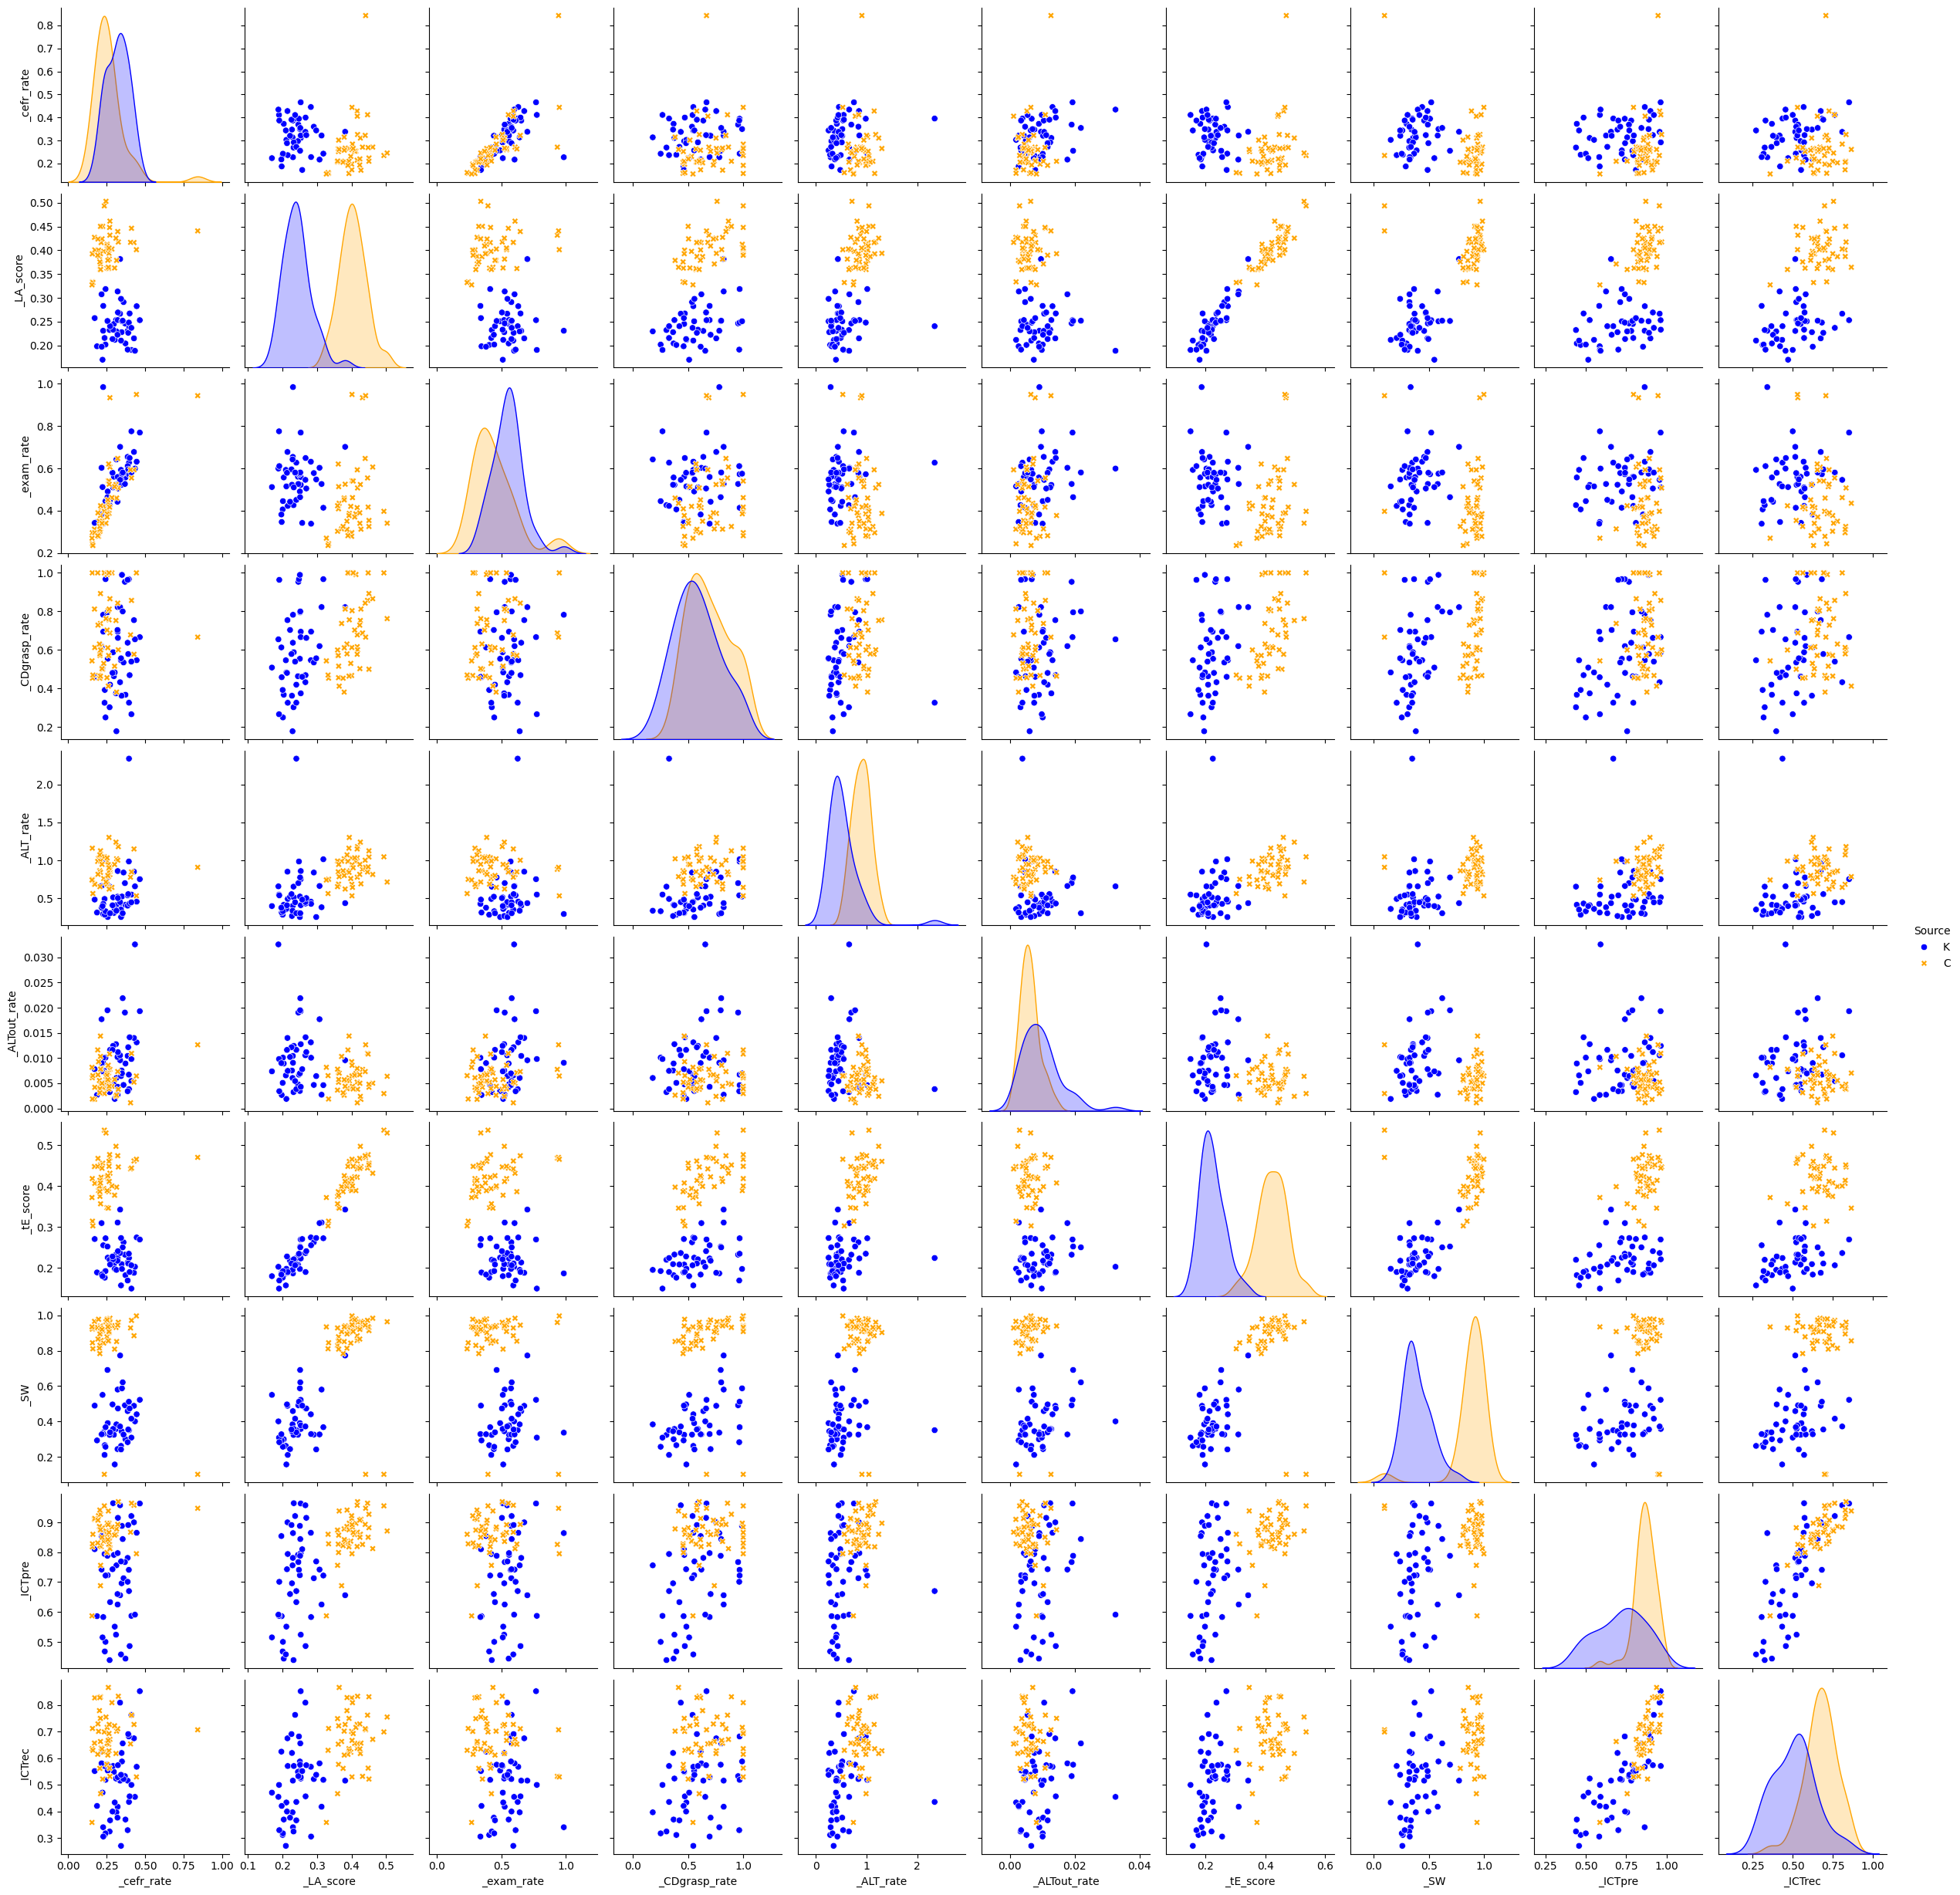

In [ ]:
# Rename columns to remove the prefixes
df_C.columns = df_C.columns.str[1:]
df_K.columns = df_K.columns.str[1:]

# Add a 'Source' column to each DataFrame
df_C['Source'] = 'C'
df_K['Source'] = 'K'

# Combine the DataFrames
df_combined = pd.concat([df_K, df_C], ignore_index=True)
# markers = {'K': 'o', 'C': 'X'}
sns.pairplot(df_combined, hue='Source', palette={'C': 'orange', 'K': 'blue'}, markers=['o', 'X'])


### cefr_rate, LA_score(後の回帰分析で目的変数となる変数) x SSDSE

<ipython-input-55-2170c4f7f145>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['log_C_cefr_rate'] = np.log(df_C['C_cefr_rate']) # Ensure the log transformation for df_C


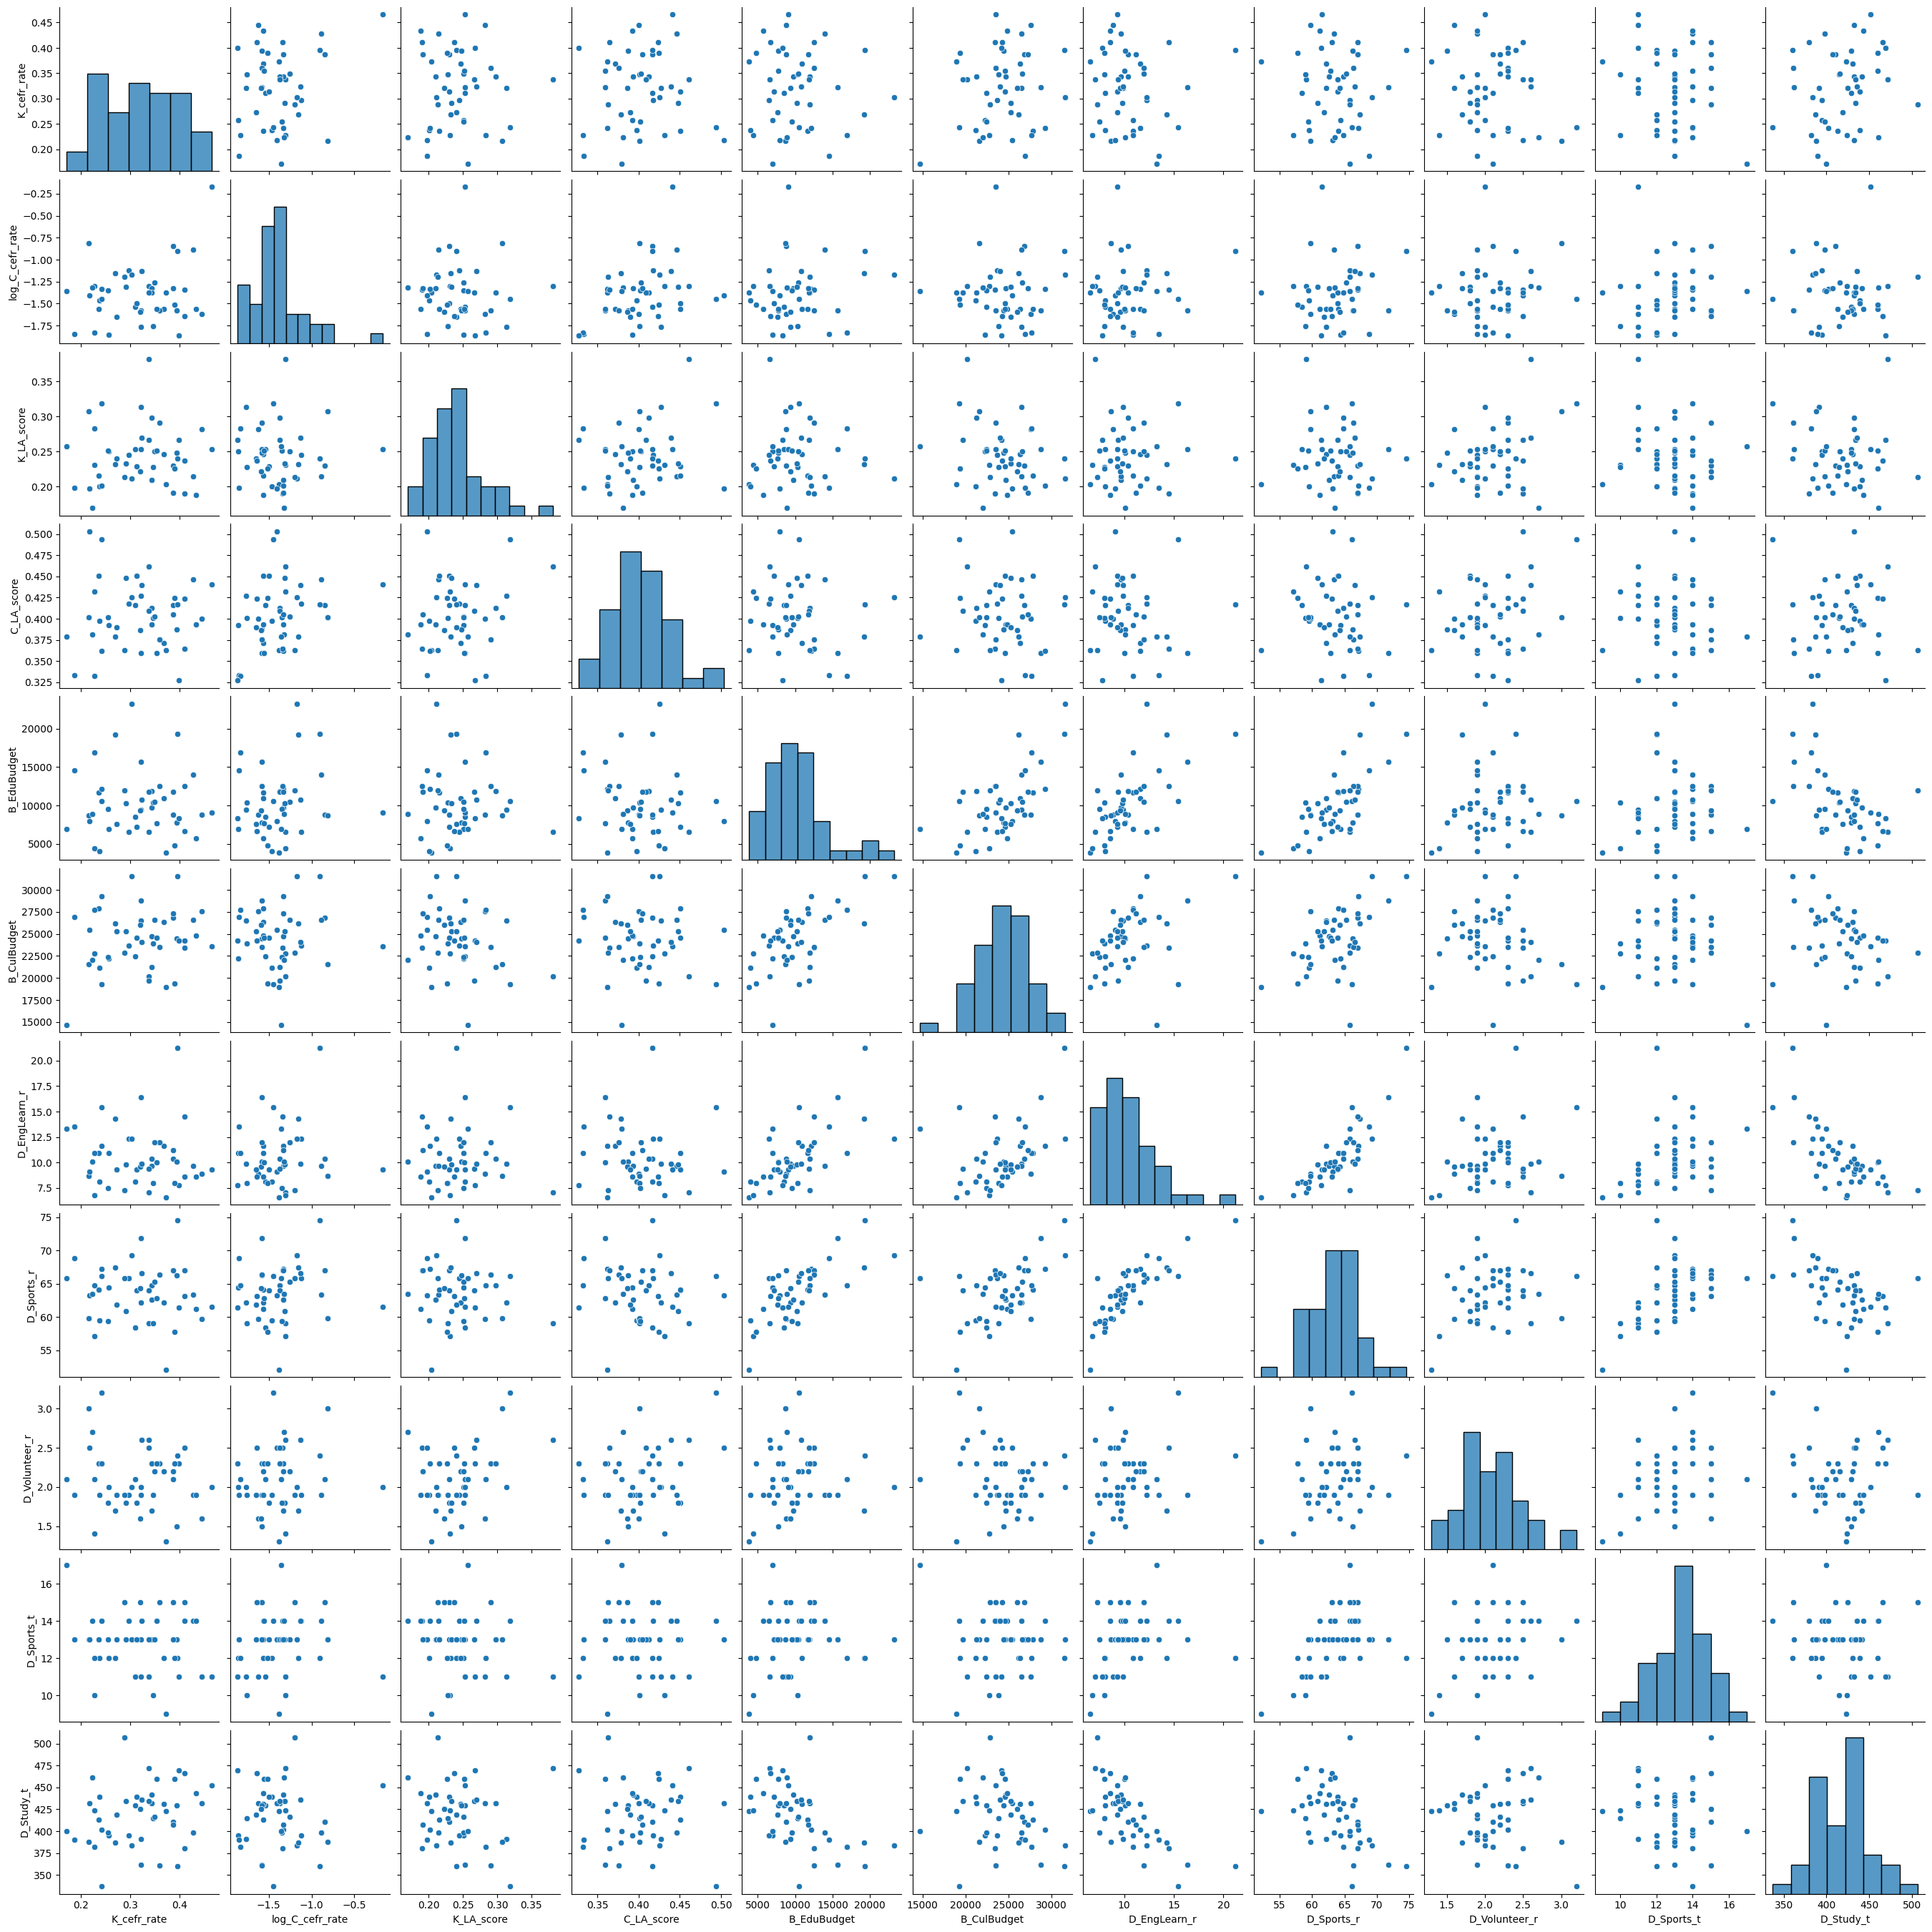

In [ ]:
# Reset df_C & df_K
df_C = df_1.filter(regex='^C_')
df_C['log_C_cefr_rate'] = np.log(df_C['C_cefr_rate']) # Ensure the log transformation for df_C
df_K = df_1.filter(regex='^K_')

df_2_Eng = pd.concat([df_K['K_cefr_rate'], df_C['log_C_cefr_rate'], df_K['K_LA_score'], df_C['C_LA_score'], df_2], axis=1)
# df_2_Eng.head()
sns.pairplot(df_2_Eng)

In [ ]:
correlation = df_2_Eng['D_Sports_r'].corr(df_2_Eng['D_EngLearn_r'])
print(correlation)

0.8313782052672287


**D_EngLearn_r**と**D_Sports_r**の間に強い相関がある。これ自体興味深いが、回帰モデルの説明変数とする際にはVIFが懸念されるため、より関連性の強い**D_EngLearn_r**のみを用いる。

## 2.2 Anomaly Detection

### cefr_rate

<ipython-input-58-e9e7acd9c255>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(df_C_sorted.index, rotation=90)
<ipython-input-58-e9e7acd9c255>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(df_K_sorted.index, rotation=90)


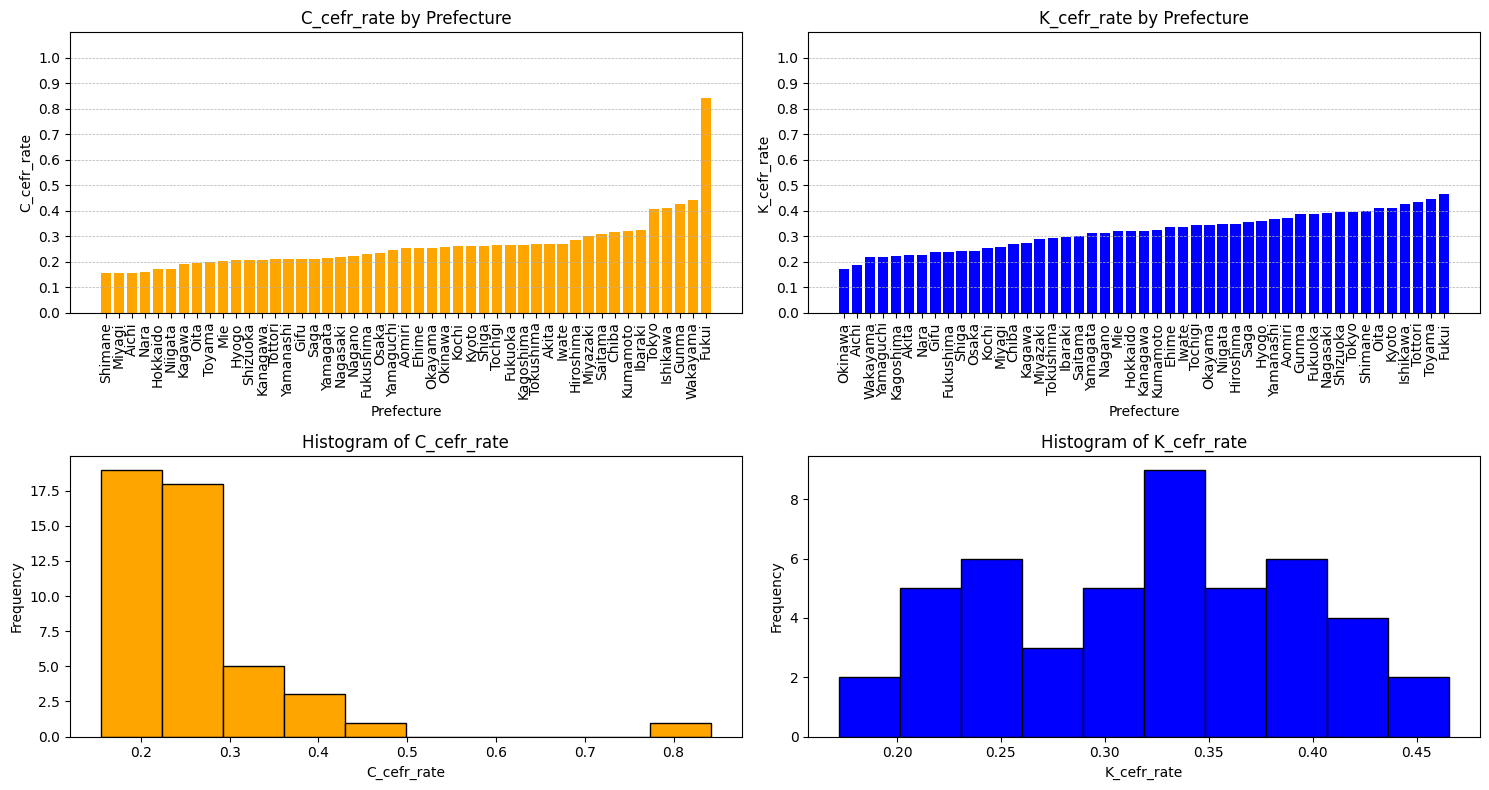

In [ ]:
# Recreating df_C and df_K
df_C = df_1.filter(regex='^C_')  # left
df_K = df_1.filter(regex='^K_')  # right

# Sorting the DataFrame by the target column in ascending order
df_C_sorted = df_C.sort_values(by='C_cefr_rate')
df_K_sorted = df_K.sort_values(by='K_cefr_rate')

# Titles
X_label = 'Prefecture'
Y_label_C = 'C_cefr_rate'
Y_label_K = 'K_cefr_rate'
Title_C = 'C_cefr_rate by Prefecture'
Title_K = 'K_cefr_rate by Prefecture'

# Creating the bar graphs and histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

# Plotting the first bar chart (df_C)
axes[0, 0].bar(df_C_sorted.index, df_C_sorted['C_cefr_rate'], color='orange')
axes[0, 0].set_xlabel(X_label)
axes[0, 0].set_ylabel(Y_label_C)
axes[0, 0].set_title(Title_C)
axes[0, 0].set_xticklabels(df_C_sorted.index, rotation=90)
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0, 0].grid(axis='y', which='both', linestyle='--', linewidth=0.5)

# Plotting the second bar chart (df_K)
axes[0, 1].bar(df_K_sorted.index, df_K_sorted['K_cefr_rate'], color='blue')
axes[0, 1].set_xlabel(X_label)
axes[0, 1].set_ylabel(Y_label_K)
axes[0, 1].set_title(Title_K)
axes[0, 1].set_xticklabels(df_K_sorted.index, rotation=90)
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].set_yticks(np.arange(0, 1.1, 0.1))
axes[0, 1].grid(axis='y', which='both', linestyle='--', linewidth=0.5)

# Plotting the histogram for C_cefr_rate
axes[1, 0].hist(df_C_sorted['C_cefr_rate'], bins=10, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('C_cefr_rate')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of C_cefr_rate')

# Plotting the histogram for K_cefr_rate
axes[1, 1].hist(df_K_sorted['K_cefr_rate'], bins=10, color='blue', edgecolor='black')
axes[1, 1].set_xlabel('K_cefr_rate')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of K_cefr_rate')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# summary of cefr_rate
describe_C = df_C['C_cefr_rate'].describe()
describe_K = df_K['K_cefr_rate'].describe()

combined_describe = pd.DataFrame({
    'C_cefr_rate': describe_C,
    'K_cefr_rate': describe_K})

print(combined_describe)

       C_cefr_rate  K_cefr_rate
count    47.000000    47.000000
mean      0.263460     0.319963
std       0.110451     0.073602
min       0.154547     0.172001
25%       0.206067     0.256082
50%       0.252135     0.321783
75%       0.271093     0.379423
max       0.842515     0.465742


高校生のcefr_rateの分布には対称性があるが、中学生のcefr_rateは偏っている。\
後の回帰分析において望ましい誤差構造を持たせるため、**C_cefr_rateのみ対数変換**し、正規分布に近づける。\
また中学生のcefr_rateに関して福井県が外れ値(84.3%)となっている。後の回帰分析における目的変数であるため、**除外する**。

<ipython-input-60-83950b1544d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['log_C_cefr_rate'] = np.log(df_C['C_cefr_rate'])


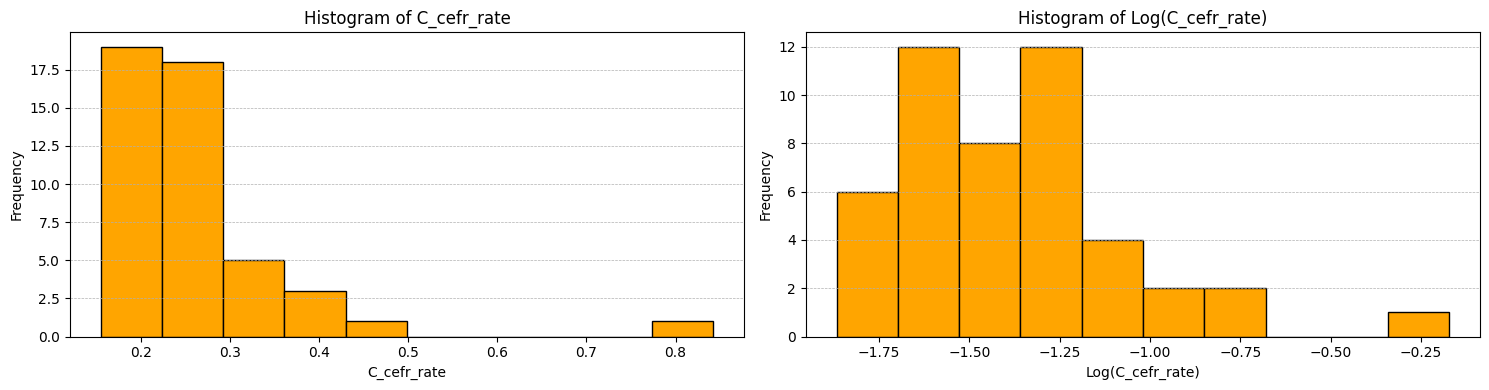

In [ ]:
# Recreating df_C
df_C = df_1.filter(regex='^C_')
# Apply logarithm transformation to C_cefr_rate
df_C['log_C_cefr_rate'] = np.log(df_C['C_cefr_rate'])

# Creating the histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Plotting the histogram for original C_cefr_rate
axes[0].hist(df_C['C_cefr_rate'], bins=10, color='orange', edgecolor='black')
axes[0].set_xlabel('C_cefr_rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of C_cefr_rate')
axes[0].grid(axis='y', linestyle='--', linewidth=0.5)

# Plotting the histogram for log-transformed C_cefr_rate
axes[1].hist(df_C['log_C_cefr_rate'], bins=10, color='orange', edgecolor='black')
axes[1].set_xlabel('Log(C_cefr_rate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Log(C_cefr_rate)')
axes[1].grid(axis='y', linestyle='--', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

### LA_score

<ipython-input-61-863b9b42108c>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(df_C_sorted.index, rotation=90)
<ipython-input-61-863b9b42108c>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(df_K_sorted.index, rotation=90)


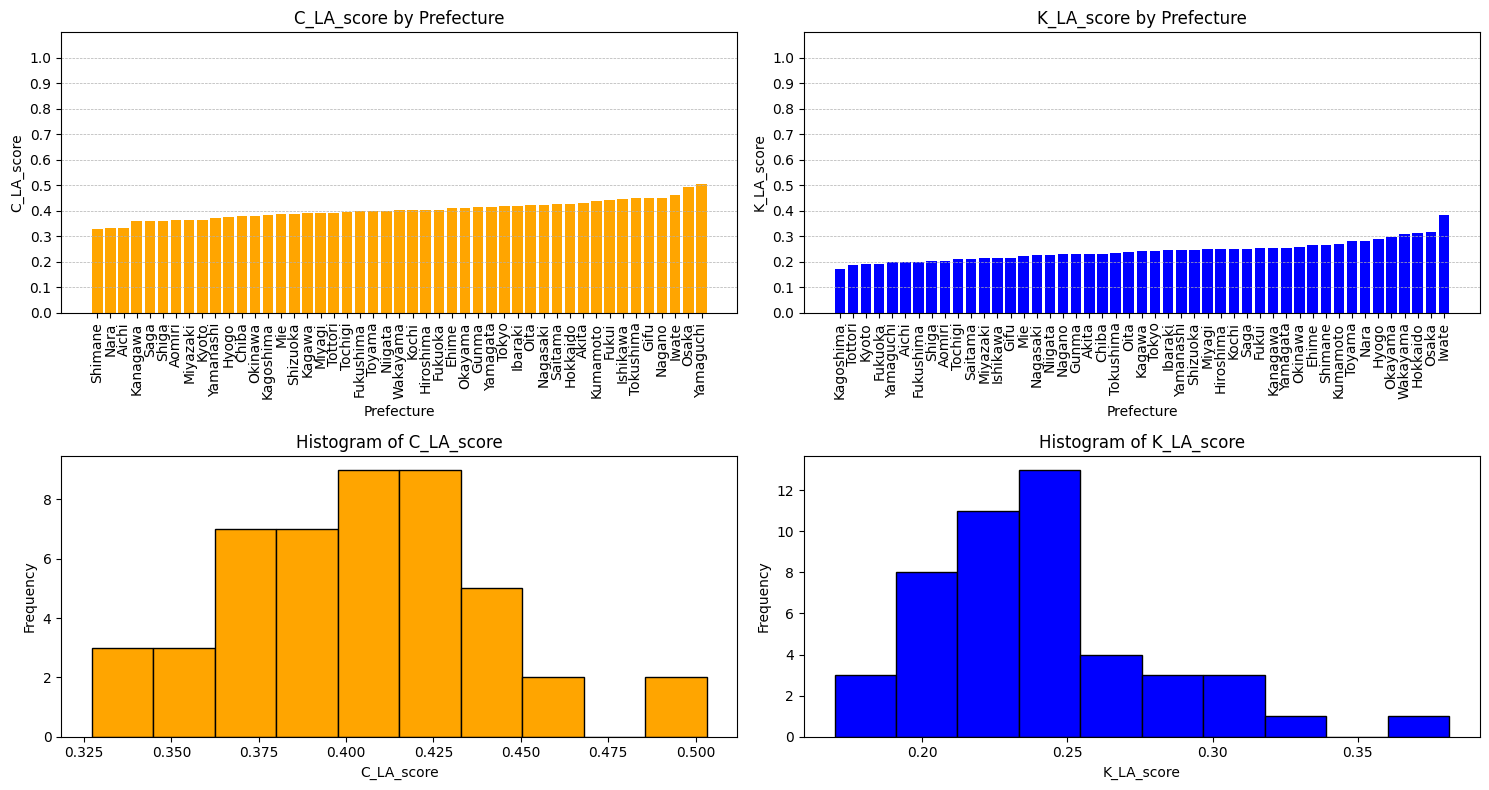

In [ ]:
# Recreating df_C and df_K
df_C = df_1.filter(regex='^C_')  # left
df_K = df_1.filter(regex='^K_')  # right

# Sorting the DataFrame by the target column in ascending order
df_C_sorted = df_C.sort_values(by='C_LA_score')
df_K_sorted = df_K.sort_values(by='K_LA_score')

# Titles
X_label = 'Prefecture'
Y_label_C = 'C_LA_score'
Y_label_K = 'K_LA_score'
Title_C = 'C_LA_score by Prefecture'
Title_K = 'K_LA_score by Prefecture'

# Creating the bar graphs and histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

# Plotting the first bar chart (df_C)
axes[0, 0].bar(df_C_sorted.index, df_C_sorted['C_LA_score'], color='orange')
axes[0, 0].set_xlabel(X_label)
axes[0, 0].set_ylabel(Y_label_C)
axes[0, 0].set_title(Title_C)
axes[0, 0].set_xticklabels(df_C_sorted.index, rotation=90)
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0, 0].grid(axis='y', which='both', linestyle='--', linewidth=0.5)

# Plotting the second bar chart (df_K)
axes[0, 1].bar(df_K_sorted.index, df_K_sorted['K_LA_score'], color='blue')
axes[0, 1].set_xlabel(X_label)
axes[0, 1].set_ylabel(Y_label_K)
axes[0, 1].set_title(Title_K)
axes[0, 1].set_xticklabels(df_K_sorted.index, rotation=90)
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].set_yticks(np.arange(0, 1.1, 0.1))
axes[0, 1].grid(axis='y', which='both', linestyle='--', linewidth=0.5)

# Plotting the histogram for C_LA_score
axes[1, 0].hist(df_C_sorted['C_LA_score'], bins=10, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('C_LA_score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of C_LA_score')

# Plotting the histogram for K_LA_score
axes[1, 1].hist(df_K_sorted['K_LA_score'], bins=10, color='blue', edgecolor='black')
axes[1, 1].set_xlabel('K_LA_score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of K_LA_score')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# summary of ALT_rate
describe_C = df_C['C_LA_score'].describe()
describe_K = df_K['K_LA_score'].describe()

combined_describe = pd.DataFrame({
    'C_LA_score': describe_C,
    'K_LA_score': describe_K})

print(combined_describe)

       C_LA_score  K_LA_score
count   47.000000   47.000000
mean     0.403387    0.242421
std      0.038089    0.040196
min      0.327300    0.169700
25%      0.378950    0.214000
50%      0.401400    0.240300
75%      0.424900    0.255300
max      0.503200    0.381600


LA_scoreについては中高ともにほぼ正規分布となっており、外れ値もないため、このまま標準化して回帰分析に用いる。

### Other variables

<ipython-input-63-5c4bf9410a84>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_C_sorted.index, rotation=90)
<ipython-input-63-5c4bf9410a84>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_K_sorted.index, rotation=90)


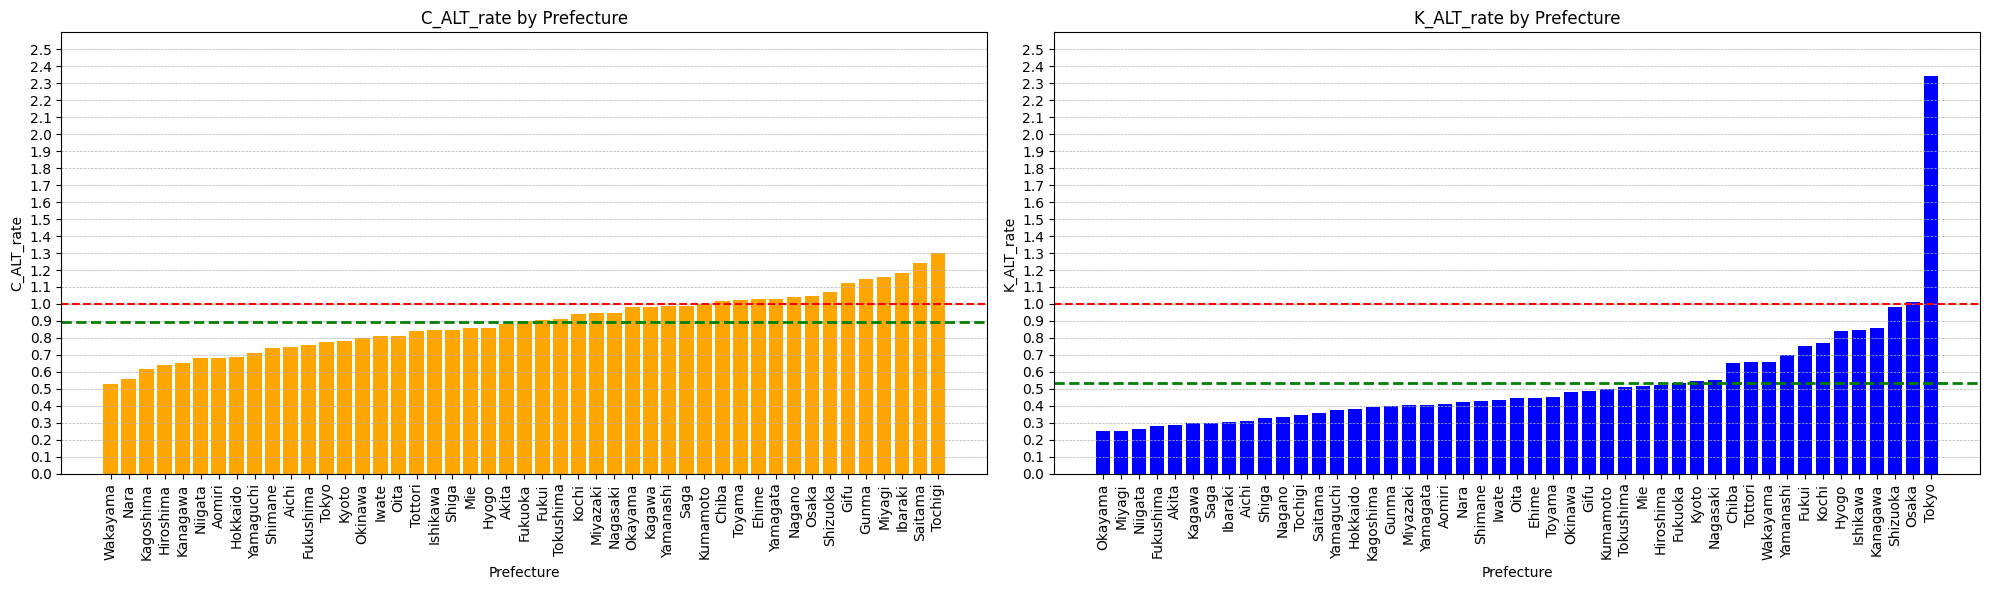

In [ ]:
# Recreating df_C and df_K
df_C = df_1.filter(regex='^C_')  # left
df_K = df_1.filter(regex='^K_')  # right

# Sorting the DataFrame by the target column in ascending order
df_C_sorted = df_C.sort_values(by='C_ALT_rate')
df_K_sorted = df_K.sort_values(by='K_ALT_rate')

# Titles
X_label = 'Prefecture'
Y_label_C = 'C_ALT_rate'
Y_label_K = 'K_ALT_rate'
Title_C = 'C_ALT_rate by Prefecture'
Title_K = 'K_ALT_rate by Prefecture'

# Creating the bar graphs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting the first bar chart (df_C)
axes[0].bar(df_C_sorted.index, df_C_sorted['C_ALT_rate'], color='orange')
axes[0].set_xlabel(X_label)
axes[0].set_ylabel(Y_label_C)
axes[0].set_title(Title_C)
axes[0].set_xticklabels(df_C_sorted.index, rotation=90)
axes[0].set_ylim(0, 2.6)
axes[0].set_yticks(np.arange(0, 2.6, 0.1))
axes[0].grid(axis='y', which='both', linestyle='--', linewidth=0.5)
axes[0].axhline(y=1, color='red', linestyle='--')  # Adding red dashed line at y=1

mean_C = df_C_sorted['C_ALT_rate'].mean()
axes[0].axhline(mean_C, color='green', linestyle='--', linewidth=2)

# Plotting the second bar chart (df_K)
axes[1].bar(df_K_sorted.index, df_K_sorted['K_ALT_rate'], color='blue')
axes[1].set_xlabel(X_label)
axes[1].set_ylabel(Y_label_K)
axes[1].set_title(Title_K)
axes[1].set_xticklabels(df_K_sorted.index, rotation=90)
axes[1].set_ylim(0, 2.6)
axes[1].set_yticks(np.arange(0, 2.6, 0.1))
axes[1].grid(axis='y', which='both', linestyle='--', linewidth=0.5)
axes[1].axhline(y=1, color='red', linestyle='--')  # Adding red dashed line at y=1

mean_K = df_K_sorted['K_ALT_rate'].mean()
axes[1].axhline(mean_K, color='green', linestyle='--', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# summary of ALT_rate
describe_C = df_C['C_ALT_rate'].describe()
describe_K = df_K['K_ALT_rate'].describe()

combined_describe = pd.DataFrame({
    'C_ALT_rate': describe_C,
    'K_ALT_rate': describe_K})

print(combined_describe)

       C_ALT_rate  K_ALT_rate
count   47.000000   47.000000
mean     0.894631    0.532741
std      0.179567    0.332602
min      0.529915    0.250000
25%      0.767333    0.352990
50%      0.900990    0.444444
75%      1.022602    0.602030
max      1.301282    2.341969


<ipython-input-65-1c9d76f5a4a1>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_C_sorted.index, rotation=90)
<ipython-input-65-1c9d76f5a4a1>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_K_sorted.index, rotation=90)


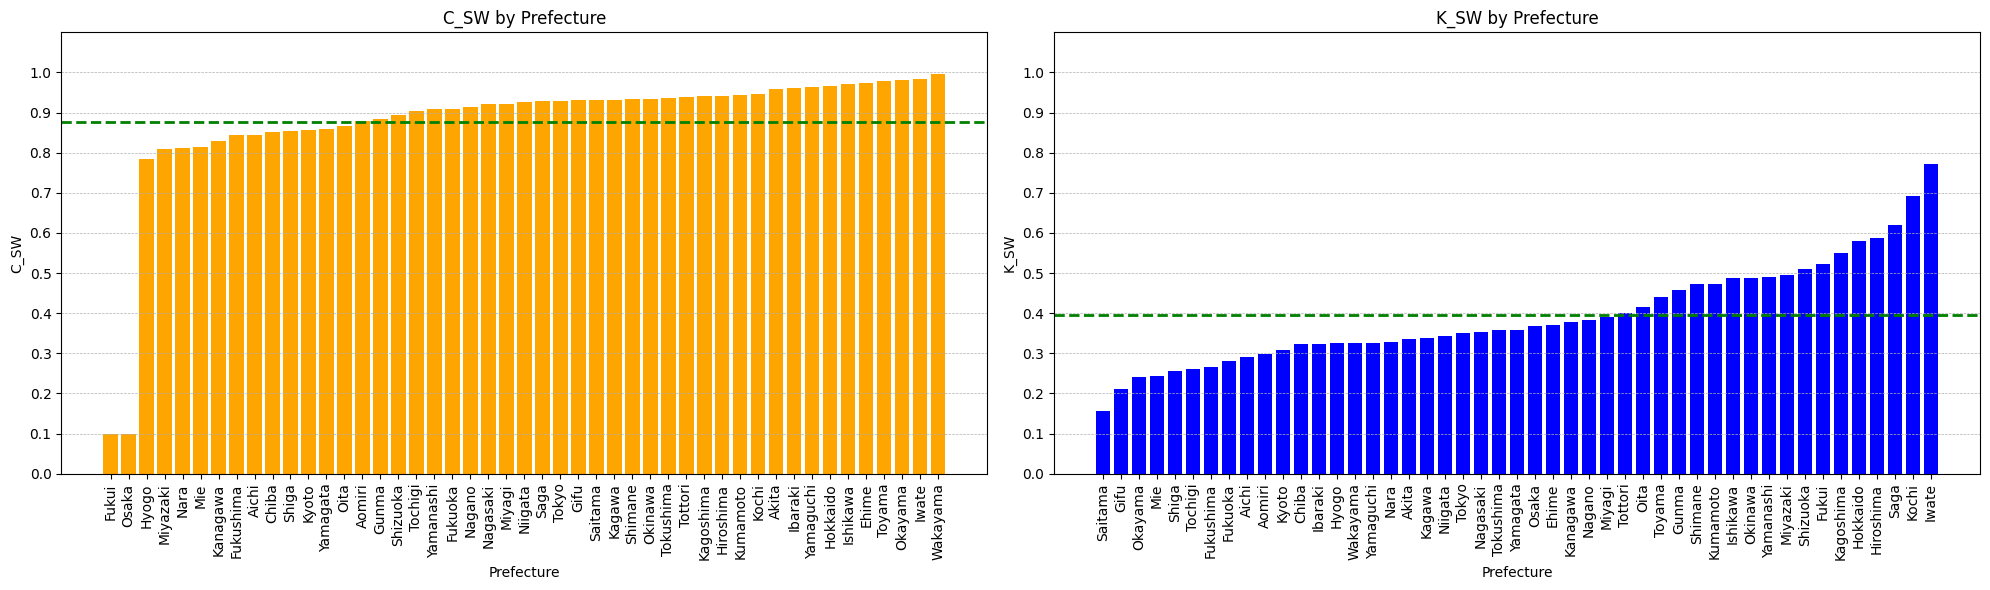

In [ ]:
# Recreating df_C and df_K
df_C = df_1.filter(regex='^C_')  # left
df_K = df_1.filter(regex='^K_')  # right

# Sorting the DataFrame by the target column in ascending order
df_C_sorted = df_C.sort_values(by='C_SW')
df_K_sorted = df_K.sort_values(by='K_SW')

# Titles
X_label = 'Prefecture'
Y_label_C = 'C_SW'
Y_label_K = 'K_SW'
Title_C = 'C_SW by Prefecture'
Title_K = 'K_SW by Prefecture'

# Creating the bar graphs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting the first bar chart (df_C)
axes[0].bar(df_C_sorted.index, df_C_sorted['C_SW'], color='orange')
axes[0].set_xlabel(X_label)
axes[0].set_ylabel(Y_label_C)
axes[0].set_title(Title_C)
axes[0].set_xticklabels(df_C_sorted.index, rotation=90)
axes[0].set_ylim(0, 1.1)
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].grid(axis='y', which='both', linestyle='--', linewidth=0.5)

mean_C = df_C_sorted['C_SW'].mean()
axes[0].axhline(mean_C, color='green', linestyle='--', linewidth=2)

# Plotting the second bar chart (df_K)
axes[1].bar(df_K_sorted.index, df_K_sorted['K_SW'], color='blue')
axes[1].set_xlabel(X_label)
axes[1].set_ylabel(Y_label_K)
axes[1].set_title(Title_K)
axes[1].set_xticklabels(df_K_sorted.index, rotation=90)
axes[1].set_ylim(0, 1.1)
axes[1].set_yticks(np.arange(0, 1.1, 0.1))
axes[1].grid(axis='y', which='both', linestyle='--', linewidth=0.5)

mean_K = df_K_sorted['K_SW'].mean()
axes[1].axhline(mean_K, color='green', linestyle='--', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# summary of ALT_rate
describe_C = df_C['C_SW'].describe()
describe_K = df_K['K_SW'].describe()

combined_describe = pd.DataFrame({
    'C_SW': describe_C,
    'K_SW': describe_K})

print(combined_describe)

            C_SW       K_SW
count  47.000000  47.000000
mean    0.876511   0.394638
std     0.173671   0.126924
min     0.100000   0.156000
25%     0.857000   0.323500
50%     0.927000   0.357000
75%     0.943500   0.480500
max     0.997000   0.773000


<ipython-input-67-8d0d49d76ec8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_C_sorted.index, rotation=90)
<ipython-input-67-8d0d49d76ec8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_K_sorted.index, rotation=90)


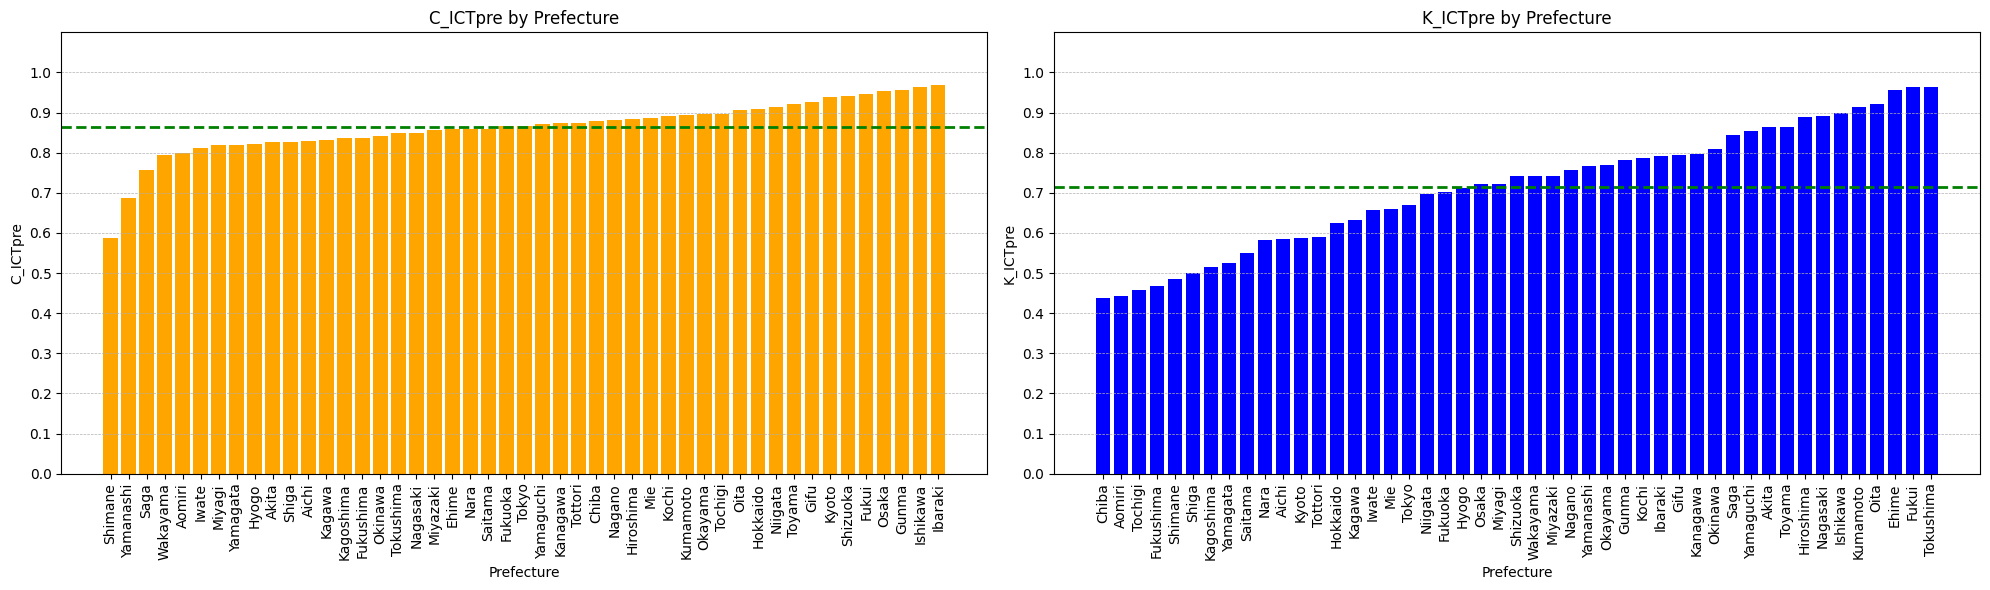

In [ ]:
# Recreating df_C and df_K
df_C = df_1.filter(regex='^C_')  # left
df_K = df_1.filter(regex='^K_')  # right

# Sorting the DataFrame by the target column in ascending order
df_C_sorted = df_C.sort_values(by='C_ICTpre')
df_K_sorted = df_K.sort_values(by='K_ICTpre')

# Titles
X_label = 'Prefecture'
Y_label_C = 'C_ICTpre'
Y_label_K = 'K_ICTpre'
Title_C = 'C_ICTpre by Prefecture'
Title_K = 'K_ICTpre by Prefecture'

# Creating the bar graphs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting the first bar chart (df_C)
axes[0].bar(df_C_sorted.index, df_C_sorted['C_ICTpre'], color='orange')
axes[0].set_xlabel(X_label)
axes[0].set_ylabel(Y_label_C)
axes[0].set_title(Title_C)
axes[0].set_xticklabels(df_C_sorted.index, rotation=90)
axes[0].set_ylim(0, 1.1)
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].grid(axis='y', which='both', linestyle='--', linewidth=0.5)

mean_C = df_C_sorted['C_ICTpre'].mean()
axes[0].axhline(mean_C, color='green', linestyle='--', linewidth=2)

# Plotting the second bar chart (df_K)
axes[1].bar(df_K_sorted.index, df_K_sorted['K_ICTpre'], color='blue')
axes[1].set_xlabel(X_label)
axes[1].set_ylabel(Y_label_K)
axes[1].set_title(Title_K)
axes[1].set_xticklabels(df_K_sorted.index, rotation=90)
axes[1].set_ylim(0, 1.1)
axes[1].set_yticks(np.arange(0, 1.1, 0.1))
axes[1].grid(axis='y', which='both', linestyle='--', linewidth=0.5)

mean_K = df_K_sorted['K_ICTpre'].mean()
axes[1].axhline(mean_K, color='green', linestyle='--', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# summary of ALT_rate
describe_C = df_C['C_ICTpre'].describe()
describe_K = df_K['K_ICTpre'].describe()

combined_describe = pd.DataFrame({
    'C_ICTpre': describe_C,
    'K_ICTpre': describe_K})

print(combined_describe)

        C_ICTpre   K_ICTpre
count  47.000000  47.000000
mean    0.863213   0.715660
std     0.069167   0.151499
min     0.587000   0.439000
25%     0.829500   0.589000
50%     0.867000   0.741000
75%     0.902000   0.827000
max     0.969000   0.964000


# 3. GAM Analysis

高校のALT_rateに関して東京が外れ値(2.34人/学科)となっている。\
中学のSWに関して福井県、大阪府が外れ値(10%)となっている。\
中学のICTpreに関して島根県、山口が平均を大きく下回っている。(外れ値と見なして差し支えない)\
ただし、これらは後の回帰分析における目的変数ではないため、今回は除外の根拠としない。

3.1 GAM: log(C_cefr_rate) \
3.2 GAM: K_cefr_rate \
3.3 GAM: C_LA_score \
3.4 GAM: K_LA_score

Basic steps
- Data Standardization
- Hyper-parameter Optimization
- Initial GAM
- Model Selection
- Prediction vs Observation Plot

In [ ]:
# Drop 'D_Sports_r' (cf.2.2 Anomaly Detection)
df_2 = df_2.drop(columns=['D_Sports_r'])
print(df_2.columns)
print(df_2.shape)

Index(['B_EduBudget', 'B_CulBudget', 'D_EngLearn_r', 'D_Volunteer_r',
       'D_Sports_t', 'D_Study_t'],
      dtype='object')
(47, 6)


## 3.1 GAM: C_cefr_rate

### ⅰ) Data Standardization

※福井県の行を除外(cf. 2.2 Anomaly Detection)

In [ ]:
# Apply logarithm transformation to C_cefr_rate
df_C = df_1.filter(regex='^C_')
df_C['C_cefr_rate'] = np.log(df_C['C_cefr_rate'])

# Set data frame to standardize
df_set = df_C
df_set = pd.concat([df_set, df_2], axis=1)

# Standardize the DataFrame
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df_set), index=df_set.index, columns=df_set.columns)

# Drop the row named "Fukui" (outlier)
df_std = df_std.drop(index='Fukui')

print(df_std.shape)
df_std.head()

(46, 16)


<ipython-input-37-654ebab8264d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['C_cefr_rate'] = np.log(df_C['C_cefr_rate'])


C_cefr_rate  C_LA_score  C_exam_rate  C_CDgrasp_rate  C_ALT_rate  \
Prefecture                                                                     
Hokkaido      -1.206254    0.634604    -0.798393        0.643044   -1.159221   
Aomiri         0.041264   -1.085078    -0.222052       -1.243427   -1.182501   
Iwate          0.274831    1.539561     0.956331        0.926049   -0.464688   
Miyagi        -1.484987   -0.286275    -0.898155        1.637352    1.488691   
Akita          0.272375    0.756681     2.914908       -0.015613   -0.078226   

            C_ALTout_rate  C_tE_score      C_SW  C_ICTpre  C_ICTrec  \
Prefecture                                                            
Hokkaido        -1.492951    0.524716  0.520853  0.683754 -0.175071   
Aomiri          -0.318980   -1.549357  0.014489 -0.938413 -0.973938   
Iwate           -0.381888    0.190054  0.625618 -0.748429 -0.035269   
Miyagi          -0.005797   -0.080567  0.264761 -0.660745 -0.384774   
Akita            0.570416    0.958536  0.485931 -0.543832 -1.423301   

            B_EduBudget  B_CulBudget  D_EngLearn_r  D_Volunteer_r  D_Sports_t  \
Prefecture                                                                      
Hokkaido      -0.184776     0.671272     -0.195654      -0.272113   -1.228159   
Aomiri        -1.579846    -1.667489     -1.404653      -2.099158   -2.540057   
Iwate         -0.893491    -1.282046     -1.221472       1.293925   -1.228159   
Miyagi        -0.797521    -0.647525      0.170710      -0.272113   -0.572211   
Akita         -1.440917    -0.486591     -1.331381      -1.838152   -1.884108   

            D_Study_t  
Prefecture             
Hokkaido    -0.817849  
Aomiri       0.139384  
Iwate        1.605148  
Miyagi      -0.698195  
Akita        0.169298

### ⅱ) Hyper-parameter Optimization

In [ ]:
# # Set the response (y) and the predictors (X)
# y = df_std['C_cefr_rate']
# X = df_std.drop(columns=['C_cefr_rate'])  # 15 variables

# # Define the model with specified settings
# # gam = GAM(
# #     s(0)+ s(1)+ s(2)+ s(3)+ s(4)+ s(5)+ s(6)+ s(7)+ s(8)+ s(9)+ s(10)+ s(11)+ s(12)+ s(13)+ s(14),
# #     distribution='normal',
# #     link='identity'
# # )

# gam = LinearGAM(s(0)+ s(1)+ s(2)+ s(3)+ s(4)+ s(5)+ s(6)+ s(7)+ s(8)+ s(9)+ s(10)+ s(11)+ s(12)+ s(13)+ s(14)).fit(X, y)

# lam = np.logspace(-3, 3, 7)
# lams = [lam] * 15

# gam.gridsearch(X, y, lam=lams)
# gam.summary()

Computationally expensive: $(p^2)^n$ calculations required

Predictor: 0, lambda: 1e-10, GCV: 2.4745610199019477
Predictor: 0, lambda: 1e-09, GCV: 2.474384507757094
Predictor: 0, lambda: 1e-08, GCV: 2.4729801421339244
Predictor: 0, lambda: 1e-07, GCV: 2.4612175222299655
Predictor: 0, lambda: 1e-06, GCV: 2.3792509331341205
Predictor: 0, lambda: 1e-05, GCV: 2.144209241913607
Predictor: 0, lambda: 0.0001, GCV: 1.8466166901213377
Predictor: 0, lambda: 0.001, GCV: 1.631817693456938
Predictor: 0, lambda: 0.01, GCV: 1.3605109065136023
Predictor: 0, lambda: 0.1, GCV: 1.05714719434041
Predictor: 0, lambda: 1.0, GCV: 0.866598989241979
Predictor: 0, lambda: 10.0, GCV: 0.7689184139518229
Predictor: 0, lambda: 100.0, GCV: 0.7096692335302155
Predictor: 0, lambda: 1000.0, GCV: 0.6984828746961596
Predictor: 0, lambda: 10000.0, GCV: 0.7072403247654556
Predictor: 0, lambda: 100000.0, GCV: 0.7087733237555813
Predictor: 0, lambda: 1000000.0, GCV: 0.7089361478119567
Predictor: 0, lambda: 10000000.0, GCV: 0.7089525296395446
Predictor: 0, lambda: 100000000.0, GCV: 0.

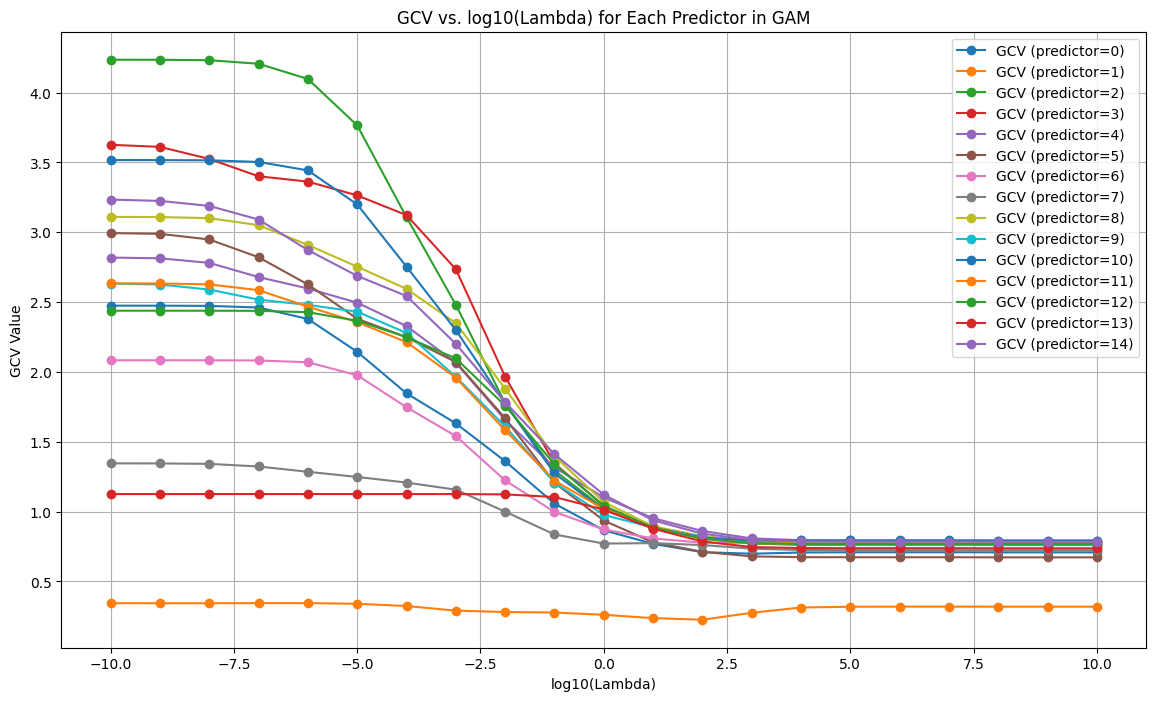

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['C_cefr_rate']
X = df_std.drop(columns=['C_cefr_rate'])  # 15 variables

# Define a range of lambda values to test
lambda_range = np.logspace(-10, 10, 21)  # Range searched for lambda

# Initialize lists to store GCV values for each predictor
gcv_values = []

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for predictor_idx in range(X.shape[1]):
    # Extract the single predictor
    X_single = X.iloc[:, [predictor_idx]]

    for lam in lambda_range:
        # Initialize lists to store the GCV values for each fold
        fold_gcv = []

        for train_index, test_index in kf.split(X_single):
            X_train, X_test = X_single.iloc[train_index], X_single.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Create the GAM model with the current lambda
            gam = LinearGAM(s(0, lam=lam)).fit(X_train, y_train)

            # Compute GCV
            gcv = gam.statistics_['GCV']
            fold_gcv.append(gcv)

        # Compute the mean GCV for the current lambda
        mean_gcv = np.mean(fold_gcv)
        gcv_values.append((predictor_idx, lam, mean_gcv))

        print(f'Predictor: {predictor_idx}, lambda: {lam}, GCV: {mean_gcv}')

# Visualize the GCV values
plt.figure(figsize=(14, 8))

for predictor_idx in range(X.shape[1]):
    gcv_plot_values = [val[2] for val in gcv_values if val[0] == predictor_idx]
    plt.plot(np.log10(lambda_range), gcv_plot_values, marker='o', linestyle='-', label=f'GCV (predictor={predictor_idx})')

plt.xlabel('log10(Lambda)')
plt.ylabel('GCV Value')
plt.title('GCV vs. log10(Lambda) for Each Predictor in GAM')

plt.legend()
plt.grid(True)
plt.show()

方針①：全ての変数について**一つずつGAMモデルに取り入れてCVを行った場合**、ほとんどの変数がλ=$10^2$~$10^3$のときに最適値を達した。しかし、このλで複数(全15)の変数を同時にモデルに組み込みスプラインを視覚化すると、明らかに不自然な信頼区間となり適切なパラメータではないことがわかった。

n_splines: 4, lambda: 0.0001, AIC: 54.029869244147974, GCV: 0.07304083004757503
n_splines: 4, lambda: 0.001, AIC: 56.439148361892684, GCV: 9.180412773736201
n_splines: 4, lambda: 0.01, AIC: 87.40978917504044, GCV: 1.0938899880270638
n_splines: 4, lambda: 0.1, AIC: 101.29685137972265, GCV: 0.44544996961486205
n_splines: 4, lambda: 1, AIC: 96.94822125990865, GCV: 0.544377449567721
n_splines: 4, lambda: 10, AIC: 96.8982157156021, GCV: 0.5572043490632386
n_splines: 4, lambda: 100, AIC: 96.8982268654605, GCV: 0.5584469070805352
n_splines: 4, lambda: 1000, AIC: 96.89827302510767, GCV: 0.5585706822470167
n_splines: 5, lambda: 0.0001, AIC: -23.917099998834477, GCV: 0.0007910764049655916
n_splines: 5, lambda: 0.001, AIC: 54.2539990222195, GCV: 0.07479602923059489
n_splines: 5, lambda: 0.01, AIC: 61.200807170921756, GCV: 1856.8019353477782
n_splines: 5, lambda: 0.1, AIC: 92.83815204798768, GCV: 0.6883443083734994
n_splines: 5, lambda: 1, AIC: 93.12915037173082, GCV: 0.48898284821662746
n_splines

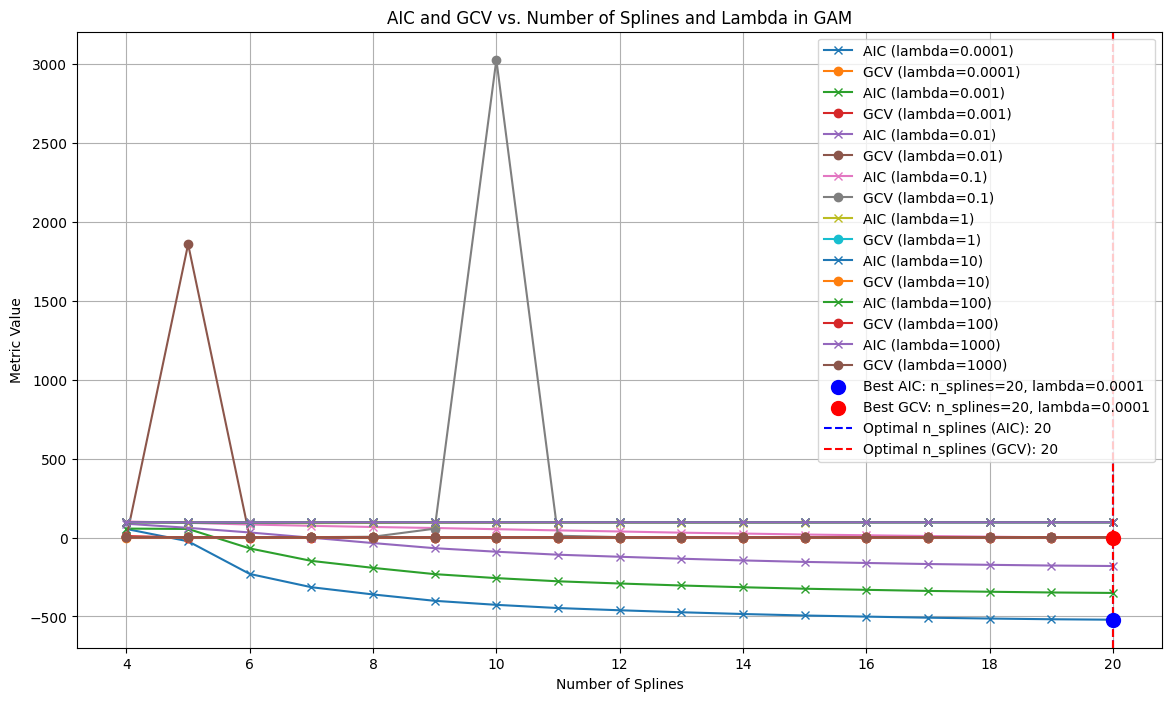

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['C_cefr_rate']
X = df_std.drop(columns=['C_cefr_rate'])  # 15 variables

# Define a range of n_splines and lambda values to test
n_splines_range = range(4, 21)
lambda_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Range searched for lambda

# Initialize lists to store AIC and GCV values
aic_values = []
gcv_values = []

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=777)

for n_splines in n_splines_range:
    for lam in lambda_range:
        # Initialize lists to store the values for each fold
        fold_aic = []
        fold_gcv = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Create the GAM model with the current number of splines and lambda
            gam = GAM(
                s(0, n_splines=n_splines, lam=lam) + s(1, n_splines=n_splines, lam=lam) + s(2, n_splines=n_splines, lam=lam) + s(3, n_splines=n_splines, lam=lam) + s(4, n_splines=n_splines, lam=lam) +
                s(5, n_splines=n_splines, lam=lam) + s(6, n_splines=n_splines, lam=lam) + s(7, n_splines=n_splines, lam=lam) + s(8, n_splines=n_splines, lam=lam) + s(9, n_splines=n_splines, lam=lam) +
                s(10, n_splines=n_splines, lam=lam) + s(11, n_splines=n_splines, lam=lam) + s(12, n_splines=n_splines, lam=lam) + s(13, n_splines=n_splines, lam=lam) + s(14, n_splines=n_splines, lam=lam),
                distribution='normal',
                link='identity',
            )

            # Fit the model
            gam.fit(X_train, y_train)

            # Compute the AIC on the test set
            aic = gam.statistics_['AIC']
            # Compute GCV
            gcv = gam.statistics_['GCV']

            fold_aic.append(aic)
            fold_gcv.append(gcv)

        # Compute the mean values for the current n_splines and lambda
        mean_aic = np.mean(fold_aic)
        mean_gcv = np.mean(fold_gcv)

        aic_values.append((n_splines, lam, mean_aic))
        gcv_values.append((n_splines, lam, mean_gcv))

        print(f'n_splines: {n_splines}, lambda: {lam}, AIC: {mean_aic}, GCV: {mean_gcv}')

# Find the n_splines and lambda values with the lowest AIC and GCV
optimal_n_splines_aic, optimal_lambda_aic = min(aic_values, key=lambda x: x[2])[:2]
optimal_n_splines_gcv, optimal_lambda_gcv = min(gcv_values, key=lambda x: x[2])[:2]

print(f'Optimal n_splines (AIC): {optimal_n_splines_aic}, Optimal lambda (AIC): {optimal_lambda_aic}')
print(f'Optimal n_splines (GCV): {optimal_n_splines_gcv}, Optimal lambda (GCV): {optimal_lambda_gcv}')

# Visualize the AIC and GCV values
plt.figure(figsize=(14, 8))

for lam in lambda_range:
    aic_plot_values = [val[2] for val in aic_values if val[1] == lam]
    gcv_plot_values = [val[2] for val in gcv_values if val[1] == lam]

    plt.plot(n_splines_range, aic_plot_values, marker='x', linestyle='-', label=f'AIC (lambda={lam})')
    plt.plot(n_splines_range, gcv_plot_values, marker='o', linestyle='-', label=f'GCV (lambda={lam})')

# Highlight the best combination
plt.scatter([optimal_n_splines_aic], [min([val[2] for val in aic_values])], color='b', s=100, zorder=5, label=f'Best AIC: n_splines={optimal_n_splines_aic}, lambda={optimal_lambda_aic}')
plt.scatter([optimal_n_splines_gcv], [min([val[2] for val in gcv_values])], color='r', s=100, zorder=5, label=f'Best GCV: n_splines={optimal_n_splines_gcv}, lambda={optimal_lambda_gcv}')

plt.xlabel('Number of Splines')
plt.ylabel('Metric Value')
plt.title('AIC and GCV vs. Number of Splines and Lambda in GAM')

plt.axvline(x=optimal_n_splines_aic, color='b', linestyle='--', label=f'Optimal n_splines (AIC): {optimal_n_splines_aic}')
plt.axvline(x=optimal_n_splines_gcv, color='r', linestyle='--', label=f'Optimal n_splines (GCV): {optimal_n_splines_gcv}')

plt.legend()
plt.grid(True)
plt.show()


n_splines: 4, lambda: 1e-06, AIC: -252.80589500047444, GCV: 3.0514120709700403e-05
n_splines: 4, lambda: 1e-05, AIC: -102.88858445017061, GCV: 0.00205584334663382
n_splines: 4, lambda: 0.0001, AIC: -7.875487249173602, GCV: 0.06287288613989979
n_splines: 4, lambda: 0.001, AIC: 52.677095196734946, GCV: 10.206418239706146
n_splines: 4, lambda: 0.01, AIC: 85.54656775945898, GCV: 1.1083301037400197
n_splines: 4, lambda: 0.1, AIC: 101.07427263222814, GCV: 0.4465125456614675
n_splines: 4, lambda: 1, AIC: 90.69645913956043, GCV: 0.6336570500706545
n_splines: 4, lambda: 10, AIC: 91.17353145101316, GCV: 0.6641691065581561
n_splines: 4, lambda: 100, AIC: 91.23399101089258, GCV: 0.6671016399560896
n_splines: 5, lambda: 1e-06, AIC: -462.82401196948695, GCV: 6.608359930254756e-08
n_splines: 5, lambda: 1e-05, AIC: -294.19680796191966, GCV: 6.511742238783851e-06
n_splines: 5, lambda: 0.0001, AIC: -129.9379124977513, GCV: 0.0006122291230706178
n_splines: 5, lambda: 0.001, AIC: 7.434305710220983, GCV: 0

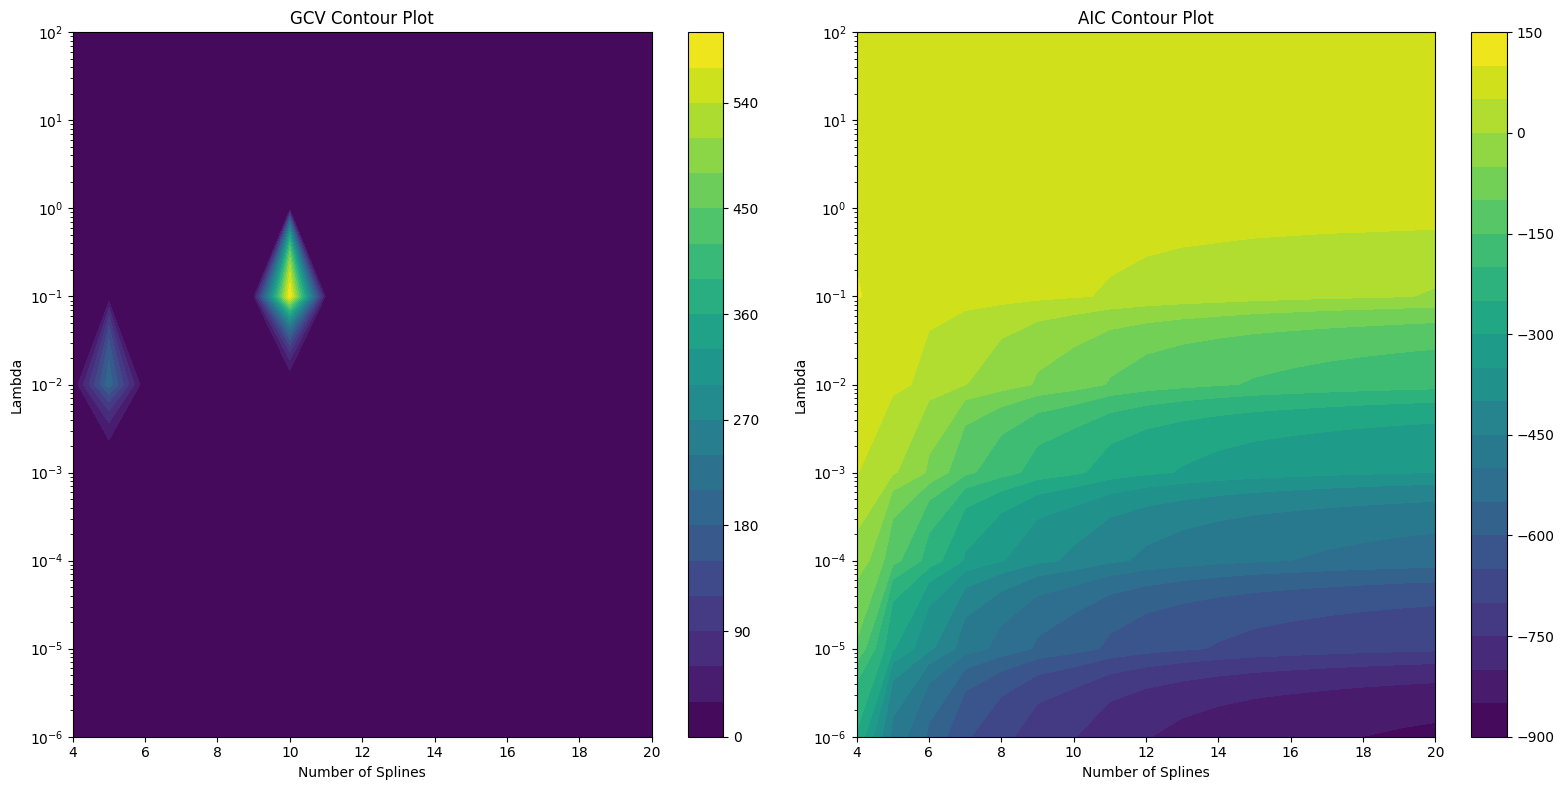

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['C_cefr_rate']
X = df_std.drop(columns=['C_cefr_rate'])  # 15 variables

# Define a range of n_splines and lambda values to test
n_splines_range = range(4, 21)
lambda_range = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # Range searched for lambda

# Initialize lists to store AIC and GCV values
aic_values = []
gcv_values = []

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for n_splines in n_splines_range:
    for lam in lambda_range:
        # Initialize lists to store the values for each fold
        fold_aic = []
        fold_gcv = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Create the GAM model with the current number of splines and lambda
            gam = GAM(
                s(0, n_splines=n_splines, lam=lam) + s(1, n_splines=n_splines, lam=lam) + s(2, n_splines=n_splines, lam=lam) + s(3, n_splines=n_splines, lam=lam) + s(4, n_splines=n_splines, lam=lam) +
                s(5, n_splines=n_splines, lam=lam) + s(6, n_splines=n_splines, lam=lam) + s(7, n_splines=n_splines, lam=lam) + s(8, n_splines=n_splines, lam=lam) + s(9, n_splines=n_splines, lam=lam) +
                s(10, n_splines=n_splines, lam=lam) + s(11, n_splines=n_splines, lam=lam) + s(12, n_splines=n_splines, lam=lam) + s(13, n_splines=n_splines, lam=lam) + s(14, n_splines=n_splines, lam=lam),
                distribution='normal',
                link='identity',
            )

            # Fit the model
            gam.fit(X_train, y_train)

            # Compute the AIC and GCV on the test set
            aic = gam.statistics_['AIC']
            gcv = gam.statistics_['GCV']

            fold_aic.append(aic)
            fold_gcv.append(gcv)

        # Compute the mean values for the current n_splines and lambda
        mean_aic = np.mean(fold_aic)
        mean_gcv = np.mean(fold_gcv)

        aic_values.append((n_splines, lam, mean_aic))
        gcv_values.append((n_splines, lam, mean_gcv))

        print(f'n_splines: {n_splines}, lambda: {lam}, AIC: {mean_aic}, GCV: {mean_gcv}')

# Convert the results to NumPy arrays for easy contour plotting
aic_values_np = np.array(aic_values)
gcv_values_np = np.array(gcv_values)

# Reshape for contour plotting
n_splines_grid_aic = aic_values_np[:, 0].reshape(len(n_splines_range), len(lambda_range))
lambda_grid_aic = aic_values_np[:, 1].reshape(len(n_splines_range), len(lambda_range))
aic_grid = aic_values_np[:, 2].reshape(len(n_splines_range), len(lambda_range))

n_splines_grid_gcv = gcv_values_np[:, 0].reshape(len(n_splines_range), len(lambda_range))
lambda_grid_gcv = gcv_values_np[:, 1].reshape(len(n_splines_range), len(lambda_range))
gcv_grid = gcv_values_np[:, 2].reshape(len(n_splines_range), len(lambda_range))

# Plot the AIC and GCV as contour plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# GCV Plot
contour_gcv = axes[0].contourf(n_splines_grid_gcv, lambda_grid_gcv, gcv_grid, cmap='viridis', levels=20)
fig.colorbar(contour_gcv, ax=axes[0])
axes[0].set_xlabel('Number of Splines')
axes[0].set_ylabel('Lambda')
axes[0].set_title('GCV Contour Plot')
axes[0].set_xscale('linear')
axes[0].set_yscale('log')

# AIC Plot
contour_aic = axes[1].contourf(n_splines_grid_aic, lambda_grid_aic, aic_grid, cmap='viridis', levels=20)
fig.colorbar(contour_aic, ax=axes[1])
axes[1].set_xlabel('Number of Splines')
axes[1].set_ylabel('Lambda')
axes[1].set_title('AIC Contour Plot')
axes[1].set_xscale('linear')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


方針②：分析対象である**15変数全てを同時に取り入れたモデルのλを参考にした場合**、GCVにはほとんど差が無く、AICはλの値が小さくなるほど比例的にモデル指標が改善されるようであった。また、n_splinesは高いほどAICが改善するようであった。しかし、以下の点にも気付いた。

- λが$10^{-3}$以下、及びn_splinesが高すぎる場合は過学習の兆候があった。
- 一部のλ=とn_splinesの組み合わせでGCVが異常な値を示している。（以降の異なる目的変数のモデルでも同様）
- n_splinesの増加に伴いAICは改善するが、n_splines=14以降、その差はほぼ無くなっている。

方針③：ここでのモデル指標（GCV, AIC）は15変数を非線形でモデルに組み込んだ時の結果であるが、以降のプロセスでさらに以下の条件を変更していくため、**上で描画したモデル指標はあくまで最適値の参考に過ぎない。**
- p値に基づく変数減少により、15変数のモデル指標ではなくなる
- 説明変数を線形・非線形のいずれで組み込むかによりモデル指標も変動する。
- なお、方針①での記述通り、各変数ごとのパラメータ最適化は諦め、全ての変数に一律のパラメータをあてがう。

**ここまでの気づきと、(ⅳ)記載の変数選択の観点を考慮して複数のパラメータの組み合わせを試行錯誤した**結果、最終的に以下の組み合わせで比較的安定したモデル性能が得られることに気付いた。

**λ=0.01, n_splines=10** \


### ⅲ) Initial GAM

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['C_cefr_rate']
X = df_std.drop(columns=['C_cefr_rate']) # 15 variables

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 10**(-2)

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + s(2, n_splines=opt_sp, lam=opt_lam) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     43.5999
Link Function:                     IdentityLink Log Likelihood:                                    72.3566
Number of Samples:                           46 AIC:                                              -55.5134
                                                AICc:                                           10110.2269
                                                GCV:                                                0.0077
                                                Scale:                                              0.0157
                                                Pseudo R-Squared:                                   0.9988
Feature Function                  Lam

<ipython-input-38-14198f47ac50>:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


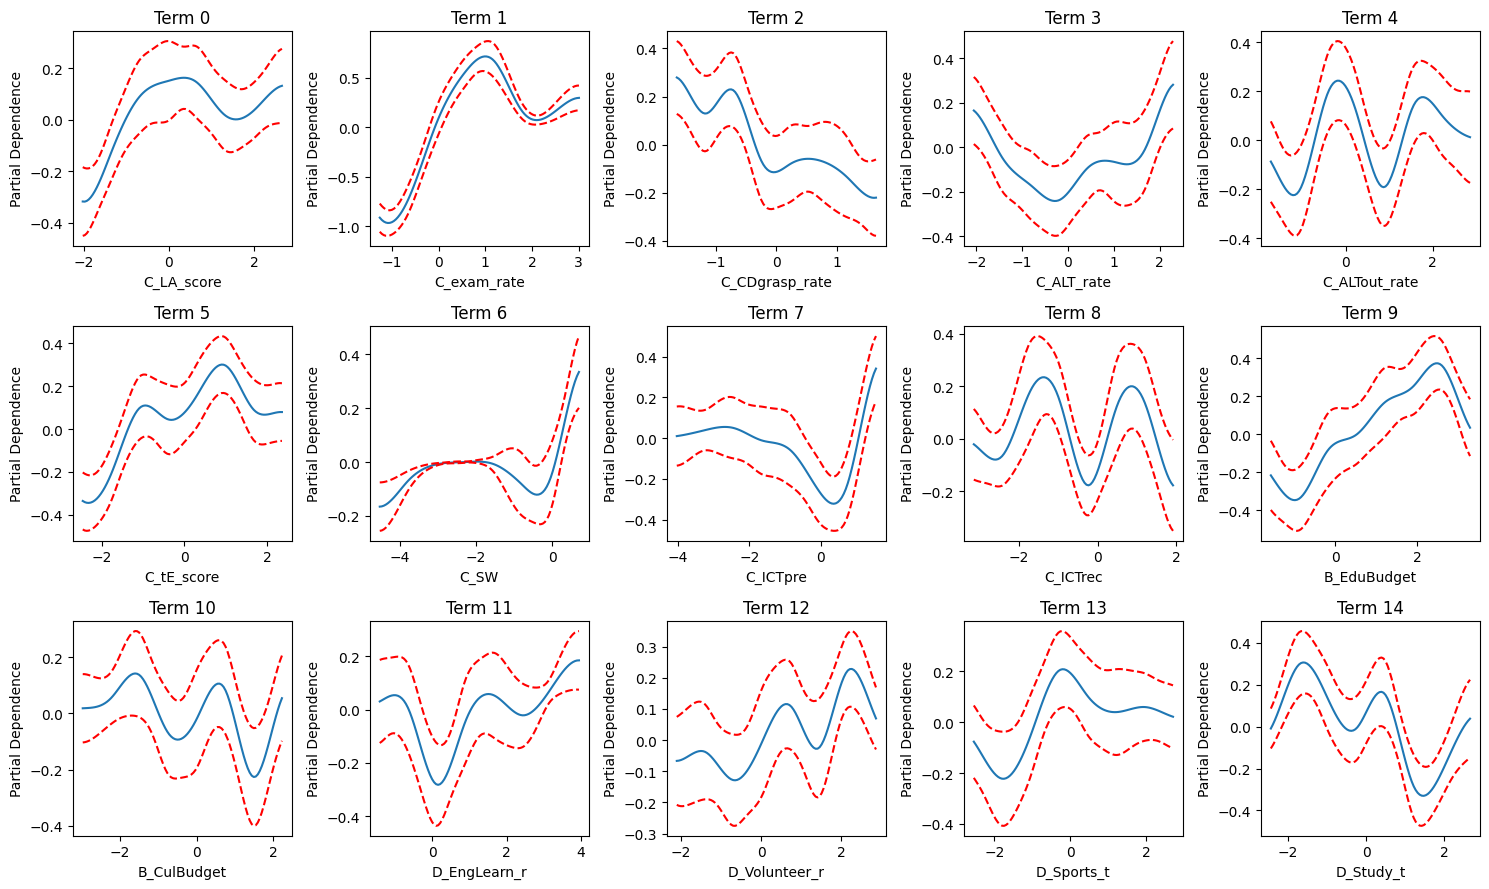

In [ ]:
# Plot the smoothing functions
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i, ax in enumerate(axs.flatten()):
    if i < len(gam.terms) - 1:
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(f'Term {i}')
        ax.set_xlabel(X.columns[i])
        ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

### ⅳ) Model Selection

**変数選択の観点**：\
・GLMにおける変数選択の方針には、p値とモデル指標に基いた機械的アルゴリズムで変数を選択する**ステップワイズ法**に加え、統計的有意性に関わらず統制変数として特定の説明変数をモデルに残したままにするケースや、交互作用を検討するケースがある。\
・GAMの変数選択過程においては、更に**各変数を非線形/線形いずれの関係で説明変数を取り込むかの選択**も要する。なお、この選択にはp値に基づく統計的有意性だけでなく、スプラインの信頼区間に基づく視覚的な判断を行うこともあるため、GLMより複雑である。ゆえにGLMで用いるようなステップワイズ法は、安定した結果に繋がらない。\
・また、上部のハイパーパラメータは15変数に対して最適化されていることを考慮すると、変数の数が減り過ぎることは望ましくない。

■よって、p値とスプラインの信頼区間の双方に基いた変数の組み合わせを試し、可能な限り多くの説明変数を残しながら、全説明変数において少なくともp<0.05レベルの統計的有意性となるような組み合わせを探索することにする。



Selecting steps \
0) Include all the variables nonlinearly \
1) i=2,7,9 linearly include \
2) i=7; exclude (C_ICTpre)\
*all significant*

*Final Model:* \
log(C_cefr_rate) ~ s('C_LA_score)+s(C_exam_rate)+**l**(C_CDgrasp_rate)+s(C_ALT_rate)+s(C_ALTout_rate)+s(C_tE_score)+s(C_SW)+s(C_ICTrec)+**l**(B_EduBudget)+s(B_CulBudget)+s(D_EngLearn_r)+s(D_Volunteer_r)+s(D_Sports_t)+s(D_Study_t)

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['C_cefr_rate']
X = df_std.drop(columns=['C_cefr_rate']) # 15 variables

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + l(2) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) + l(9) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Extract p-values
p_values = gam.statistics_['p_values']

# Get indices of the first and second largest p-values
sorted_indices = np.argsort(p_values)[-2:]  # Get last two indices (largest p-values)

# Sort the indices in descending order to get the largest first
sorted_indices = sorted_indices[::-1]

# Display the column indices and corresponding p-values
for rank, index in enumerate(sorted_indices, start=1):
    print(f"Column with the {rank} largest p-value is: {index + 1} with a p-value of {p_values[index]}")

# Print the summary of the model
print(gam.summary())

Column with the 1 largest p-value is: 15 with a p-value of 0.16581503767491812
Column with the 2 largest p-value is: 13 with a p-value of 0.048259551372218934
GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.7217
Link Function:                     IdentityLink Log Likelihood:                                    36.6104
Number of Samples:                           46 AIC:                                               12.2225
                                                AICc:                                            1651.9307
                                                GCV:                                                0.0284
                                                Scale:                                      

<ipython-input-38-dab3fa22fe44>:35: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [ ]:
# Display only the selected columns by indices
indices = [0,1,2,3,4,5,6,8,9,10,11,12,13,14] # 2, 9 linear
selected_columns = X.columns[indices]
print(selected_columns)
print("Number of selected columns:", len(selected_columns))

Index(['C_LA_score', 'C_exam_rate', 'C_CDgrasp_rate', 'C_ALT_rate',
       'C_ALTout_rate', 'C_tE_score', 'C_SW', 'C_ICTrec', 'B_EduBudget',
       'B_CulBudget', 'D_EngLearn_r', 'D_Volunteer_r', 'D_Sports_t',
       'D_Study_t'],
      dtype='object')
Number of selected columns: 14


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.7217
Link Function:                     IdentityLink Log Likelihood:                                    36.6104
Number of Samples:                           46 AIC:                                               12.2225
                                                AICc:                                            1651.9307
                                                GCV:                                                0.0284
                                                Scale:                                              0.0222
                                                Pseudo R-Squared:                                    0.997
Feature Function                  Lam

<ipython-input-40-2711cfeb17e5>:26: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


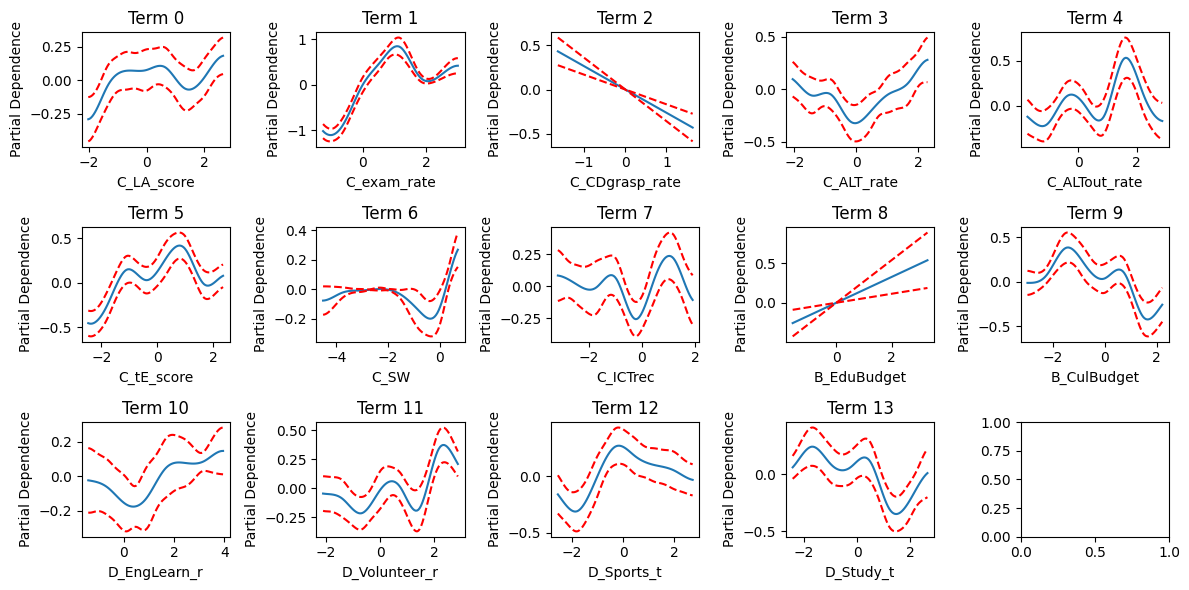

In [ ]:
# Final Model
# Set the response (y) and the predictors (X)
y = df_std['C_cefr_rate']
X = df_std[['C_LA_score', 'C_exam_rate', 'C_CDgrasp_rate', 'C_ALT_rate',
       'C_ALTout_rate', 'C_tE_score', 'C_SW', 'C_ICTrec', 'B_EduBudget',
       'B_CulBudget', 'D_EngLearn_r', 'D_Volunteer_r', 'D_Sports_t',
       'D_Study_t']]

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + l(2) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + l(8) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

###

# Plot the smoothing functions
fig, axs = plt.subplots(3, 5, figsize=(12, 6))

# Filter out intercept terms
non_intercept_terms = [i for i, term in enumerate(gam.terms) if not term.isintercept]

for ax, term_index in zip(axs.flatten(), non_intercept_terms):
    XX = gam.generate_X_grid(term=term_index)
    pdep, confi = gam.partial_dependence(term=term_index, width=0.95)
    ax.plot(XX[:, term_index], pdep)
    ax.plot(XX[:, term_index], confi, c='r', ls='--')
    ax.set_title(f'Term {term_index}')
    ax.set_xlabel(X.columns[term_index])
    ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

### ⅴ) Prediction vs Observation Plot

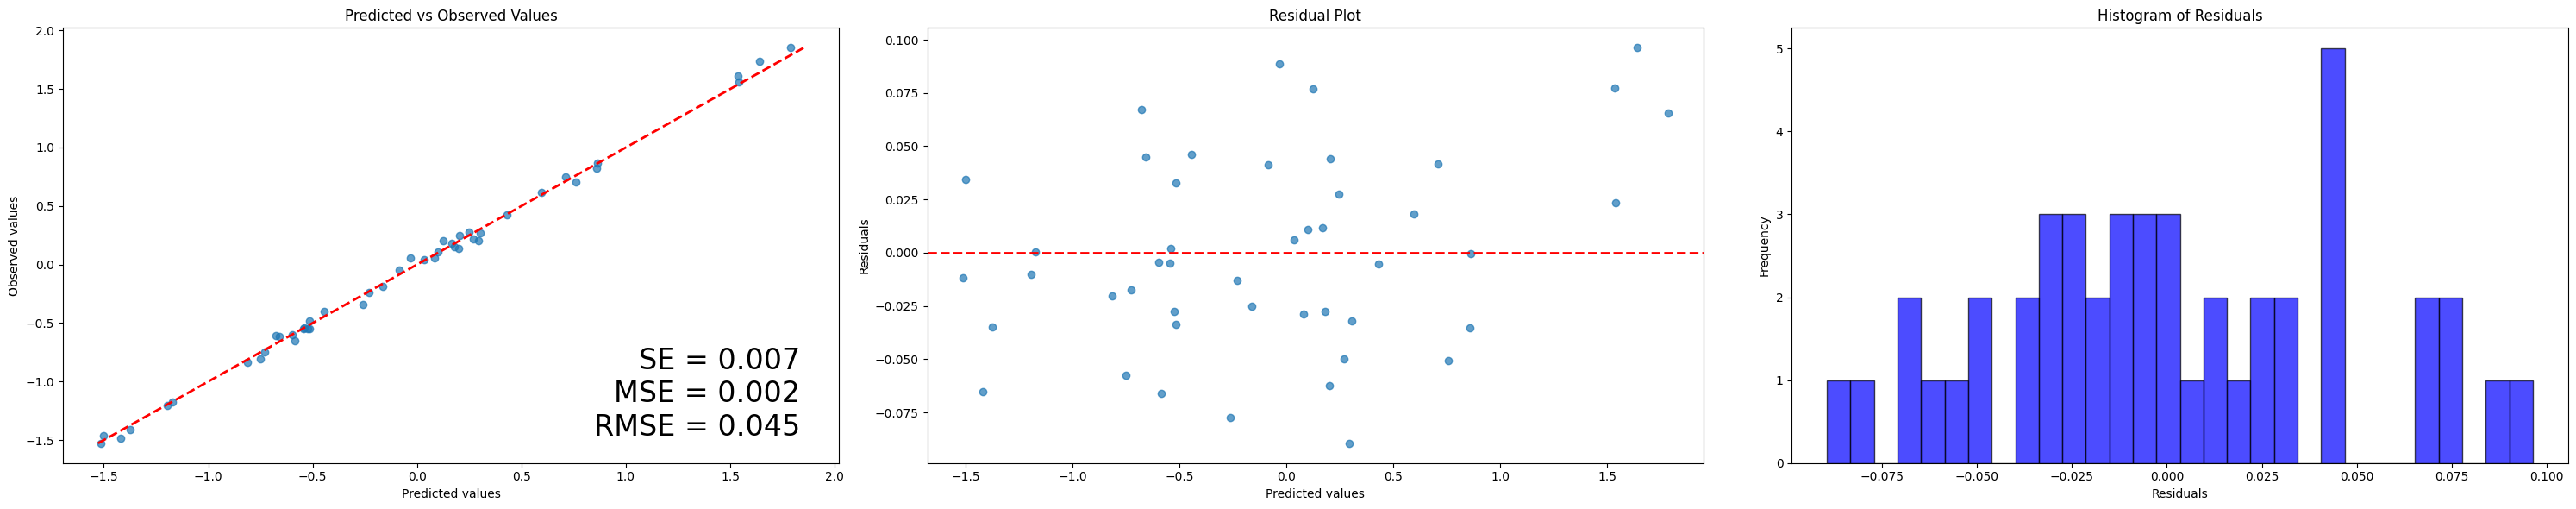

In [ ]:
# Make predictions
y_pred = gam.predict(X)

# Calculate residuals
residuals = y - y_pred

# Calculate the standard error
std_residuals = np.std(residuals)
standard_error = std_residuals / np.sqrt(len(residuals))

# Calculate the mean squared error
mse = np.mean(residuals**2)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Create a 1 by 3 plot matrix
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))

# Plot predicted vs observed values on the first plot
axes[0].scatter(y_pred, y, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Predicted values')
axes[0].set_ylabel('Observed values')
axes[0].set_title('Predicted vs Observed Values')

# Add the standard error, MSE, and RMSE text to the predicted vs observed plot
axes[0].text(0.95, 0.05, f'SE = {standard_error:.3f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}',
             verticalalignment='bottom', horizontalalignment='right',
             transform=axes[0].transAxes,
             color='black', fontsize=24)

# Plot residuals on the second plot
axes[1].scatter(y_pred, residuals, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Plot the histogram of residuals on the third plot
axes[2].hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Histogram of Residuals')

# Adjust layout
plt.tight_layout()
plt.show()

15個の説明変数候補について非線形・線形の関係を考慮しつつ選定した結果、最終的には14変数が説明要因としてモデルに組み込まれた。予測値-観測値のプロットがほぼ対角線上に並んでおり、誤差構造はほぼ等分散とみなせる。目的変数を標準化した上でほとんどの残差が0.075以内に収まっている(RMSE=0.045)。門田(2023)の分析は二項回帰モデルであるため単純比較はできないが、モデルの誤差分布に関しては望ましい性質に近づいたといえる。

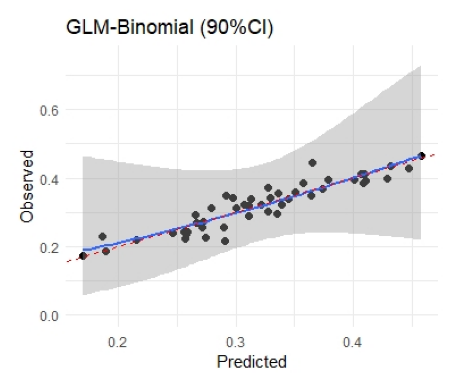

In [ ]:
# Specify the path to the image in Google Drive
image_path = '/content/drive/MyDrive/StatCompe_2024/pic_folder/Rplot_GLM_PredObs.jpeg'

# Load and display the image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## 3.2 GAM: K_cefr_rate

### ⅰ) Data Standardization

In [ ]:
# Set data frame to standardize
df_set = df_K
df_set = pd.concat([df_set, df_2], axis=1)

# Standardize the DataFrame
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df_set), index=df_set.index, columns=df_set.columns)
print(df_std.shape)
df_std.head()

(47, 16)


K_cefr_rate  K_LA_score  K_exam_rate  K_CDgrasp_rate  K_ALT_rate  \
Prefecture                                                                     
Hokkaido       0.019549    1.784888    -0.200655        1.172774   -0.467137   
Aomiri         0.719632   -0.966172     0.056903       -1.042298   -0.367660   
Iwate          0.244594    3.499900     1.272655        1.171029   -0.302111   
Miyagi        -0.865759    0.205669    -0.498048       -0.133252   -0.859279   
Akita         -1.274745   -0.294753     3.643979        0.978151   -0.738155   

            K_ALTout_rate  K_tE_score      K_SW  K_ICTpre  K_ICTrec  \
Prefecture                                                            
Hokkaido        -1.179118    2.181227  1.476209 -0.604886 -0.689855   
Aomiri          -0.124251   -0.997654 -0.761657 -1.812529 -1.050614   
Iwate           -0.014682    2.964823  3.013249 -0.398052  0.046694   
Miyagi          -1.052696    0.060325 -0.036939  0.048976  0.332295   
Akita           -0.099367   -0.888889 -0.466992  0.989736 -1.268573   

            B_EduBudget  B_CulBudget  D_EngLearn_r  D_Volunteer_r  D_Sports_t  \
Prefecture                                                                      
Hokkaido      -0.184776     0.671272     -0.195654      -0.272113   -1.228159   
Aomiri        -1.579846    -1.667489     -1.404653      -2.099158   -2.540057   
Iwate         -0.893491    -1.282046     -1.221472       1.293925   -1.228159   
Miyagi        -0.797521    -0.647525      0.170710      -0.272113   -0.572211   
Akita         -1.440917    -0.486591     -1.331381      -1.838152   -1.884108   

            D_Study_t  
Prefecture             
Hokkaido    -0.817849  
Aomiri       0.139384  
Iwate        1.605148  
Miyagi      -0.698195  
Akita        0.169298

### ⅱ) Hyper-parameter Optimization

n_splines: 4, lambda: 1e-06, AIC: -257.9055039649257, GCV: 4.5273667684701695e-05
n_splines: 4, lambda: 1e-05, AIC: -102.97751982099325, GCV: 0.0033563755274242644
n_splines: 4, lambda: 0.0001, AIC: 1.437497418340304, GCV: 0.13153860500138945
n_splines: 4, lambda: 0.001, AIC: 54.50158547240689, GCV: 20.655297715909363
n_splines: 4, lambda: 0.01, AIC: 80.95590390833809, GCV: 2.343861269539219
n_splines: 4, lambda: 0.1, AIC: 97.0056327619357, GCV: 1.0699185048893824
n_splines: 4, lambda: 1, AIC: 101.07610633565486, GCV: 0.9960361167537488
n_splines: 4, lambda: 10, AIC: 101.47306944795511, GCV: 0.9916285136755454
n_splines: 4, lambda: 100, AIC: 101.51268763331599, GCV: 0.9912091528092895
n_splines: 5, lambda: 1e-06, AIC: -487.5398441358467, GCV: 8.696608839076702e-08
n_splines: 5, lambda: 1e-05, AIC: -315.0062287195492, GCV: 8.652104444415191e-06
n_splines: 5, lambda: 0.0001, AIC: -145.31693591030415, GCV: 0.0008846182527510332
n_splines: 5, lambda: 0.001, AIC: -4.246494421083931, GCV: 0.

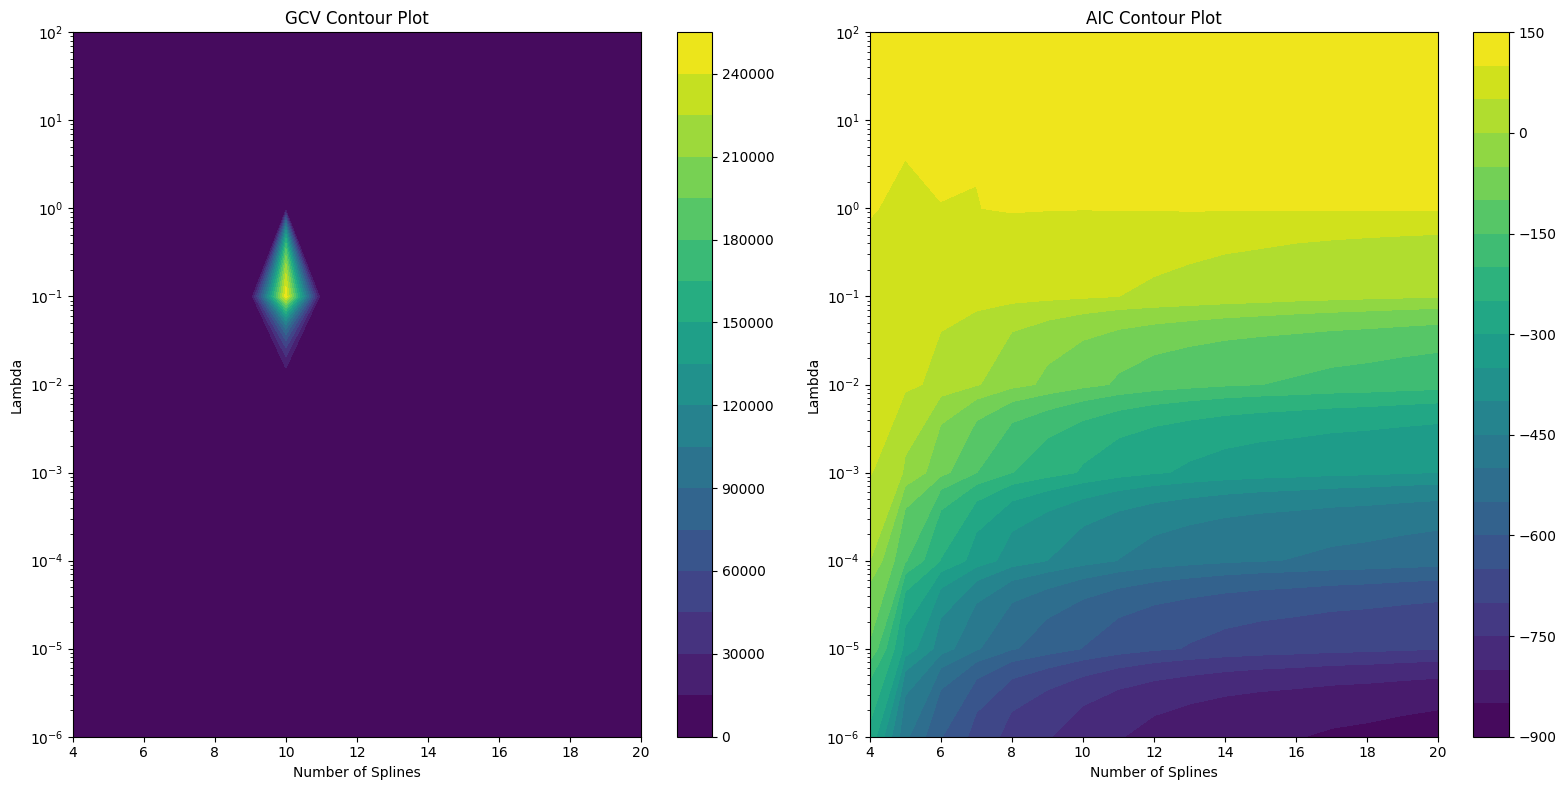

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['K_cefr_rate']
X = df_std.drop(columns=['K_cefr_rate'])  # 15 variables

# Define a range of n_splines and lambda values to test
n_splines_range = range(4, 21)
lambda_range = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # Range searched for lambda

# Initialize lists to store AIC and GCV values
aic_values = []
gcv_values = []

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for n_splines in n_splines_range:
    for lam in lambda_range:
        # Initialize lists to store the values for each fold
        fold_aic = []
        fold_gcv = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Create the GAM model with the current number of splines and lambda
            gam = GAM(
                s(0, n_splines=n_splines, lam=lam) + s(1, n_splines=n_splines, lam=lam) + s(2, n_splines=n_splines, lam=lam) + s(3, n_splines=n_splines, lam=lam) + s(4, n_splines=n_splines, lam=lam) +
                s(5, n_splines=n_splines, lam=lam) + s(6, n_splines=n_splines, lam=lam) + s(7, n_splines=n_splines, lam=lam) + s(8, n_splines=n_splines, lam=lam) + s(9, n_splines=n_splines, lam=lam) +
                s(10, n_splines=n_splines, lam=lam) + s(11, n_splines=n_splines, lam=lam) + s(12, n_splines=n_splines, lam=lam) + s(13, n_splines=n_splines, lam=lam) + s(14, n_splines=n_splines, lam=lam),
                distribution='normal',
                link='identity',
            )

            # Fit the model
            gam.fit(X_train, y_train)

            # Compute the AIC and GCV on the test set
            aic = gam.statistics_['AIC']
            gcv = gam.statistics_['GCV']

            fold_aic.append(aic)
            fold_gcv.append(gcv)

        # Compute the mean values for the current n_splines and lambda
        mean_aic = np.mean(fold_aic)
        mean_gcv = np.mean(fold_gcv)

        aic_values.append((n_splines, lam, mean_aic))
        gcv_values.append((n_splines, lam, mean_gcv))

        print(f'n_splines: {n_splines}, lambda: {lam}, AIC: {mean_aic}, GCV: {mean_gcv}')

# Convert the results to NumPy arrays for easy contour plotting
aic_values_np = np.array(aic_values)
gcv_values_np = np.array(gcv_values)

# Reshape for contour plotting
n_splines_grid_aic = aic_values_np[:, 0].reshape(len(n_splines_range), len(lambda_range))
lambda_grid_aic = aic_values_np[:, 1].reshape(len(n_splines_range), len(lambda_range))
aic_grid = aic_values_np[:, 2].reshape(len(n_splines_range), len(lambda_range))

n_splines_grid_gcv = gcv_values_np[:, 0].reshape(len(n_splines_range), len(lambda_range))
lambda_grid_gcv = gcv_values_np[:, 1].reshape(len(n_splines_range), len(lambda_range))
gcv_grid = gcv_values_np[:, 2].reshape(len(n_splines_range), len(lambda_range))

# Plot the AIC and GCV as contour plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# GCV Plot
contour_gcv = axes[0].contourf(n_splines_grid_gcv, lambda_grid_gcv, gcv_grid, cmap='viridis', levels=20)
fig.colorbar(contour_gcv, ax=axes[0])
axes[0].set_xlabel('Number of Splines')
axes[0].set_ylabel('Lambda')
axes[0].set_title('GCV Contour Plot')
axes[0].set_xscale('linear')
axes[0].set_yscale('log')

# AIC Plot
contour_aic = axes[1].contourf(n_splines_grid_aic, lambda_grid_aic, aic_grid, cmap='viridis', levels=20)
fig.colorbar(contour_aic, ax=axes[1])
axes[1].set_xlabel('Number of Splines')
axes[1].set_ylabel('Lambda')
axes[1].set_title('AIC Contour Plot')
axes[1].set_xscale('linear')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


K_cefr_rate予測モデルでも、C_cefr_rate予測モデルのときと同様の傾向がみられる。最終的に以下の組み合わせを選択。

**λ=0.01, n_splines=10**

### ⅲ) Initial GAM

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['K_cefr_rate']
X = df_std.drop(columns=['K_cefr_rate']) # 15 variables

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + s(2, n_splines=opt_sp, lam=opt_lam) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     44.7273
Link Function:                     IdentityLink Log Likelihood:                                    82.6959
Number of Samples:                           47 AIC:                                              -73.9372
                                                AICc:                                           15598.2756
                                                GCV:                                                0.0145
                                                Scale:                                               0.033
                                                Pseudo R-Squared:                                   0.9984
Feature Function                  Lam

<ipython-input-36-188f5ac69563>:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


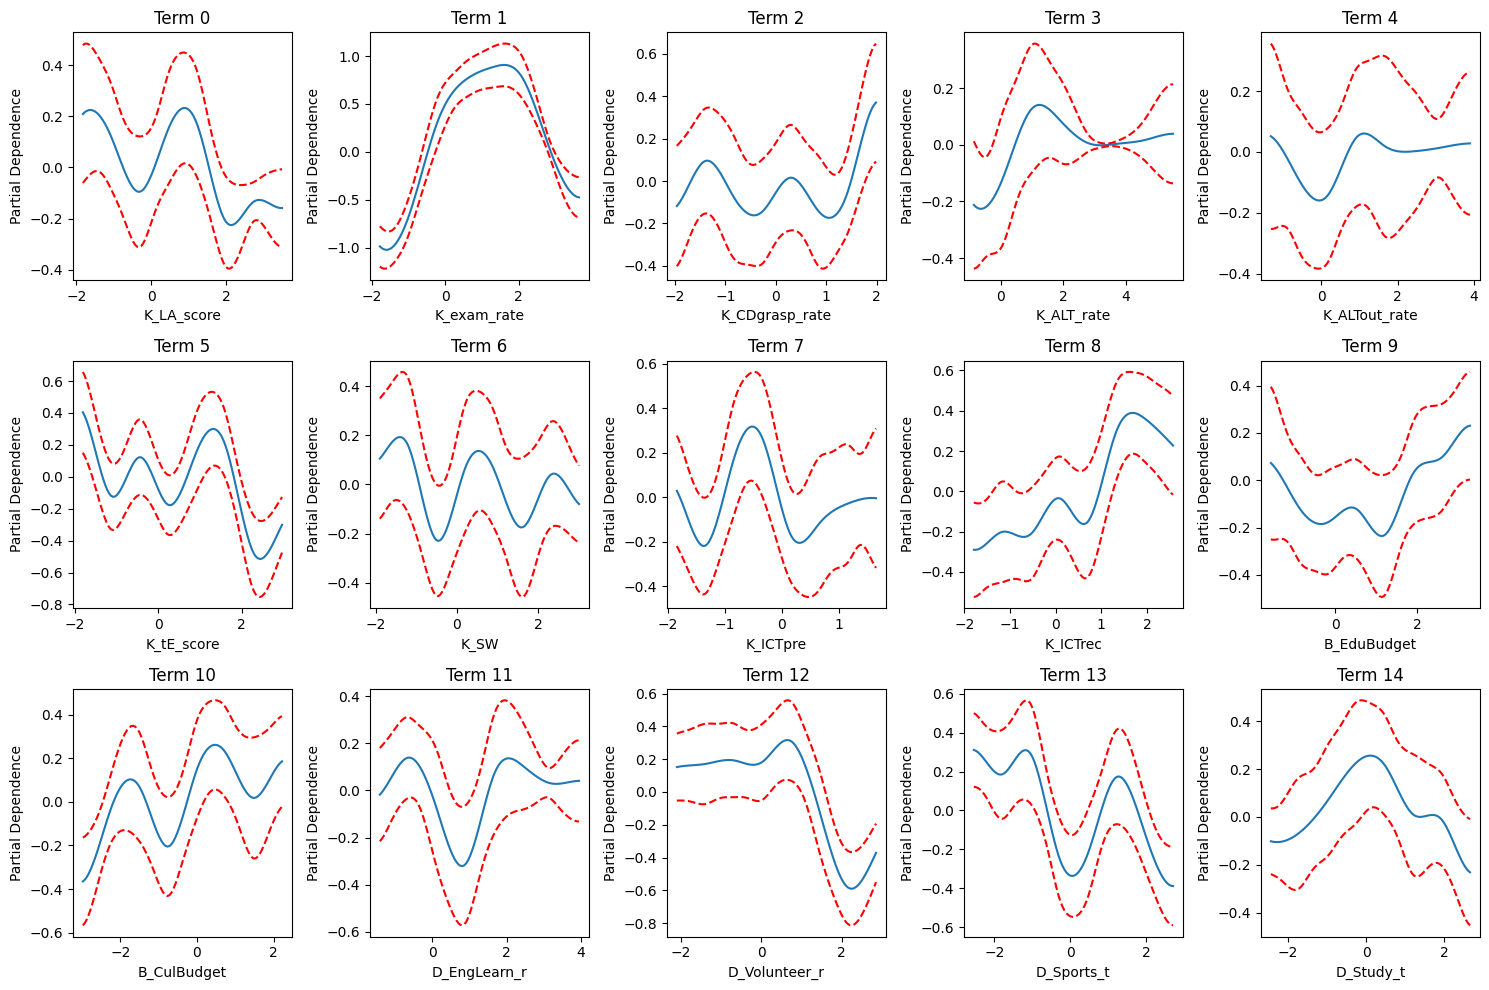

In [ ]:
# Plot the smoothing functions
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(gam.terms) - 1:
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(f'Term {i}')
        ax.set_xlabel(X.columns[i])
        ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

### ⅳ) Model Selection

Selecting steps \
0) Include all the variables nonlinearly \
1) i=2,4,6,8; linearly include \
2) i=4,6; exclude (K_ALT_rate, K_SW)\
*all significant*

*Final Model:* \
K_cefr_rate ~ s(K_LA_score)+s(K_exam_rate)+**l**(K_CDgrasp_rate)+s(K_ALT_rate)+s(K_tE_score)+s(K_ICTpre)+**l**(K_ICTrec)+s(B_EduBudget)+s(B_CulBudget)+s(D_EngLearn_r)+s(D_Volunteer_r)+s(D_Sports_t)+s(D_Study_t)

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['K_cefr_rate']
X = df_std.drop(columns=['K_cefr_rate']) # 15 variables

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + l(2) + s(3, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + l(8) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.4475
Link Function:                     IdentityLink Log Likelihood:                                     30.569
Number of Samples:                           47 AIC:                                               23.7569
                                                AICc:                                            1062.0303
                                                GCV:                                                0.0666
                                                Scale:                                               0.031
                                                Pseudo R-Squared:                                   0.9963
Feature Function                  Lam

<ipython-input-60-a4cfd64f8a15>:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [ ]:
# Display only the selected columns by indices
indices = [0,1,2,3,5,7,8,9,10,11,12,13,14] # 2,8 linear
selected_columns = X.columns[indices]
print(selected_columns)
print("Number of selected columns:", len(selected_columns))

Index(['K_LA_score', 'K_exam_rate', 'K_CDgrasp_rate', 'K_ALT_rate',
       'K_tE_score', 'K_ICTpre', 'K_ICTrec', 'B_EduBudget', 'B_CulBudget',
       'D_EngLearn_r', 'D_Volunteer_r', 'D_Sports_t', 'D_Study_t'],
      dtype='object')
Number of selected columns: 13


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.4475
Link Function:                     IdentityLink Log Likelihood:                                     30.569
Number of Samples:                           47 AIC:                                               23.7569
                                                AICc:                                            1062.0303
                                                GCV:                                                0.0666
                                                Scale:                                               0.031
                                                Pseudo R-Squared:                                   0.9963
Feature Function                  Lam

<ipython-input-64-7a33bf6c25d0>:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


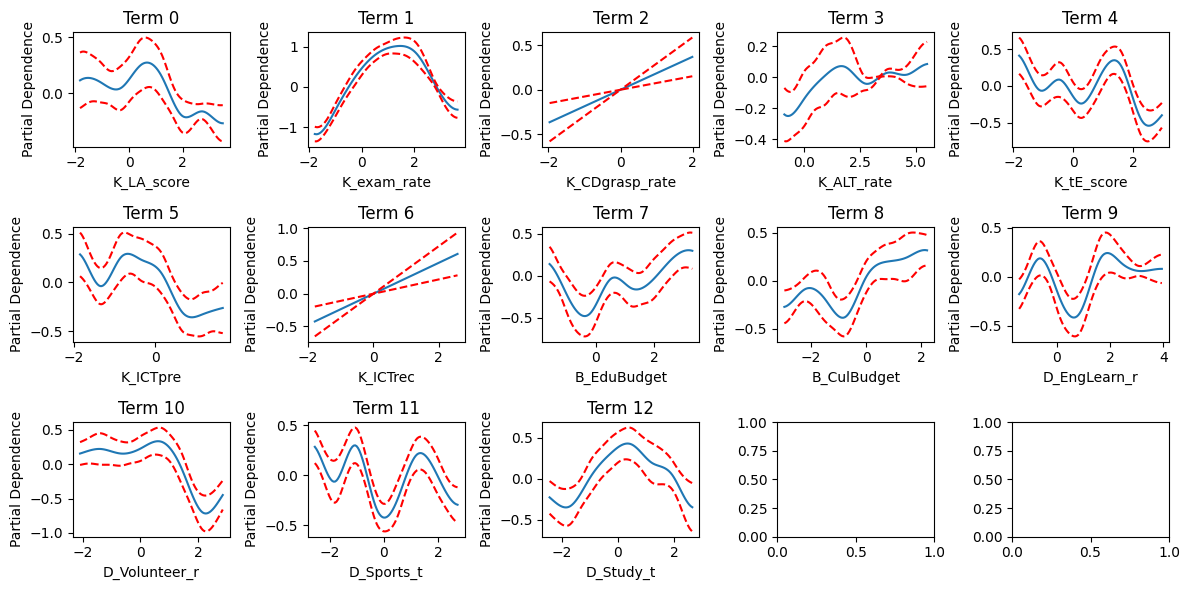

In [ ]:
# Final Model
# Set the response (y) and the predictors (X)
y = df_std['K_cefr_rate']
X = df_std[['K_LA_score', 'K_exam_rate', 'K_CDgrasp_rate', 'K_ALT_rate',
       'K_tE_score', 'K_ICTpre', 'K_ICTrec', 'B_EduBudget', 'B_CulBudget',
       'D_EngLearn_r', 'D_Volunteer_r', 'D_Sports_t', 'D_Study_t']]

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + l(2) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + l(6) + s(7, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam) + s(12, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

###

# Plot the smoothing functions
fig, axs = plt.subplots(3, 5, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    if i < len(gam.terms) - 1:
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(f'Term {i}')
        ax.set_xlabel(X.columns[i])
        ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()


### ⅴ) Prediction vs Observation Plot

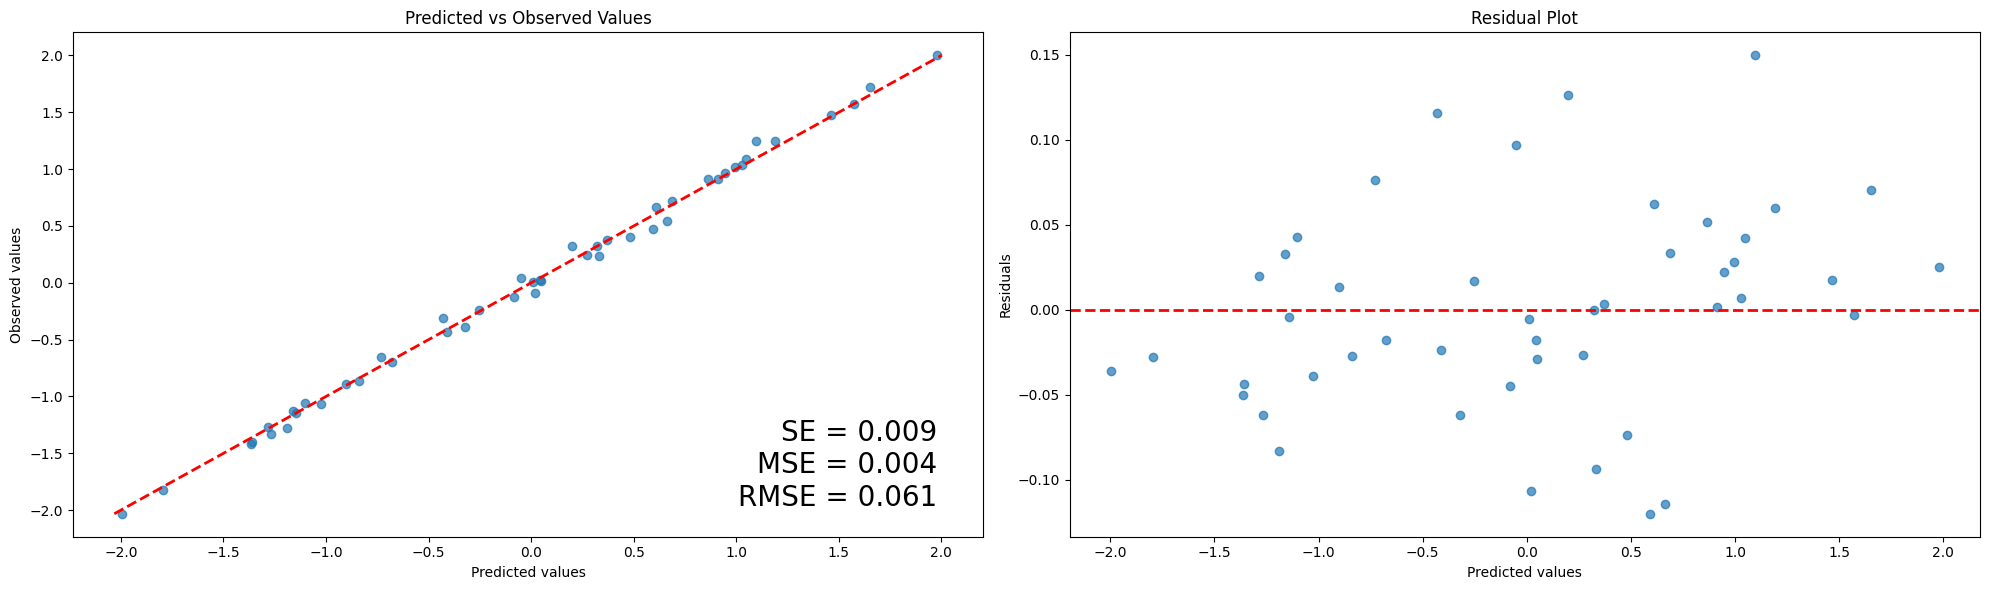

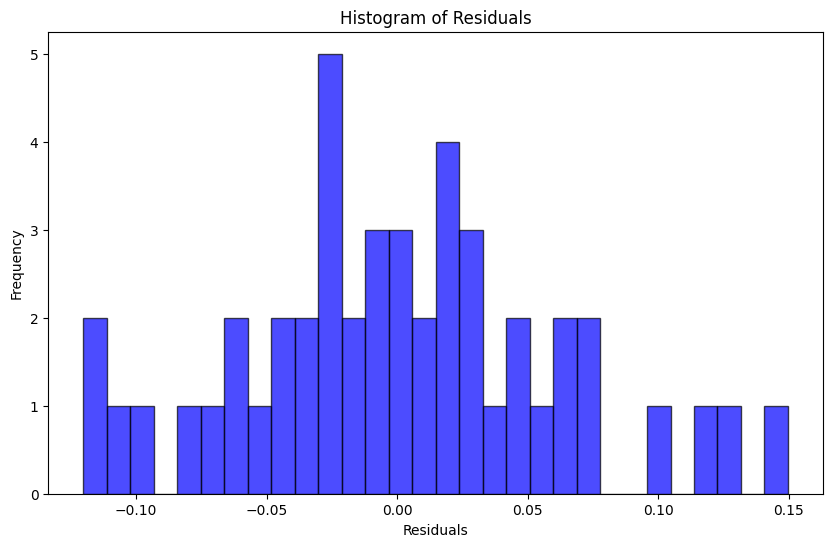

In [ ]:
# Make predictions
y_pred = gam.predict(X)

# Calculate residuals
residuals = y - y_pred

# Calculate the standard error
std_residuals = np.std(residuals)
standard_error = std_residuals / np.sqrt(len(residuals))

# Calculate the mean squared error
mse = np.mean(residuals**2)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Create a 1 by 2 plot matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot predicted vs observed values on the left
axes[0].scatter(y_pred, y, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Predicted values')
axes[0].set_ylabel('Observed values')
axes[0].set_title('Predicted vs Observed Values')

# Add the standard error, MSE, and RMSE text to the predicted vs observed plot
axes[0].text(0.95, 0.05, f'SE = {standard_error:.3f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}',
             verticalalignment='bottom', horizontalalignment='right',
             transform=axes[0].transAxes,
             color='black', fontsize=20)

# Plot residuals on the right
axes[1].scatter(y_pred, residuals, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Adjust layout
plt.tight_layout()
plt.show()

# Plot the histogram of residuals to inspect the distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

15個の説明変数候補について非線形・線形の関係を考慮しつつ選定した結果、最終的には13変数が非線形の説明要因としてモデルに組み込まれた。C_cefr_rate予測モデルに続き、予測値-観測値のプロットがほぼ対角線上に並んでおり、誤差構造は等分散かつほとんどの残差は0.1以内に収まっている(RMSE=0.061)。ただし、説明変数が多く複雑なモデルであるため、解釈にはやや注意を要する。

## 3.3 GAM: C_LA_score

### ⅰ) Data Standardization

※ここでは福井県の行を除外しない（'C_cefr_rate'を**説明変数**として用いるため。）

In [ ]:
# Apply logarithm transformation to C_cefr_rate
df_C = df_1.filter(regex='^C_')
df_C['C_cefr_rate'] = np.log(df_C['C_cefr_rate'])

# Set data frame to standardize
df_set = df_C
df_set = pd.concat([df_set, df_2], axis=1)

# Standardize the DataFrame
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df_set), index=df_set.index, columns=df_set.columns)

# Drop the row named "Fukui" (outlier)
# df_std = df_std.drop(index='Fukui')

print(df_std.shape)
df_std.head()

(47, 16)


<ipython-input-49-943c9965ac3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['C_cefr_rate'] = np.log(df_C['C_cefr_rate'])


C_cefr_rate  C_LA_score  C_exam_rate  C_CDgrasp_rate  C_ALT_rate  \
Prefecture                                                                     
Hokkaido      -1.206254    0.634604    -0.798393        0.643044   -1.159221   
Aomiri         0.041264   -1.085078    -0.222052       -1.243427   -1.182501   
Iwate          0.274831    1.539561     0.956331        0.926049   -0.464688   
Miyagi        -1.484987   -0.286275    -0.898155        1.637352    1.488691   
Akita          0.272375    0.756681     2.914908       -0.015613   -0.078226   

            C_ALTout_rate  C_tE_score      C_SW  C_ICTpre  C_ICTrec  \
Prefecture                                                            
Hokkaido        -1.492951    0.524716  0.520853  0.683754 -0.175071   
Aomiri          -0.318980   -1.549357  0.014489 -0.938413 -0.973938   
Iwate           -0.381888    0.190054  0.625618 -0.748429 -0.035269   
Miyagi          -0.005797   -0.080567  0.264761 -0.660745 -0.384774   
Akita            0.570416    0.958536  0.485931 -0.543832 -1.423301   

            B_EduBudget  B_CulBudget  D_EngLearn_r  D_Volunteer_r  D_Sports_t  \
Prefecture                                                                      
Hokkaido      -0.184776     0.671272     -0.195654      -0.272113   -1.228159   
Aomiri        -1.579846    -1.667489     -1.404653      -2.099158   -2.540057   
Iwate         -0.893491    -1.282046     -1.221472       1.293925   -1.228159   
Miyagi        -0.797521    -0.647525      0.170710      -0.272113   -0.572211   
Akita         -1.440917    -0.486591     -1.331381      -1.838152   -1.884108   

            D_Study_t  
Prefecture             
Hokkaido    -0.817849  
Aomiri       0.139384  
Iwate        1.605148  
Miyagi      -0.698195  
Akita        0.169298

### ⅱ) Hyper-parameter Optimization

n_splines: 4, lambda: 1e-06, AIC: -216.05000543607053, GCV: 0.00015630444735084486
n_splines: 4, lambda: 1e-05, AIC: -67.812778886085, GCV: 0.009502602678061144
n_splines: 4, lambda: 0.0001, AIC: 15.790612663502753, GCV: 0.23069747844354843
n_splines: 4, lambda: 0.001, AIC: 51.05781577065339, GCV: 32.24337127995121
n_splines: 4, lambda: 0.01, AIC: 85.91512536796083, GCV: 1.2737137473591273
n_splines: 4, lambda: 0.1, AIC: 92.57806716660532, GCV: 0.5957202622654206
n_splines: 4, lambda: 1, AIC: 93.00873946060143, GCV: 0.6479314972969986
n_splines: 4, lambda: 10, AIC: 93.29968908951736, GCV: 0.6538599672289445
n_splines: 4, lambda: 100, AIC: 93.3301998253727, GCV: 0.6544326016573105
n_splines: 5, lambda: 1e-06, AIC: -465.53601307627076, GCV: 1.7700481129628246e-07
n_splines: 5, lambda: 1e-05, AIC: -293.0518893710876, GCV: 1.7513630672908526e-05
n_splines: 5, lambda: 0.0001, AIC: -123.01374616733933, GCV: 0.0017333326723686566
n_splines: 5, lambda: 0.001, AIC: 4.814297129614848, GCV: 0.151

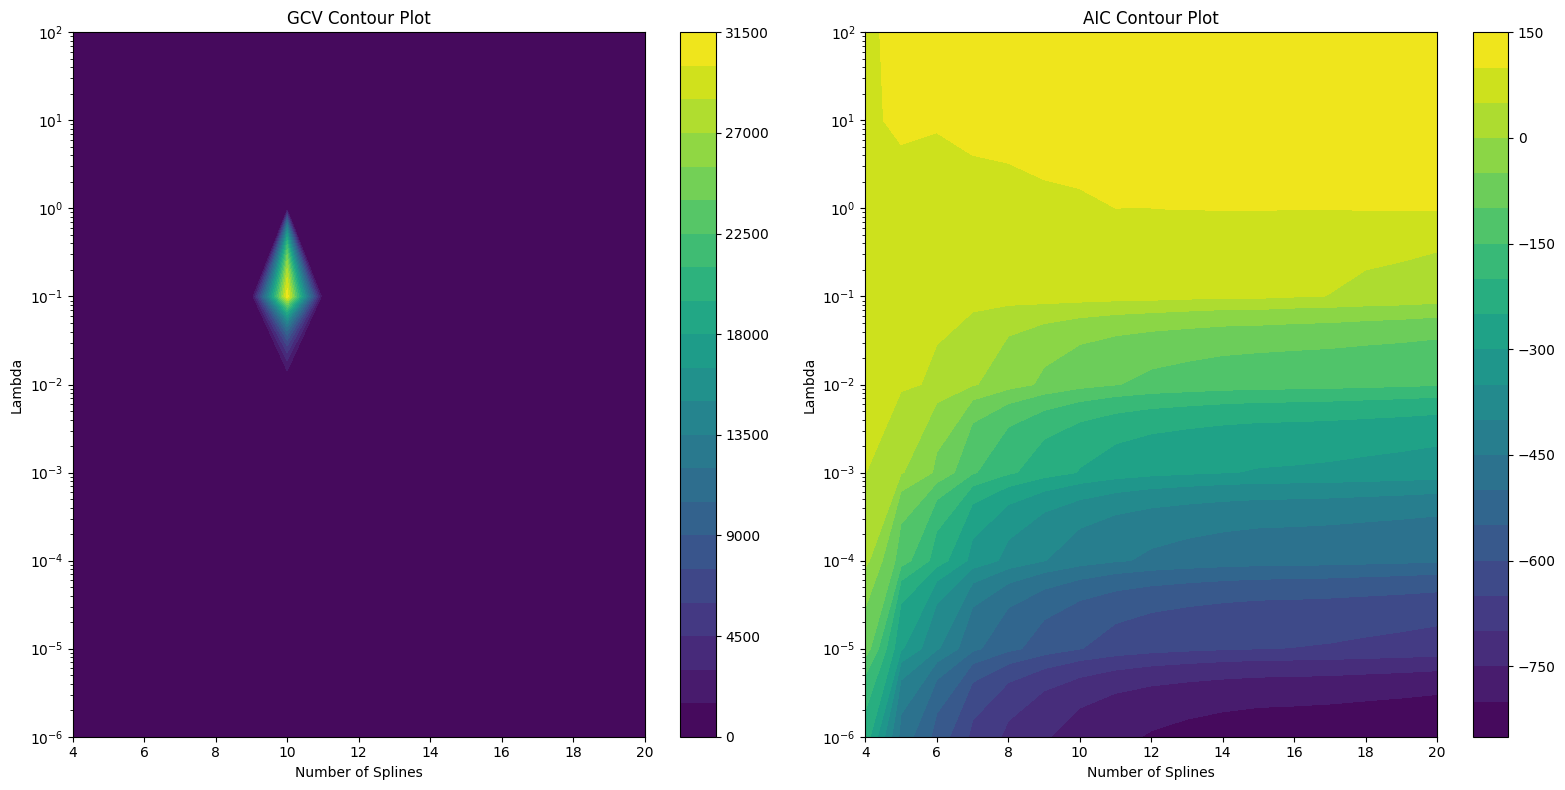

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['C_LA_score']
X = df_std.drop(columns=['C_LA_score'])  # 15 variables

# Define a range of n_splines and lambda values to test
n_splines_range = range(4, 21)
lambda_range = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # Range searched for lambda

# Initialize lists to store AIC and GCV values
aic_values = []
gcv_values = []

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for n_splines in n_splines_range:
    for lam in lambda_range:
        # Initialize lists to store the values for each fold
        fold_aic = []
        fold_gcv = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Create the GAM model with the current number of splines and lambda
            gam = GAM(
                s(0, n_splines=n_splines, lam=lam) + s(1, n_splines=n_splines, lam=lam) + s(2, n_splines=n_splines, lam=lam) + s(3, n_splines=n_splines, lam=lam) + s(4, n_splines=n_splines, lam=lam) +
                s(5, n_splines=n_splines, lam=lam) + s(6, n_splines=n_splines, lam=lam) + s(7, n_splines=n_splines, lam=lam) + s(8, n_splines=n_splines, lam=lam) + s(9, n_splines=n_splines, lam=lam) +
                s(10, n_splines=n_splines, lam=lam) + s(11, n_splines=n_splines, lam=lam) + s(12, n_splines=n_splines, lam=lam) + s(13, n_splines=n_splines, lam=lam) + s(14, n_splines=n_splines, lam=lam),
                distribution='normal',
                link='identity',
            )

            # Fit the model
            gam.fit(X_train, y_train)

            # Compute the AIC and GCV on the test set
            aic = gam.statistics_['AIC']
            gcv = gam.statistics_['GCV']

            fold_aic.append(aic)
            fold_gcv.append(gcv)

        # Compute the mean values for the current n_splines and lambda
        mean_aic = np.mean(fold_aic)
        mean_gcv = np.mean(fold_gcv)

        aic_values.append((n_splines, lam, mean_aic))
        gcv_values.append((n_splines, lam, mean_gcv))

        print(f'n_splines: {n_splines}, lambda: {lam}, AIC: {mean_aic}, GCV: {mean_gcv}')

# Convert the results to NumPy arrays for easy contour plotting
aic_values_np = np.array(aic_values)
gcv_values_np = np.array(gcv_values)

# Reshape for contour plotting
n_splines_grid_aic = aic_values_np[:, 0].reshape(len(n_splines_range), len(lambda_range))
lambda_grid_aic = aic_values_np[:, 1].reshape(len(n_splines_range), len(lambda_range))
aic_grid = aic_values_np[:, 2].reshape(len(n_splines_range), len(lambda_range))

n_splines_grid_gcv = gcv_values_np[:, 0].reshape(len(n_splines_range), len(lambda_range))
lambda_grid_gcv = gcv_values_np[:, 1].reshape(len(n_splines_range), len(lambda_range))
gcv_grid = gcv_values_np[:, 2].reshape(len(n_splines_range), len(lambda_range))

# Plot the AIC and GCV as contour plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# GCV Plot
contour_gcv = axes[0].contourf(n_splines_grid_gcv, lambda_grid_gcv, gcv_grid, cmap='viridis', levels=20)
fig.colorbar(contour_gcv, ax=axes[0])
axes[0].set_xlabel('Number of Splines')
axes[0].set_ylabel('Lambda')
axes[0].set_title('GCV Contour Plot')
axes[0].set_xscale('linear')
axes[0].set_yscale('log')

# AIC Plot
contour_aic = axes[1].contourf(n_splines_grid_aic, lambda_grid_aic, aic_grid, cmap='viridis', levels=20)
fig.colorbar(contour_aic, ax=axes[1])
axes[1].set_xlabel('Number of Splines')
axes[1].set_ylabel('Lambda')
axes[1].set_title('AIC Contour Plot')
axes[1].set_xscale('linear')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

上記2モデルと同様の理由で、以下の組み合わせを選択。

**λ=0.01, n_splines=10**

### ⅲ) Initial GAM

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['C_LA_score']
X = df_std.drop(columns=['C_LA_score']) # 15 variables

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + s(2, n_splines=opt_sp, lam=opt_lam) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      44.505
Link Function:                     IdentityLink Log Likelihood:                                    77.6054
Number of Samples:                           47 AIC:                                              -64.2007
                                                AICc:                                            8486.1343
                                                GCV:                                                0.0096
                                                Scale:                                              0.0192
                                                Pseudo R-Squared:                                    0.999
Feature Function                  Lam

<ipython-input-66-b31703fc88af>:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


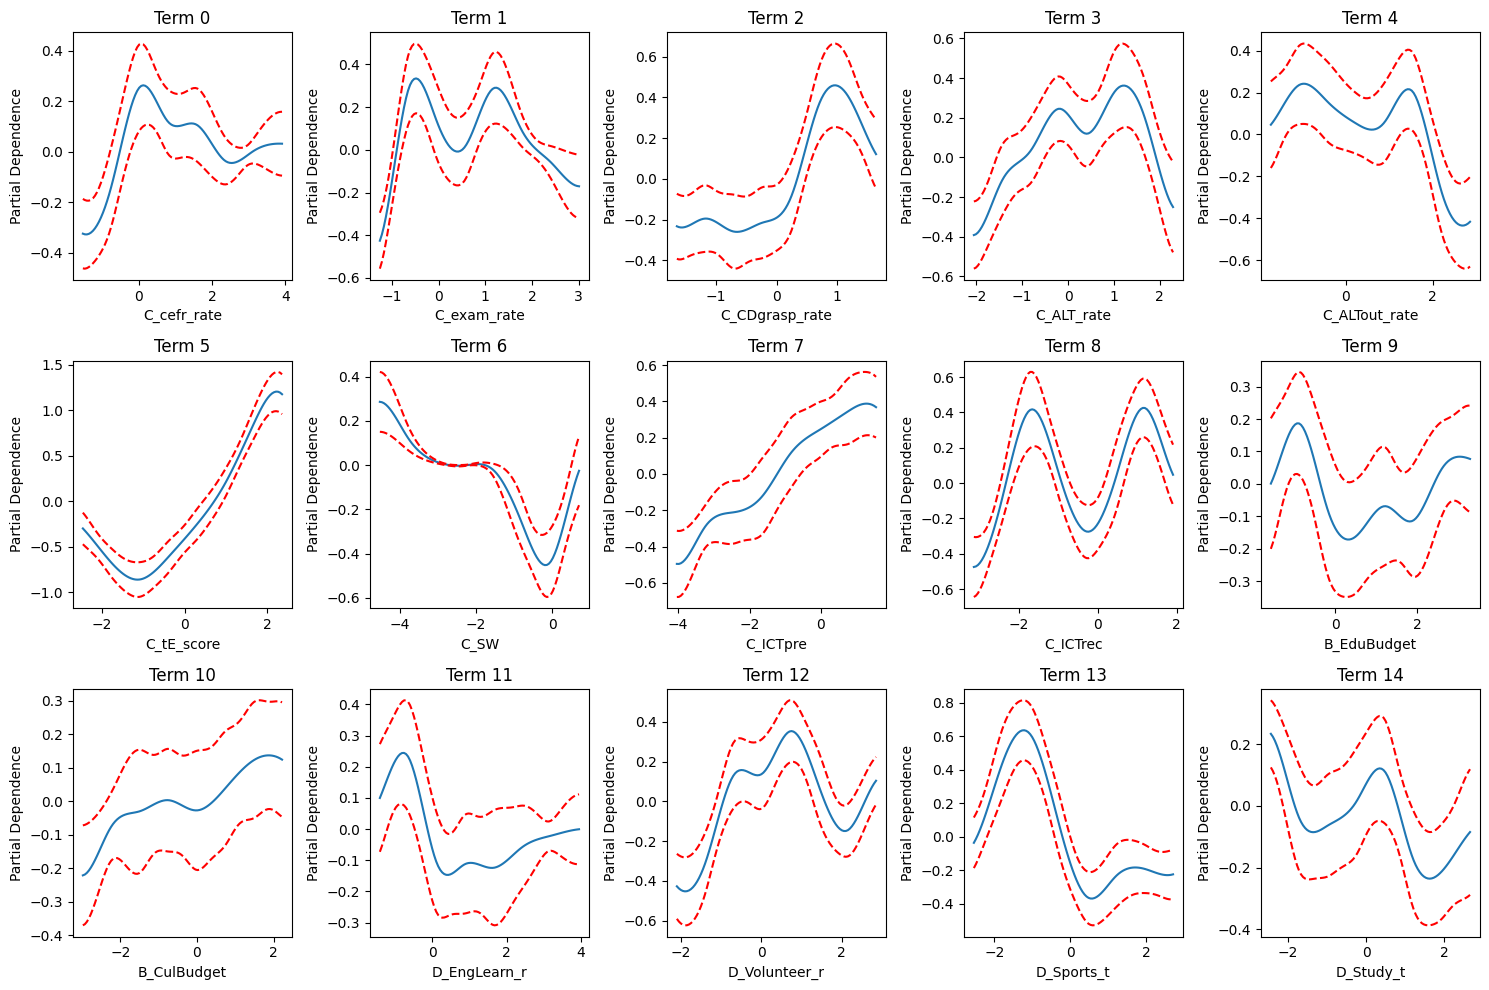

In [ ]:
# Plot the smoothing functions
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(gam.terms) - 1:
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(f'Term {i}')
        ax.set_xlabel(X.columns[i])
        ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

### ⅳ) Model Selection

Selecting steps \
0) Include all the variables nonlinearly \
1) i=4; linearly include \
3) i=11; linearly include \
(4, 11 may be excluded) \
*all significant*


*Final Model:* \
C_LA_score ~ s(C_cefr_rate)+s(C_exam_rate)+s(C_CDgrasp_rate)+s(C_ALT_rate)+s(C_ALTout_rate)+s(C_tE_score)+s(C_SW)+s(C_ICTpre)+s(C_ICTrec)+s(B_EduBudget)+s(B_CulBudget)+s(D_EngLearn_r)+s(D_Volunteer_r)+s(D_Sports_t)+s(D_Study_t)

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['C_LA_score']
X = df_std.drop(columns=['C_LA_score']) # 15 variables

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + s(2, n_splines=opt_sp, lam=opt_lam) + s(3, n_splines=opt_sp, lam=opt_lam) + l(4) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + l(11) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     43.6812
Link Function:                     IdentityLink Log Likelihood:                                    64.3266
Number of Samples:                           47 AIC:                                              -39.2907
                                                AICc:                                            3056.0991
                                                GCV:                                                  0.02
                                                Scale:                                              0.0257
                                                Pseudo R-Squared:                                   0.9982
Feature Function                  Lam

<ipython-input-50-8190256feeaf>:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [ ]:
# Display only the selected columns by indices
indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] # 4,11 linear
selected_columns = X.columns[indices]
print(selected_columns)
print("Number of selected columns:", len(selected_columns))

Index(['C_cefr_rate', 'C_exam_rate', 'C_CDgrasp_rate', 'C_ALT_rate',
       'C_ALTout_rate', 'C_tE_score', 'C_SW', 'C_ICTpre', 'C_ICTrec',
       'B_EduBudget', 'B_CulBudget', 'D_EngLearn_r', 'D_Volunteer_r',
       'D_Sports_t', 'D_Study_t'],
      dtype='object')
Number of selected columns: 15


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     43.6812
Link Function:                     IdentityLink Log Likelihood:                                    64.3266
Number of Samples:                           47 AIC:                                              -39.2907
                                                AICc:                                            3056.0991
                                                GCV:                                                  0.02
                                                Scale:                                              0.0257
                                                Pseudo R-Squared:                                   0.9982
Feature Function                  Lam

<ipython-input-52-128909d1242a>:26: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


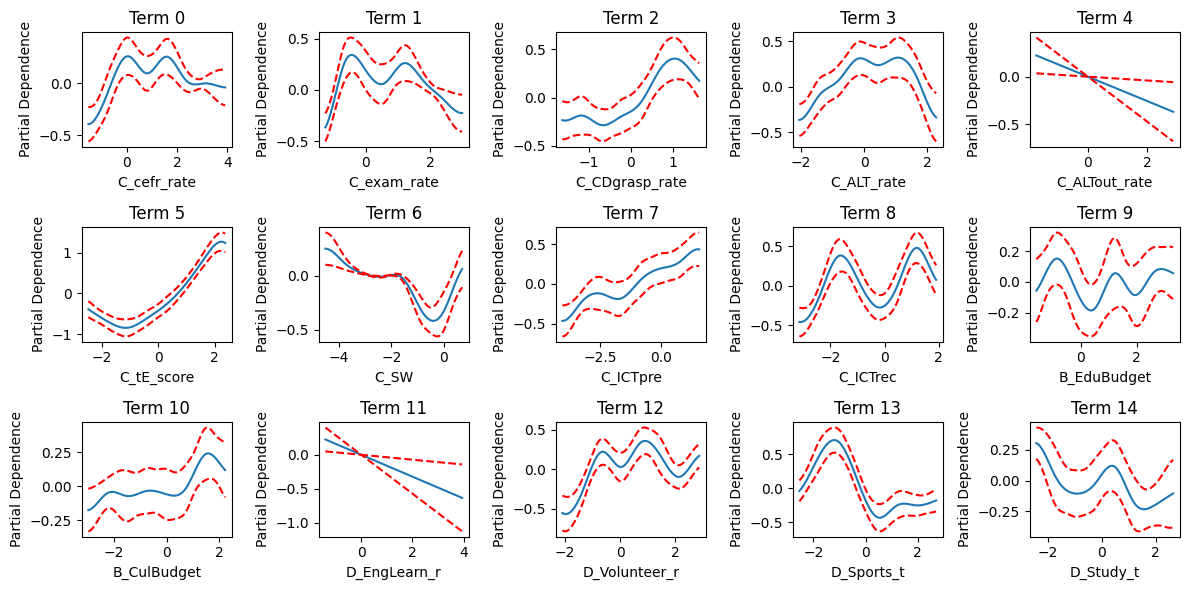

In [ ]:
# Final Model
# Set the response (y) and the predictors (X)
y = df_std['C_LA_score']
X = df_std[['C_cefr_rate', 'C_exam_rate', 'C_CDgrasp_rate', 'C_ALT_rate',
       'C_ALTout_rate', 'C_tE_score', 'C_SW', 'C_ICTpre', 'C_ICTrec',
       'B_EduBudget', 'B_CulBudget', 'D_EngLearn_r', 'D_Volunteer_r',
       'D_Sports_t', 'D_Study_t']]

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + s(2, n_splines=opt_sp, lam=opt_lam) + s(3, n_splines=opt_sp, lam=opt_lam) + l(4) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + l(11) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

###

# Plot the smoothing functions
fig, axs = plt.subplots(3, 5, figsize=(12, 6))

# Filter out intercept terms
non_intercept_terms = [i for i, term in enumerate(gam.terms) if not term.isintercept]

for ax, term_index in zip(axs.flatten(), non_intercept_terms):
    XX = gam.generate_X_grid(term=term_index)
    pdep, confi = gam.partial_dependence(term=term_index, width=0.95)
    ax.plot(XX[:, term_index], pdep)
    ax.plot(XX[:, term_index], confi, c='r', ls='--')
    ax.set_title(f'Term {term_index}')
    ax.set_xlabel(X.columns[term_index])
    ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

### ⅴ) Prediction vs Observation Plot

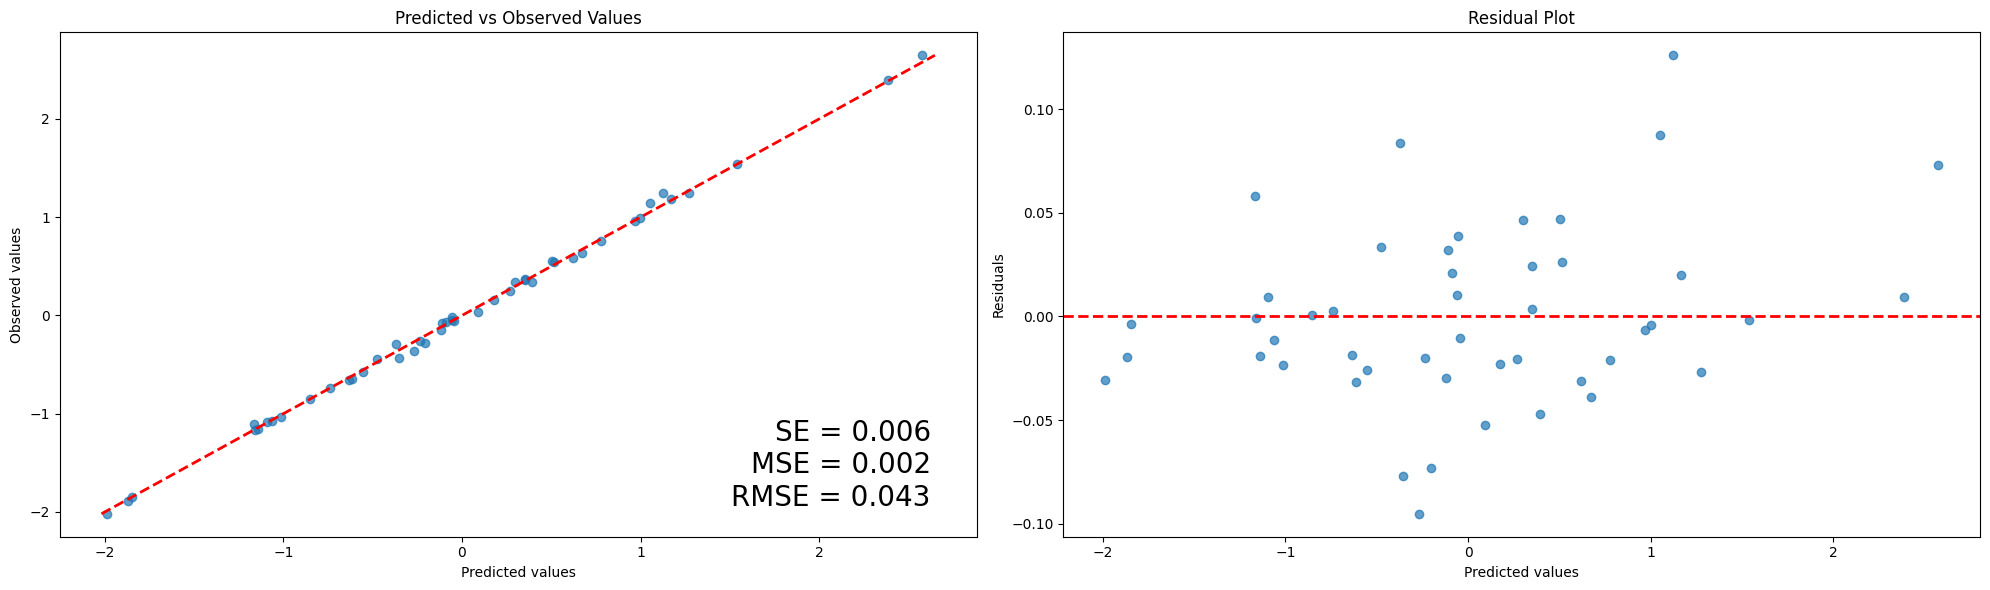

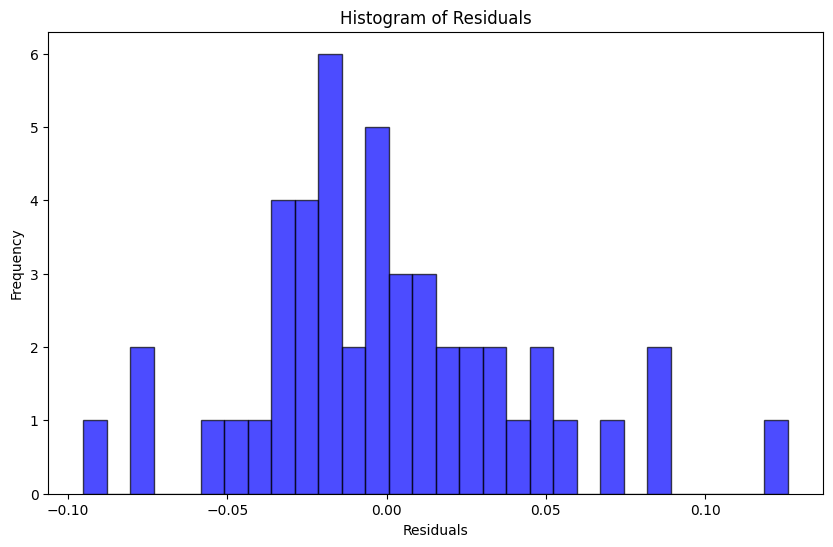

In [ ]:
# Make predictions
y_pred = gam.predict(X)

# Calculate residuals
residuals = y - y_pred

# Calculate the standard error
std_residuals = np.std(residuals)
standard_error = std_residuals / np.sqrt(len(residuals))

# Calculate the mean squared error
mse = np.mean(residuals**2)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Create a 1 by 2 plot matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot predicted vs observed values on the left
axes[0].scatter(y_pred, y, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Predicted values')
axes[0].set_ylabel('Observed values')
axes[0].set_title('Predicted vs Observed Values')

# Add the standard error, MSE, and RMSE text to the predicted vs observed plot
axes[0].text(0.95, 0.05, f'SE = {standard_error:.3f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}',
             verticalalignment='bottom', horizontalalignment='right',
             transform=axes[0].transAxes,
             color='black', fontsize=20)

# Plot residuals on the right
axes[1].scatter(y_pred, residuals, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Adjust layout
plt.tight_layout()
plt.show()

# Plot the histogram of residuals to inspect the distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

15個の説明変数候補について非線形・線形の関係を考慮しつつ選定した結果、最終的には**2変数が線形項、13変数が非線形項**としてモデルに組み込まれた。
C_cefr_rate, K_cefr_rate予測モデルに続き、予測値-観測値のプロットがほぼ対角線上に並んでおり、誤差構造は等分散かつほとんどの残差は0.1以内に収まっている(RMSE=0.043)。中心から離れたデータに対しても上手く予測できている。

## 3.4 GAM: K_LA_score

### ⅰ) Data Standardization

In [ ]:
# Apply logarithm transformation to C_cefr_rate
df_K = df_1.filter(regex='^K_')

# Set data frame to standardize
df_set = df_K
df_set = pd.concat([df_set, df_2], axis=1)

# Standardize the DataFrame
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df_set), index=df_set.index, columns=df_set.columns)

print(df_std.shape)
df_std.head()

(47, 16)


K_cefr_rate  K_LA_score  K_exam_rate  K_CDgrasp_rate  K_ALT_rate  \
Prefecture                                                                     
Hokkaido       0.019549    1.784888    -0.200655        1.172774   -0.467137   
Aomiri         0.719632   -0.966172     0.056903       -1.042298   -0.367660   
Iwate          0.244594    3.499900     1.272655        1.171029   -0.302111   
Miyagi        -0.865759    0.205669    -0.498048       -0.133252   -0.859279   
Akita         -1.274745   -0.294753     3.643979        0.978151   -0.738155   

            K_ALTout_rate  K_tE_score      K_SW  K_ICTpre  K_ICTrec  \
Prefecture                                                            
Hokkaido        -1.179118    2.181227  1.476209 -0.604886 -0.689855   
Aomiri          -0.124251   -0.997654 -0.761657 -1.812529 -1.050614   
Iwate           -0.014682    2.964823  3.013249 -0.398052  0.046694   
Miyagi          -1.052696    0.060325 -0.036939  0.048976  0.332295   
Akita           -0.099367   -0.888889 -0.466992  0.989736 -1.268573   

            B_EduBudget  B_CulBudget  D_EngLearn_r  D_Volunteer_r  D_Sports_t  \
Prefecture                                                                      
Hokkaido      -0.184776     0.671272     -0.195654      -0.272113   -1.228159   
Aomiri        -1.579846    -1.667489     -1.404653      -2.099158   -2.540057   
Iwate         -0.893491    -1.282046     -1.221472       1.293925   -1.228159   
Miyagi        -0.797521    -0.647525      0.170710      -0.272113   -0.572211   
Akita         -1.440917    -0.486591     -1.331381      -1.838152   -1.884108   

            D_Study_t  
Prefecture             
Hokkaido    -0.817849  
Aomiri       0.139384  
Iwate        1.605148  
Miyagi      -0.698195  
Akita        0.169298

### ⅱ) Hyper-parameter Optimization

n_splines: 4, lambda: 1e-06, AIC: -269.92611776733446, GCV: 3.700213080346541e-05
n_splines: 4, lambda: 1e-05, AIC: -112.88138241671011, GCV: 0.0027283037822488842
n_splines: 4, lambda: 0.0001, AIC: -0.8404145811568895, GCV: 0.10919897488934649
n_splines: 4, lambda: 0.001, AIC: 52.92573715608929, GCV: 11.414716500559239
n_splines: 4, lambda: 0.01, AIC: 90.90699179536045, GCV: 1.4578982280583173
n_splines: 4, lambda: 0.1, AIC: 93.89310005042906, GCV: 0.5541610719949832
n_splines: 4, lambda: 1, AIC: 95.42534800985649, GCV: 0.5222421694073519
n_splines: 4, lambda: 10, AIC: 95.55214227258128, GCV: 0.5241124796043081
n_splines: 4, lambda: 100, AIC: 95.56595751424938, GCV: 0.5242802266683622
n_splines: 5, lambda: 1e-06, AIC: -489.00577740741085, GCV: 1.030228731548202e-07
n_splines: 5, lambda: 1e-05, AIC: -316.49078661874154, GCV: 1.0226927869399092e-05
n_splines: 5, lambda: 0.0001, AIC: -146.84308539422221, GCV: 0.0010230119862478355
n_splines: 5, lambda: 0.001, AIC: 3.2567980618215358, GCV

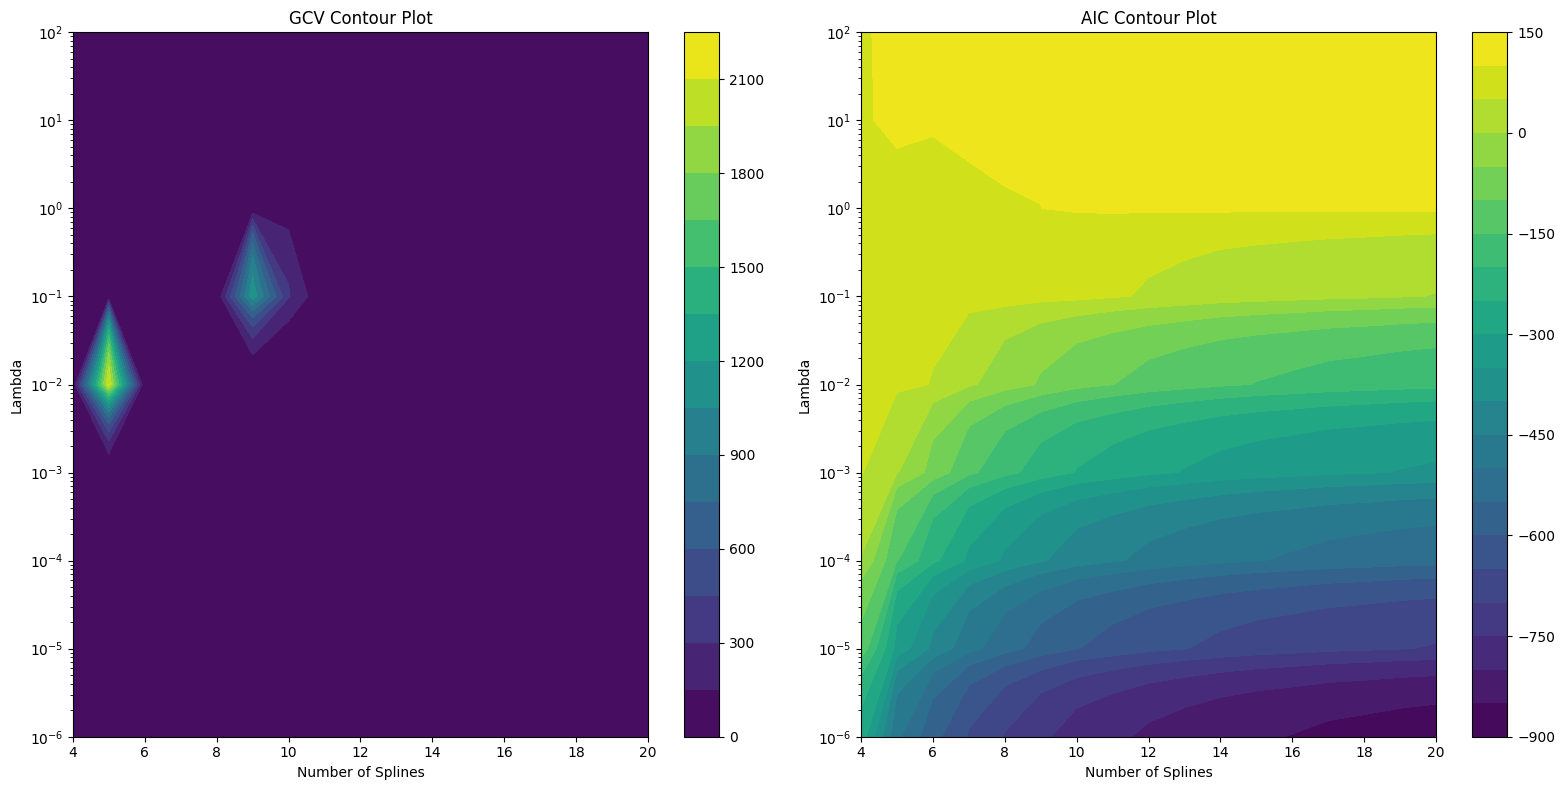

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['K_LA_score']
X = df_std.drop(columns=['K_LA_score'])  # 15 variables

# Define a range of n_splines and lambda values to test
n_splines_range = range(4, 21)
lambda_range = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # Range searched for lambda

# Initialize lists to store AIC and GCV values
aic_values = []
gcv_values = []

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for n_splines in n_splines_range:
    for lam in lambda_range:
        # Initialize lists to store the values for each fold
        fold_aic = []
        fold_gcv = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Create the GAM model with the current number of splines and lambda
            gam = GAM(
                s(0, n_splines=n_splines, lam=lam) + s(1, n_splines=n_splines, lam=lam) + s(2, n_splines=n_splines, lam=lam) + s(3, n_splines=n_splines, lam=lam) + s(4, n_splines=n_splines, lam=lam) +
                s(5, n_splines=n_splines, lam=lam) + s(6, n_splines=n_splines, lam=lam) + s(7, n_splines=n_splines, lam=lam) + s(8, n_splines=n_splines, lam=lam) + s(9, n_splines=n_splines, lam=lam) +
                s(10, n_splines=n_splines, lam=lam) + s(11, n_splines=n_splines, lam=lam) + s(12, n_splines=n_splines, lam=lam) + s(13, n_splines=n_splines, lam=lam) + s(14, n_splines=n_splines, lam=lam),
                distribution='normal',
                link='identity',
            )

            # Fit the model
            gam.fit(X_train, y_train)

            # Compute the AIC and GCV on the test set
            aic = gam.statistics_['AIC']
            gcv = gam.statistics_['GCV']

            fold_aic.append(aic)
            fold_gcv.append(gcv)

        # Compute the mean values for the current n_splines and lambda
        mean_aic = np.mean(fold_aic)
        mean_gcv = np.mean(fold_gcv)

        aic_values.append((n_splines, lam, mean_aic))
        gcv_values.append((n_splines, lam, mean_gcv))

        print(f'n_splines: {n_splines}, lambda: {lam}, AIC: {mean_aic}, GCV: {mean_gcv}')

# Convert the results to NumPy arrays for easy contour plotting
aic_values_np = np.array(aic_values)
gcv_values_np = np.array(gcv_values)

# Reshape for contour plotting
n_splines_grid_aic = aic_values_np[:, 0].reshape(len(n_splines_range), len(lambda_range))
lambda_grid_aic = aic_values_np[:, 1].reshape(len(n_splines_range), len(lambda_range))
aic_grid = aic_values_np[:, 2].reshape(len(n_splines_range), len(lambda_range))

n_splines_grid_gcv = gcv_values_np[:, 0].reshape(len(n_splines_range), len(lambda_range))
lambda_grid_gcv = gcv_values_np[:, 1].reshape(len(n_splines_range), len(lambda_range))
gcv_grid = gcv_values_np[:, 2].reshape(len(n_splines_range), len(lambda_range))

# Plot the AIC and GCV as contour plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# GCV Plot
contour_gcv = axes[0].contourf(n_splines_grid_gcv, lambda_grid_gcv, gcv_grid, cmap='viridis', levels=20)
fig.colorbar(contour_gcv, ax=axes[0])
axes[0].set_xlabel('Number of Splines')
axes[0].set_ylabel('Lambda')
axes[0].set_title('GCV Contour Plot')
axes[0].set_xscale('linear')
axes[0].set_yscale('log')

# AIC Plot
contour_aic = axes[1].contourf(n_splines_grid_aic, lambda_grid_aic, aic_grid, cmap='viridis', levels=20)
fig.colorbar(contour_aic, ax=axes[1])
axes[1].set_xlabel('Number of Splines')
axes[1].set_ylabel('Lambda')
axes[1].set_title('AIC Contour Plot')
axes[1].set_xscale('linear')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

上記3モデルと同様の理由で、以下の組み合わせを選択。

**λ=0.01, n_splines=10**

### ⅲ) Initial GAM

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['K_LA_score']
X = df_std.drop(columns=['K_LA_score']) # 15 variables

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + s(2, n_splines=opt_sp, lam=opt_lam) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     44.8424
Link Function:                     IdentityLink Log Likelihood:                                    84.2335
Number of Samples:                           47 AIC:                                              -76.7822
                                                AICc:                                           27172.3532
                                                GCV:                                                0.0136
                                                Scale:                                              0.0335
                                                Pseudo R-Squared:                                   0.9985
Feature Function                  Lam

<ipython-input-16-711d0bc63c8a>:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


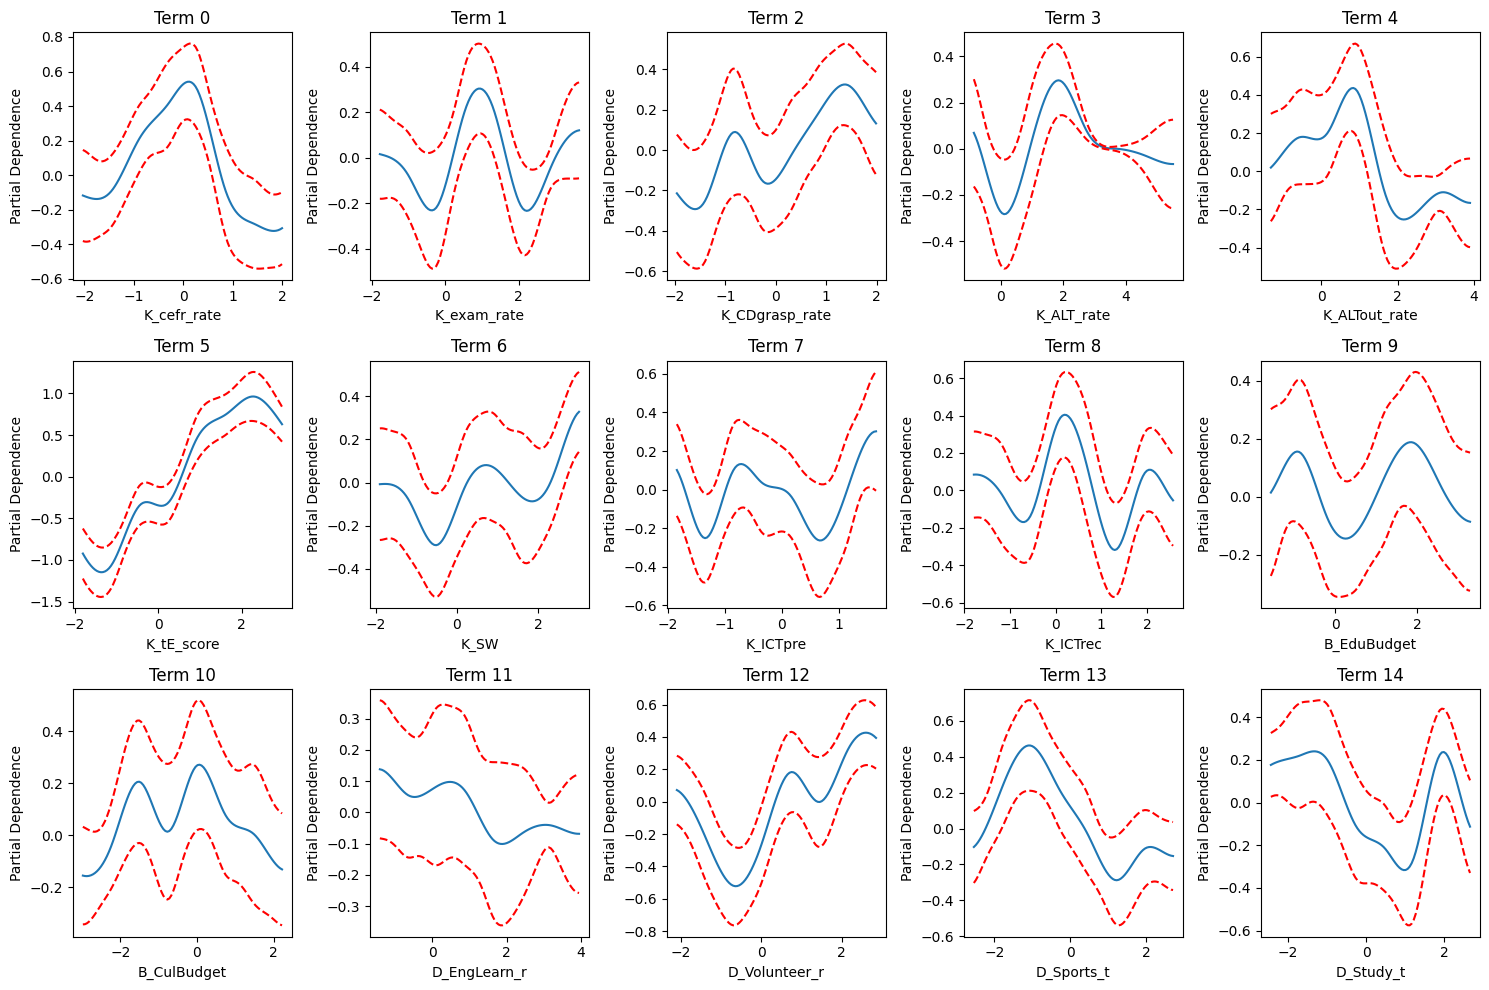

In [ ]:
# Plot the smoothing functions
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(gam.terms) - 1:
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(f'Term {i}')
        ax.set_xlabel(X.columns[i])
        ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

### ⅳ) Model Selection

Selecting steps \
0) Include all the variables nonlinearly \
1) i=2,9,10; linearly include \
2) i=11; linearly include \
3) i=9,10; exclude \
4) i=2; exclude \

*all significant*

*Final Model:* \
K_LA_score ~ s(K_cefr_rate)+s(K_exam_rate)+s(K_ALT_rate)+s(K_ALTout_rate)+s(K_tE_score)+s(K_SW)+s(K_ICTpre)+s(K_ICTrec)+**l**(D_EngLearn_r)+s(D_Volunteer_r)+s(D_Sports_t)+s(D_Study_t)

In [ ]:
# Set the response (y) and the predictors (X)
y = df_std['K_LA_score']
X = df_std.drop(columns=['K_LA_score']) # 15 variables

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + s(8, n_splines=opt_sp, lam=opt_lam) +
    l(11) + s(12, n_splines=opt_sp, lam=opt_lam) + s(13, n_splines=opt_sp, lam=opt_lam) + s(14, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.9846
Link Function:                     IdentityLink Log Likelihood:                                    47.4303
Number of Samples:                           47 AIC:                                               -8.8913
                                                AICc:                                            1245.1154
                                                GCV:                                                0.0843
                                                Scale:                                              0.0496
                                                Pseudo R-Squared:                                   0.9947
Feature Function                  Lam

<ipython-input-55-74a2ef63361a>:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [ ]:
# Display only the selected columns by indices
indices = [0,1,3,4,5,6,7,8,11,12,13,14] # 11 linear
selected_columns = X.columns[indices]
print(selected_columns)
print("Number of selected columns:", len(selected_columns))

Index(['K_cefr_rate', 'K_exam_rate', 'K_ALT_rate', 'K_ALTout_rate',
       'K_tE_score', 'K_SW', 'K_ICTpre', 'K_ICTrec', 'D_EngLearn_r',
       'D_Volunteer_r', 'D_Sports_t', 'D_Study_t'],
      dtype='object')
Number of selected columns: 12


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.9846
Link Function:                     IdentityLink Log Likelihood:                                    47.4303
Number of Samples:                           47 AIC:                                               -8.8913
                                                AICc:                                            1245.1154
                                                GCV:                                                0.0843
                                                Scale:                                              0.0496
                                                Pseudo R-Squared:                                   0.9947
Feature Function                  Lam

<ipython-input-57-705d15be8c2f>:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


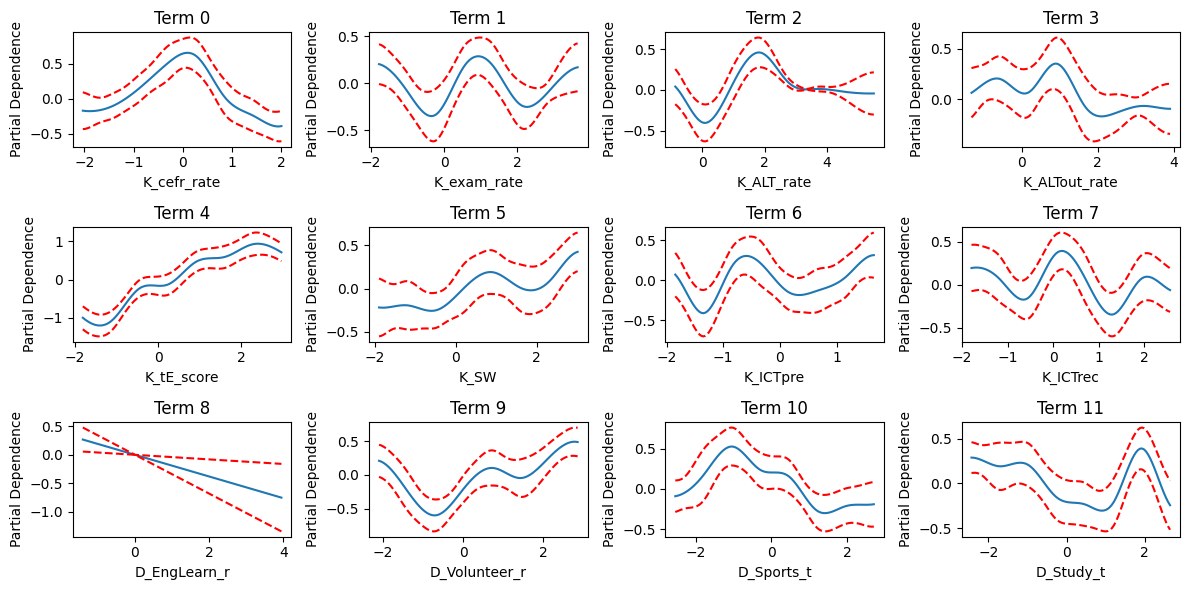

In [ ]:
# Final Model
# Set the response (y) and the predictors (X)
y = df_std['K_LA_score']
X = df_std[['K_cefr_rate', 'K_exam_rate', 'K_ALT_rate', 'K_ALTout_rate',
       'K_tE_score', 'K_SW', 'K_ICTpre', 'K_ICTrec', 'D_EngLearn_r',
       'D_Volunteer_r', 'D_Sports_t', 'D_Study_t']]

# Hyper parameters: number of splines & lambda
opt_sp = 10
opt_lam = 0.01

# Create the GAM model with the normal family
gam = GAM(
    s(0, n_splines=opt_sp, lam=opt_lam) + s(1, n_splines=opt_sp, lam=opt_lam) + s(2, n_splines=opt_sp, lam=opt_lam) + s(3, n_splines=opt_sp, lam=opt_lam) + s(4, n_splines=opt_sp, lam=opt_lam) +
    s(5, n_splines=opt_sp, lam=opt_lam) + s(6, n_splines=opt_sp, lam=opt_lam) + s(7, n_splines=opt_sp, lam=opt_lam) + l(8) + s(9, n_splines=opt_sp, lam=opt_lam) +
    s(10, n_splines=opt_sp, lam=opt_lam) + s(11, n_splines=opt_sp, lam=opt_lam),
    distribution='normal',
    link='identity',
)

# Fit the model
gam.fit(X, y)

# Print the summary of the model
print(gam.summary())

###

# Plot the smoothing functions
fig, axs = plt.subplots(3, 4, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    if i < len(gam.terms) - 1:
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(f'Term {i}')
        ax.set_xlabel(X.columns[i])
        ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

### ⅴ) Prediction vs Observation Plot

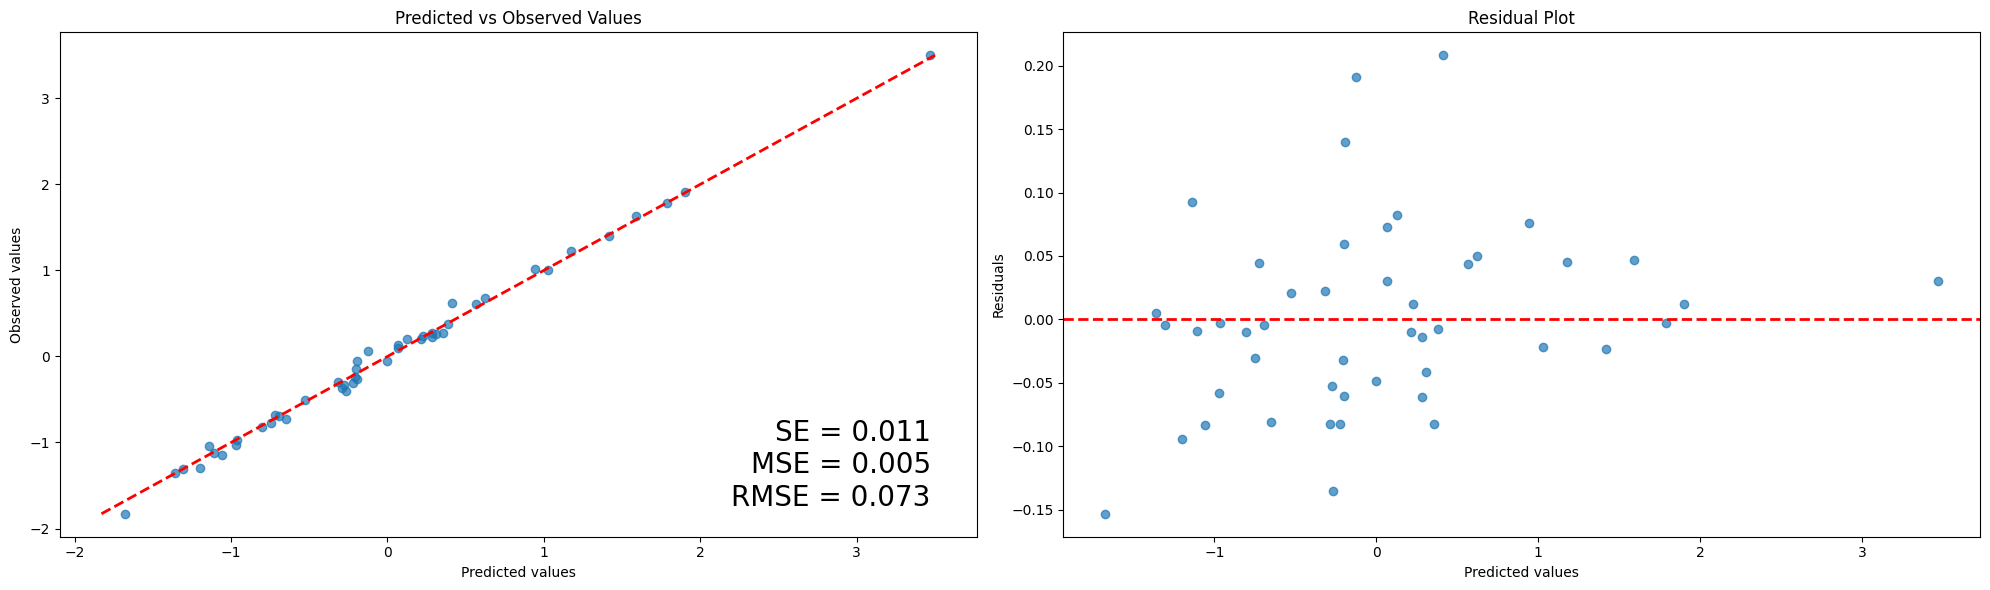

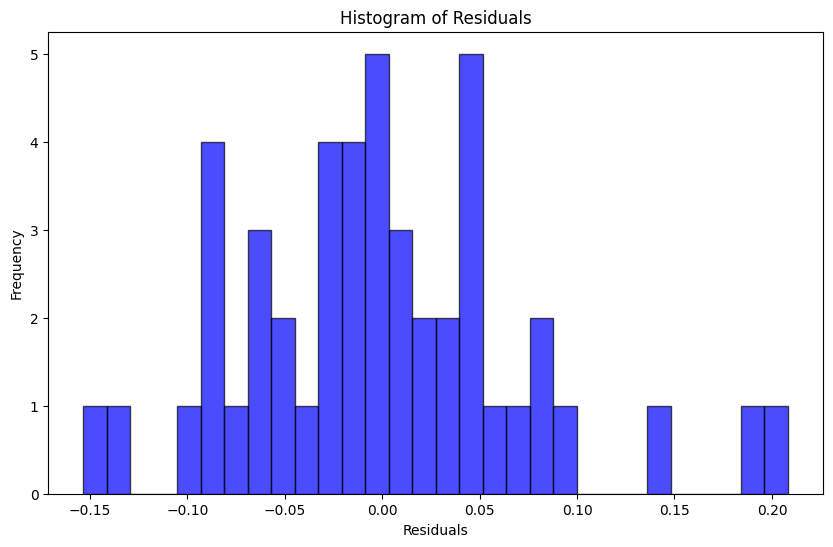

In [ ]:
# Make predictions
y_pred = gam.predict(X)

# Calculate residuals
residuals = y - y_pred

# Calculate the standard error
std_residuals = np.std(residuals)
standard_error = std_residuals / np.sqrt(len(residuals))

# Calculate the mean squared error
mse = np.mean(residuals**2)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Create a 1 by 2 plot matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot predicted vs observed values on the left
axes[0].scatter(y_pred, y, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Predicted values')
axes[0].set_ylabel('Observed values')
axes[0].set_title('Predicted vs Observed Values')

# Add the standard error, MSE, and RMSE text to the predicted vs observed plot
axes[0].text(0.95, 0.05, f'SE = {standard_error:.3f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}',
             verticalalignment='bottom', horizontalalignment='right',
             transform=axes[0].transAxes,
             color='black', fontsize=20)

# Plot residuals on the right
axes[1].scatter(y_pred, residuals, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Adjust layout
plt.tight_layout()
plt.show()

# Plot the histogram of residuals to inspect the distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

15個の説明変数候補について非線形・線形の関係を考慮しつつ選定した結果、最終的には**2変数が線形項、9変数が非線形項**としてモデルに組み込まれた。 上記3モデルに続き、予測値-観測値のプロットがほぼ対角線上に並んでおり、誤差構造は等分散かつほとんどの残差は0.15以内に収まっている(RMSE=0.073)。中心から離れたデータに対しても上手く予測できている。